Visualizing sample: /kaggle/input/preprocessed-cr-gcn/preprocessed_cr_gcn/train/MIDI-Unprocessed_04_R1_2006_01-04_ORIG_MID--AUDIO_04_R1_2006_01_Track01_wav.pt


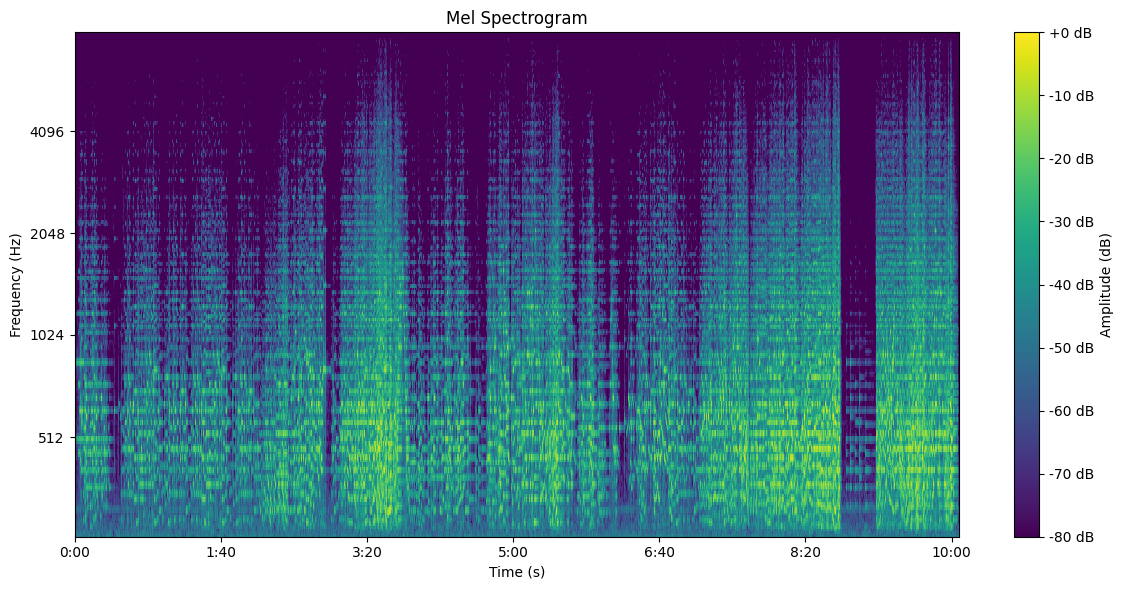

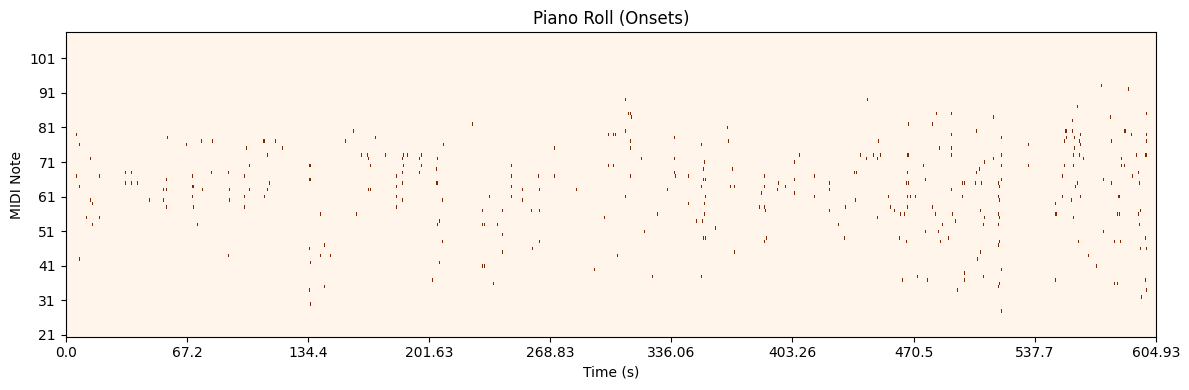

In [1]:
import os
import torch
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path

# Constants (from authors' constants.py)
SAMPLE_RATE = 16000
HOP_LENGTH = 512
N_MELS = 229
MEL_FMIN = 30
MEL_FMAX = SAMPLE_RATE // 2  
WINDOW_LENGTH = 2048
MIN_MIDI = 21
MAX_MIDI = 108

def load_sample(pt_path):
    """Load a single .pt file from the preprocessed dataset."""
    try:
        data = torch.load(pt_path, weights_only=False)
        if not all(k in data for k in ['path', 'audio', 'label', 'velocity']):
            raise ValueError(f"Invalid PT file: {pt_path}")
        return data
    except Exception as e:
        raise ValueError(f"Error loading {pt_path}: {e}")

def compute_mel_spectrogram(audio, sr=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LENGTH,
                          window_length=WINDOW_LENGTH, fmin=MEL_FMIN, fmax=MEL_FMAX):


    audio = audio.cpu().numpy().astype(np.float32) / 32768.0  # Undo authors' scaling

    audio = np.clip(audio, -1.0, 1.0)
    
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=n_mels,
        hop_length=hop_length,
        n_fft=window_length,
        fmin=fmin,
        fmax=fmax,
        htk=True
    )
    # Convert to log scale (mirroring authors' log(clamp) in mel.py)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec

def plot_mel_spectrogram(mel_spec, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, fmin=MEL_FMIN, fmax=MEL_FMAX):

    plt.figure(figsize=(12, 6))
    librosa.display.specshow(
        mel_spec,
        sr=sr,
        hop_length=hop_length,
        fmin=fmin,
        fmax=fmax,
        x_axis='time',
        y_axis='mel',
        cmap='viridis'
    )
    plt.colorbar(format='%+2.0f dB', label='Amplitude (dB)')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.savefig('/kaggle/working/mel_spectrogram.pdf')
    plt.show()

def plot_piano_roll(labels, hop_length=HOP_LENGTH, sr=SAMPLE_RATE, min_midi=MIN_MIDI, max_midi=MAX_MIDI):
    """Plot piano roll from label matrix (onsets only)."""
    # Convert PyTorch tensor to NumPy array
    onsets = (labels.cpu() == 3).numpy().astype(np.float32)  # Onset labels (3 = onset)
    plt.figure(figsize=(12, 4))
    plt.imshow(
        onsets.T,
        origin='lower',
        aspect='auto',
        interpolation='nearest',
        cmap='Oranges'
    )
    
    n_keys = max_midi - min_midi + 1
    plt.yticks(
        ticks=np.arange(n_keys)[::10],
        labels=np.arange(min_midi, max_midi + 1)[::10]
    )
    time_secs = np.arange(onsets.shape[0]) * hop_length / sr
    num_ticks = 10
    tick_positions = np.linspace(0, onsets.shape[0] - 1, num_ticks, dtype=int)
    tick_labels = np.round(time_secs[tick_positions], 2)
    plt.xticks(
        ticks=tick_positions,
        labels=tick_labels
    )
    plt.title('Piano Roll (Onsets)')
    plt.xlabel('Time (s)')
    plt.ylabel('MIDI Note')
    plt.tight_layout()
    plt.savefig('/kaggle/working/piano_roll.pdf')
    plt.show()

def visualize_sample(pt_path):

    data = load_sample(pt_path)
    audio = data['audio']
    labels = data['label']

    mel_spec = compute_mel_spectrogram(audio)
    

    plot_mel_spectrogram(mel_spec)
    
    # Plot piano roll (onsets)
    plot_piano_roll(labels)

if __name__ == "__main__":
    train_dir = '/kaggle/input/preprocessed-cr-gcn/preprocessed_cr_gcn/train'
    pt_files = list(Path(train_dir).glob('*.pt'))
    if not pt_files:
        raise ValueError(f"No .pt files found in {train_dir}")
    
    sample_pt_path = pt_files[0]
    print(f"Visualizing sample: {sample_pt_path}")
    visualize_sample(sample_pt_path)

Visualizing TSV sample: /kaggle/input/preprocessed-cr-gcn/preprocessed_cr_gcn/train/MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_01_Track01_wav.tsv


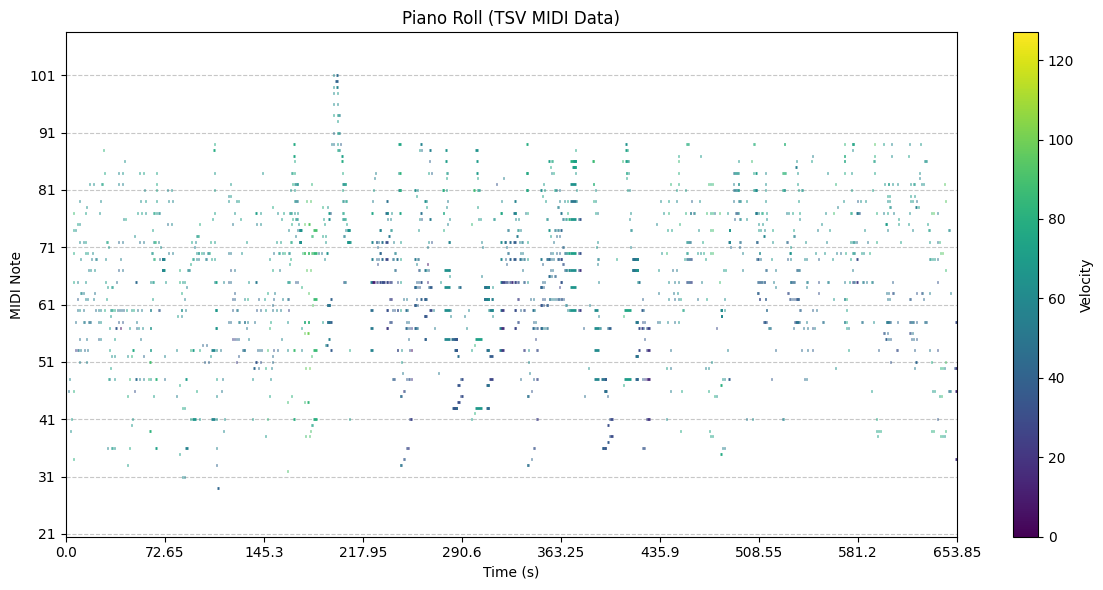

Visualizing TSV sample: /kaggle/input/preprocessed-cr-gcn/preprocessed_cr_gcn/train/MIDI-Unprocessed_075_PIANO075_MID--AUDIO-split_07-08-17_Piano-e_2-06_wav--2.tsv


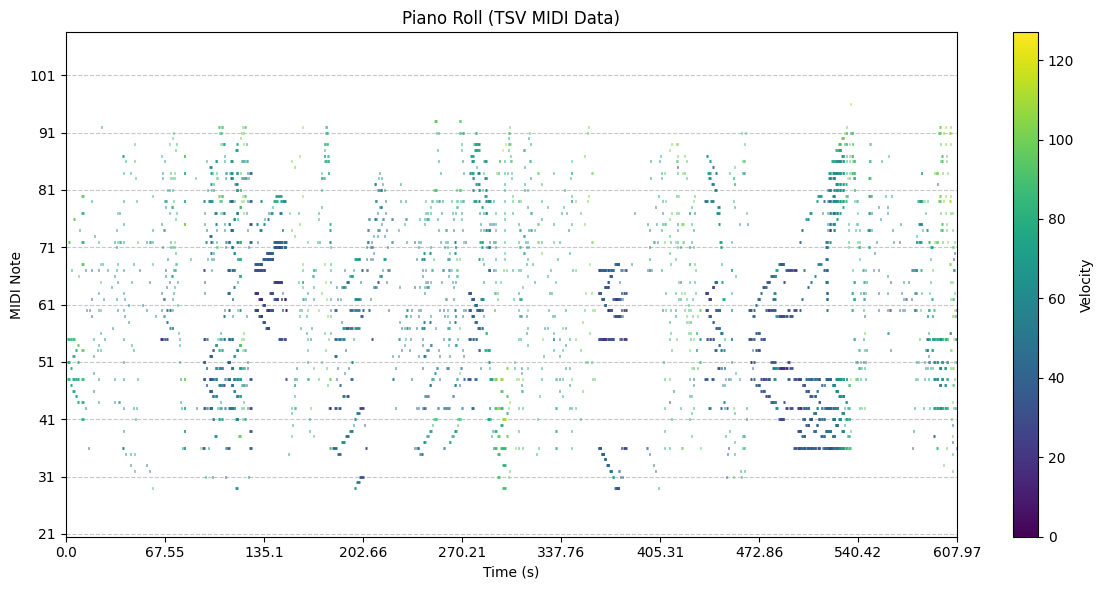

Visualizing TSV sample: /kaggle/input/preprocessed-cr-gcn/preprocessed_cr_gcn/train/MIDI-Unprocessed_049_PIANO049_MID--AUDIO-split_07-06-17_Piano-e_2-06_wav--3.tsv


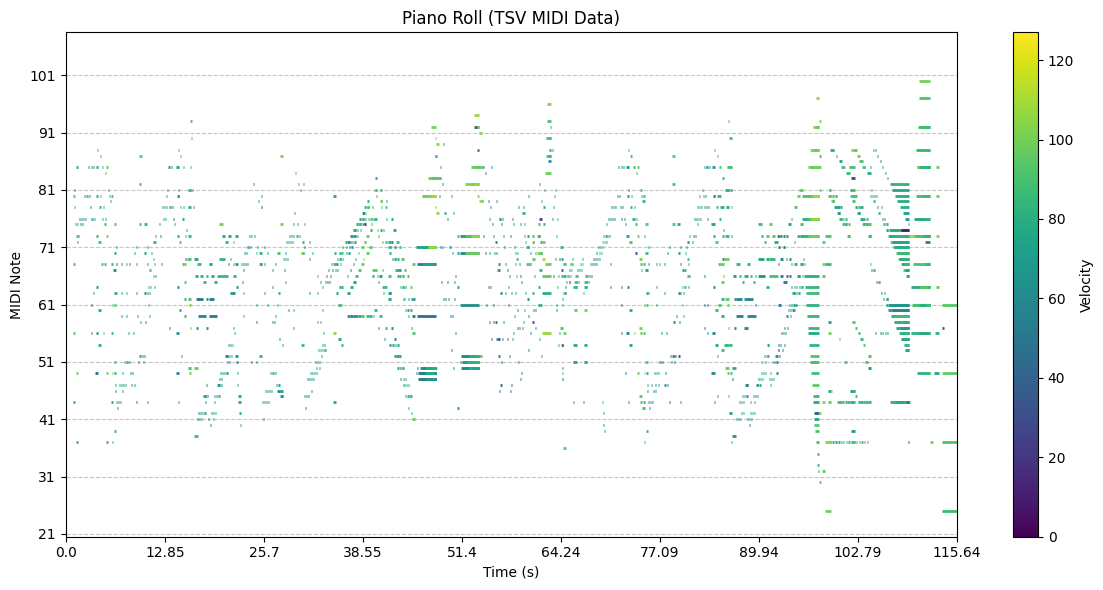

Visualizing TSV sample: /kaggle/input/preprocessed-cr-gcn/preprocessed_cr_gcn/train/MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--6.tsv


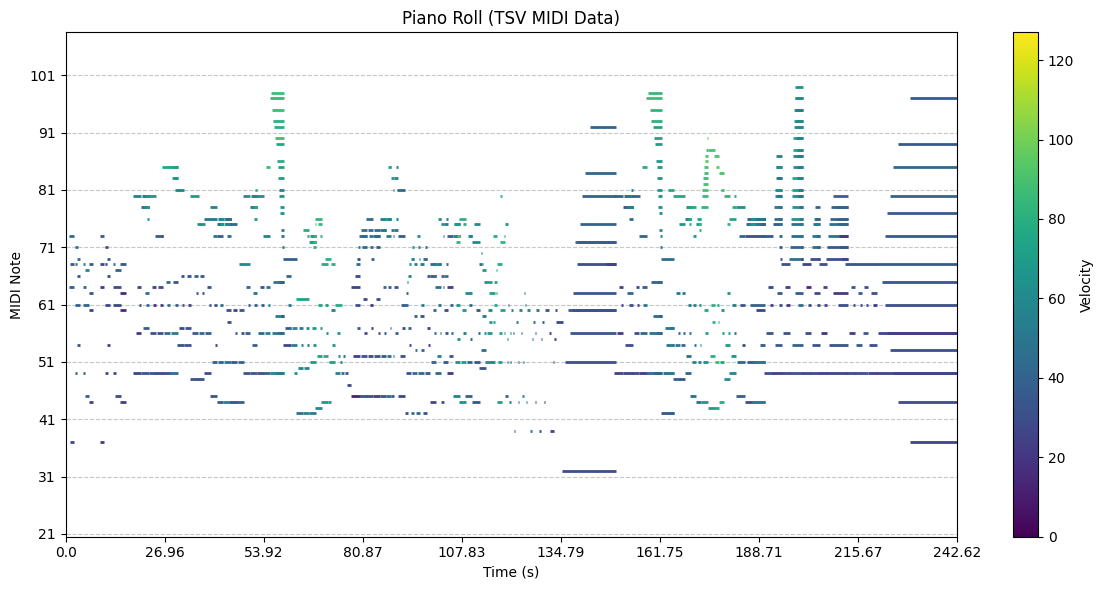

Visualizing TSV sample: /kaggle/input/preprocessed-cr-gcn/preprocessed_cr_gcn/train/ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--2.tsv


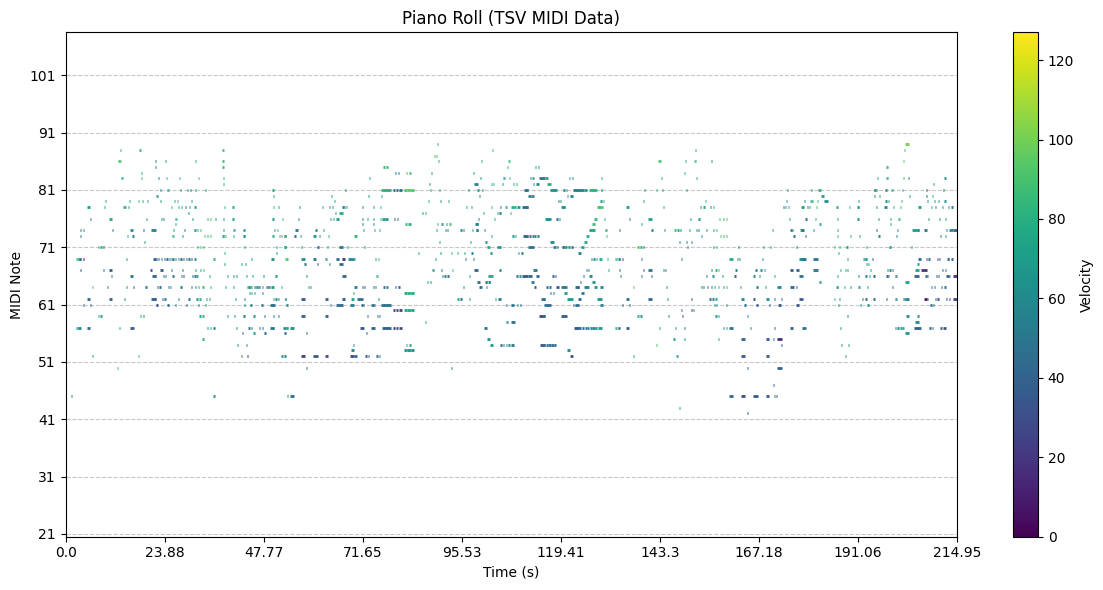

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
MIN_MIDI = 21
MAX_MIDI = 108

def load_tsv(tsv_path):
    """Load a .tsv file and return onset, offset, note, velocity data."""
    try:
        df = pd.read_csv(tsv_path, sep='\t', header=0)
        if not all(col in df.columns for col in ['onset', 'offset', 'note', 'velocity']):
            print(f"Invalid columns in {tsv_path}: {df.columns.tolist()}")
            df = pd.read_csv(tsv_path, sep='\t', names=['onset', 'offset', 'note', 'velocity'], skiprows=1)
            if df.empty:
                raise ValueError("Empty or invalid TSV after retrying without header")
        expected_dtypes = {'onset': np.floating, 'offset': np.floating, 'note': np.integer, 'velocity': np.integer}
        for col, dtype in expected_dtypes.items():
            if not np.issubdtype(df[col].dtype, dtype):
                raise ValueError(f"Invalid dtype for {col}: got {df[col].dtype}, expected {dtype}")
        data = df[['onset', 'offset', 'note', 'velocity']].to_numpy()
        valid_mask = (data[:, 2] >= MIN_MIDI) & (data[:, 2] <= MAX_MIDI) & (data[:, 0] < data[:, 1])
        data = data[valid_mask]
        if data.size == 0:
            raise ValueError(f"No valid MIDI notes in {tsv_path}")
        return data
    except Exception as e:
        raise ValueError(f"Error loading {tsv_path}: {e}")

def plot_piano_roll_tsv(midi_data, min_midi=MIN_MIDI, max_midi=MAX_MIDI):
    """Plot piano roll from TSV MIDI data."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    onsets = midi_data[:, 0] 
    offsets = midi_data[:, 1] 
    notes = midi_data[:, 2]   
    velocities = midi_data[:, 3] / 127.0 
    
    if not (np.all(onsets >= 0) and np.all(offsets >= onsets) and np.all(velocities >= 0)):
        raise ValueError("Invalid MIDI data: negative times or velocities detected")
    
    # Plot each note as a horizontal bar
    for onset, offset, note, velocity in zip(onsets, offsets, notes, velocities):
        y = int(note) - min_midi
        ax.plot([onset, offset], [y, y], color=plt.cm.viridis(velocity), linewidth=2, solid_capstyle='butt')

    n_keys = max_midi - min_midi + 1
    ax.set_yticks(np.arange(n_keys)[::10])
    ax.set_yticklabels(np.arange(min_midi, max_midi + 1)[::10])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('MIDI Note')
    ax.set_title('Piano Roll (TSV MIDI Data)')
    
    max_time = np.max(offsets) if offsets.size > 0 else 1.0
    num_ticks = 10
    tick_positions = np.linspace(0, max_time, num_ticks)
    tick_labels = np.round(tick_positions, 2)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

    ax.set_xlim(0, max_time)
    ax.set_ylim(-0.5, n_keys - 0.5)
  
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=127))
    plt.colorbar(sm, ax=ax, label='Velocity')
    
    plt.tight_layout()
    plt.savefig('piano_roll_tsv.pdf')
    plt.show()

def visualize_tsv(tsv_path):
    """Visualize piano roll from a TSV file."""
    try:
        midi_data = load_tsv(tsv_path)
        plot_piano_roll_tsv(midi_data)
    except ValueError as e:
        print(f"Skipping {tsv_path}: {e}")

if __name__ == "__main__":
    train_dir = r'/kaggle/input/preprocessed-cr-gcn/preprocessed_cr_gcn/train'
    tsv_files = list(Path(train_dir).glob('*.tsv'))
    if not tsv_files:
        raise ValueError(f"No .tsv files found in {train_dir}")

    for sample_tsv_path in tsv_files[:5]:  # Check first 5 files
        print(f"Visualizing TSV sample: {sample_tsv_path}")
        visualize_tsv(sample_tsv_path)

Found 966 TSV files


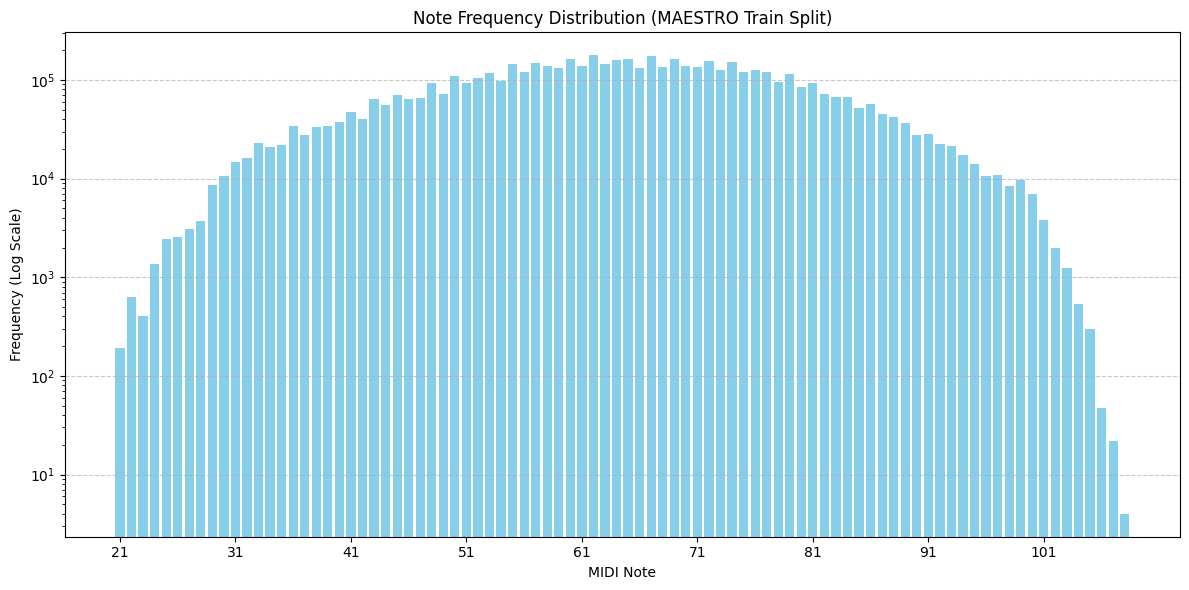


Note Frequency Statistics:
Number of unique notes: 88
Most frequent note (MIDI): 62
Least frequent note (MIDI): 108
Average notes per file: 5914.07

Note percentages (for notes with non-zero counts):
MIDI Note 21: 0.00%
MIDI Note 22: 0.01%
MIDI Note 23: 0.01%
MIDI Note 24: 0.02%
MIDI Note 25: 0.04%
MIDI Note 26: 0.04%
MIDI Note 27: 0.05%
MIDI Note 28: 0.07%
MIDI Note 29: 0.15%
MIDI Note 30: 0.19%
MIDI Note 31: 0.26%
MIDI Note 32: 0.29%
MIDI Note 33: 0.41%
MIDI Note 34: 0.37%
MIDI Note 35: 0.39%
MIDI Note 36: 0.60%
MIDI Note 37: 0.49%
MIDI Note 38: 0.59%
MIDI Note 39: 0.59%
MIDI Note 40: 0.66%
MIDI Note 41: 0.82%
MIDI Note 42: 0.70%
MIDI Note 43: 1.13%
MIDI Note 44: 0.98%
MIDI Note 45: 1.22%
MIDI Note 46: 1.12%
MIDI Note 47: 1.14%
MIDI Note 48: 1.63%
MIDI Note 49: 1.27%
MIDI Note 50: 1.90%
MIDI Note 51: 1.61%
MIDI Note 52: 1.82%
MIDI Note 53: 2.05%
MIDI Note 54: 1.70%
MIDI Note 55: 2.55%
MIDI Note 56: 2.09%
MIDI Note 57: 2.58%
MIDI Note 58: 2.45%
MIDI Note 59: 2.29%
MIDI Note 60: 2.86%

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import tempfile

MIN_MIDI = 21
MAX_MIDI = 108

def load_tsv(tsv_path):
    """Load a .tsv file and return note data."""
    try:

        with open(tsv_path, 'r') as f:
            first_line = f.readline().strip()
      
            if ',' in first_line:
                print(f"Fixing comma-separated header in {tsv_path}")
                with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.tsv') as temp_file:
                    temp_file.write(first_line.replace(',', '\t') + '\n')
                    temp_file.writelines(f.readlines())
                    temp_path = temp_file.name
                df = pd.read_csv(temp_path, sep='\t', header=0)
                os.unlink(temp_path)
            else:
                df = pd.read_csv(tsv_path, sep='\t', header=0)


        expected_cols = ['onset', 'offset', 'note', 'velocity']
        if not all(col in df.columns for col in expected_cols):
            raise ValueError(f"Invalid columns: {df.columns.tolist()}")

        # Convert note to integer
        df['note'] = pd.to_numeric(df['note'], errors='coerce').astype(np.int32)
        if df['note'].isna().any():
            raise ValueError(f"Non-numeric note values detected")


        valid_mask = (df['note'] >= MIN_MIDI) & (df['note'] <= MAX_MIDI)
        notes = df['note'][valid_mask].to_numpy()
        return notes
    except Exception as e:
        print(f"Skipping {tsv_path}: Error loading: {e}")
        return np.array([])

def analyze_note_frequencies(train_dir):
    """Analyze note frequencies across all TSV files."""
    tsv_files = list(Path(train_dir).glob('*.tsv'))
    print(f"Found {len(tsv_files)} TSV files")


    note_counts = np.zeros(MAX_MIDI - MIN_MIDI + 1, dtype=np.int64)
    total_notes = 0
    processed_files = 0


    for tsv_path in tsv_files:
        notes = load_tsv(tsv_path)
        if notes.size > 0:

            for note in notes:
                note_counts[note - MIN_MIDI] += 1
            total_notes += len(notes)
            processed_files += 1
        else:
            print(f"No valid notes in {tsv_path}")

  
    unique_notes = np.sum(note_counts > 0)
    most_frequent_idx = np.argmax(note_counts)
    least_frequent_idx = np.argmin(note_counts[note_counts > 0]) if unique_notes > 0 else -1
    most_frequent_note = most_frequent_idx + MIN_MIDI
    least_frequent_note = least_frequent_idx + MIN_MIDI if least_frequent_idx >= 0 else None
    avg_notes_per_file = total_notes / processed_files if processed_files > 0 else 0
    note_percentages = (note_counts / total_notes * 100) if total_notes > 0 else np.zeros_like(note_counts)

    # Plot log-scale histogram
    plt.figure(figsize=(12, 6))
    midi_notes = np.arange(MIN_MIDI, MAX_MIDI + 1)
    plt.bar(midi_notes, note_counts, width=0.8, color='skyblue')
    plt.yscale('log')
    plt.xlabel('MIDI Note')
    plt.ylabel('Frequency (Log Scale)')
    plt.title('Note Frequency Distribution (MAESTRO Train Split)')
    plt.xticks(np.arange(MIN_MIDI, MAX_MIDI + 1, 10))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


    print("\nNote Frequency Statistics:")
    print(f"Number of unique notes: {unique_notes}")
    print(f"Most frequent note (MIDI): {most_frequent_note}")
    print(f"Least frequent note (MIDI): {least_frequent_note if least_frequent_note is not None else 'N/A'}")
    print(f"Average notes per file: {avg_notes_per_file:.2f}")
    print("\nNote percentages (for notes with non-zero counts):")
    for i, percentage in enumerate(note_percentages):
        if note_counts[i] > 0:  # Only print notes that appear
            print(f"MIDI Note {i + MIN_MIDI}: {percentage:.2f}%")

if __name__ == "__main__":
    train_dir = r'/kaggle/input/preprocessed-cr-gcn/preprocessed_cr_gcn/train'
    analyze_note_frequencies(train_dir)

Processing train split: Found 966 TSV files
Processing validation split: Found 137 TSV files
Processing test split: Found 178 TSV files


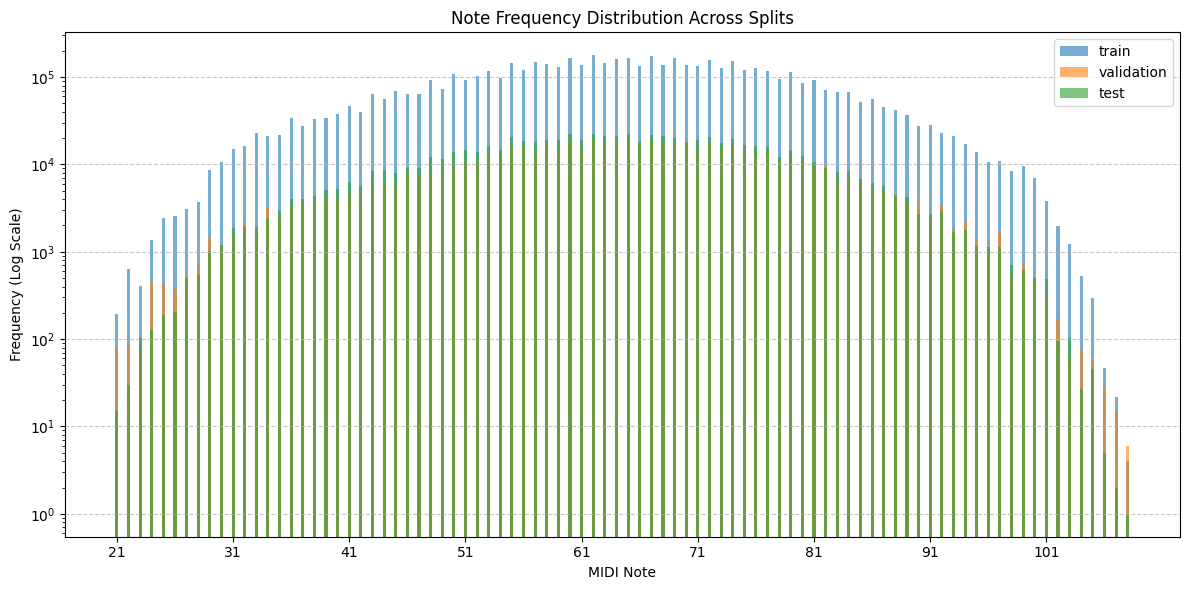

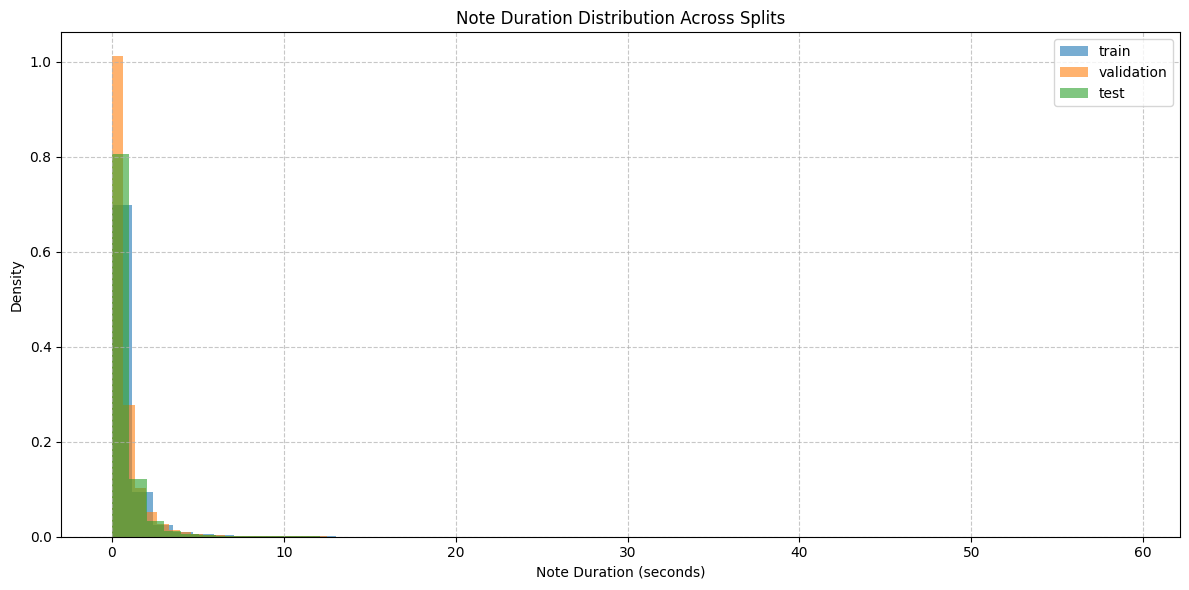

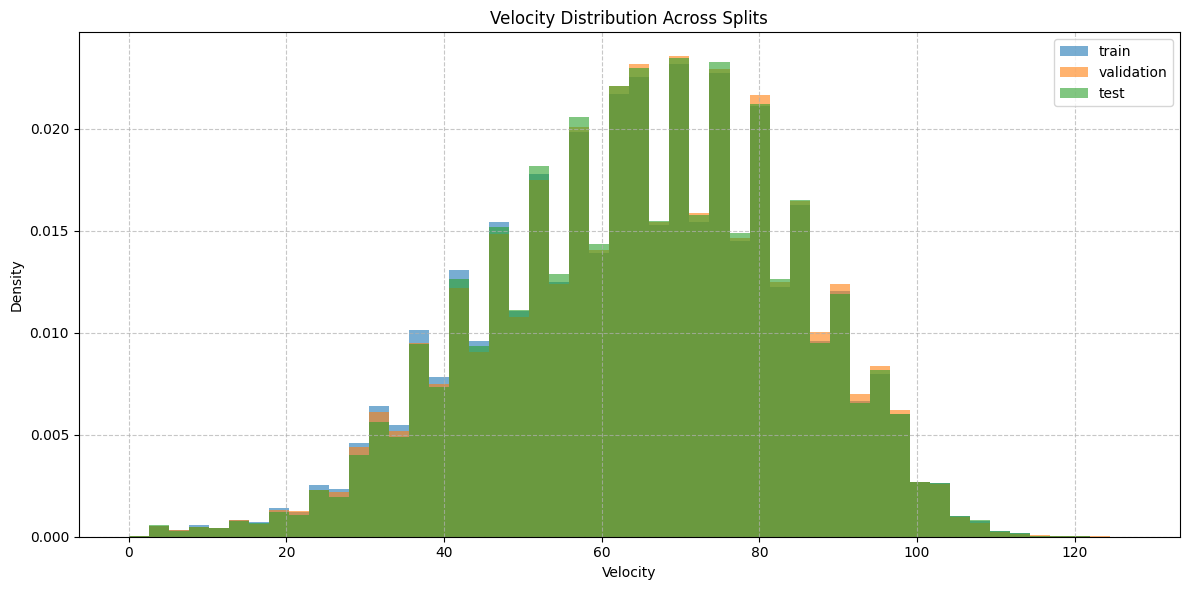


Dataset Statistics
-----------------

train Split:
Total Files: 966
Processed Files: 966
Total Notes: 5712993
Unique Notes: 88
Average Duration (seconds): 0.7792
Average Velocity: 64.58

validation Split:
Total Files: 137
Processed Files: 137
Total Notes: 638443
Unique Notes: 88
Average Duration (seconds): 0.7734
Average Velocity: 65.07

test Split:
Total Files: 178
Processed Files: 178
Total Notes: 758934
Unique Notes: 88
Average Duration (seconds): 0.7365
Average Velocity: 65.02


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Constants (from authors' constants.py)
MIN_MIDI = 21
MAX_MIDI = 108

def load_tsv(tsv_path):
    """Load a fixed .tsv file and return relevant data."""
    try:
        df = pd.read_csv(tsv_path, sep='\t', header=0)
        expected_cols = ['onset', 'offset', 'note', 'velocity']
        if not all(col in df.columns for col in expected_cols):
            print(f"Skipping {tsv_path}: Invalid columns {df.columns.tolist()}")
            return None
        # Filter valid MIDI notes
        valid_mask = (df['note'] >= MIN_MIDI) & (df['note'] <= MAX_MIDI)
        df = df[valid_mask]
        return df
    except Exception as e:
        print(f"Skipping {tsv_path}: Error loading: {e}")
        return None

def analyze_split(split_dir, split_name):
    """Analyze TSV files in a split for visualization data."""
    tsv_files = list(Path(split_dir).glob('*.tsv'))
    print(f"Processing {split_name} split: Found {len(tsv_files)} TSV files")
    
    note_counts = np.zeros(MAX_MIDI - MIN_MIDI + 1, dtype=np.int64)
    durations = []
    velocities = []
    total_notes = 0
    num_processed = 0
    
    for tsv_path in tsv_files:
        df = load_tsv(tsv_path)
        if df is None:
            continue
        # Note counts
        note_values = df['note'].to_numpy()
        for note in note_values:
            note_counts[note - MIN_MIDI] += 1
        # Durations
        durations.extend((df['offset'] - df['onset']).to_numpy())
        # Velocities
        velocities.extend(df['velocity'].to_numpy())
        # Track total notes and processed files
        total_notes += len(df)
        num_processed += 1
    
    return {
        'note_counts': note_counts,
        'durations': np.array(durations),
        'velocities': np.array(velocities),
        'total_notes': total_notes,
        'num_files': len(tsv_files),
        'num_processed': num_processed
    }

def visualize_dataset(base_dir):
    """Generate visualizations and print statistics for the dataset across all splits."""
    splits = [
        ('train', os.path.join(base_dir, 'train')),
        ('validation', os.path.join(base_dir, 'validation')),
        ('test', os.path.join(base_dir, 'test'))
    ]
    
    split_data = {}
    for split_name, split_dir in splits:
        if not os.path.exists(split_dir):
            print(f"Skipping {split_name} split: Directory {split_dir} does not exist")
            continue
        split_data[split_name] = analyze_split(split_dir, split_name)
    
    # 1. Note Frequency Histogram (All Splits)
    plt.figure(figsize=(12, 6))
    midi_notes = np.arange(MIN_MIDI, MAX_MIDI + 1)
    for split_name, data in split_data.items():
        plt.bar(midi_notes, data['note_counts'], width=0.8/len(split_data), label=split_name, alpha=0.6)
    plt.yscale('log')
    plt.xlabel('MIDI Note')
    plt.ylabel('Frequency (Log Scale)')
    plt.title('Note Frequency Distribution Across Splits')
    plt.xticks(np.arange(MIN_MIDI, MAX_MIDI + 1, 10))
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 2. Note Duration Histogram
    plt.figure(figsize=(12, 6))
    for split_name, data in split_data.items():
        plt.hist(data['durations'], bins=50, label=split_name, alpha=0.6, density=True)
    plt.xlabel('Note Duration (seconds)')
    plt.ylabel('Density')
    plt.title('Note Duration Distribution Across Splits')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 3. Velocity Histogram
    plt.figure(figsize=(12, 6))
    for split_name, data in split_data.items():
        plt.hist(data['velocities'], bins=50, range=(0, 127), label=split_name, alpha=0.6, density=True)
    plt.xlabel('Velocity')
    plt.ylabel('Density')
    plt.title('Velocity Distribution Across Splits')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nDataset Statistics")
    print("-----------------")
    for split_name, data in split_data.items():
        print(f"\n{split_name} Split:")
        print(f"Total Files: {data['num_files']}")
        print(f"Processed Files: {data['num_processed']}")
        print(f"Total Notes: {data['total_notes']}")
        print(f"Unique Notes: {np.sum(data['note_counts'] > 0)}")
        print(f"Average Duration (seconds): {np.mean(data['durations']) if len(data['durations']) > 0 else 0:.4f}")
        print(f"Average Velocity: {np.mean(data['velocities']) if len(data['velocities']) > 0 else 0:.2f}")

if __name__ == "__main__":
    base_dir = r'/kaggle/input/preprocessed-cr-gcn/preprocessed_cr_gcn/'
    visualize_dataset(base_dir)

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import traceback

# Constants
MIN_MIDI = 21
MAX_MIDI = 108
N_KEYS = MAX_MIDI - MIN_MIDI + 1  # 88 notes
MIN_OVERLAP_SECONDS = 0.02  # Lowered to capture more overlaps
MIN_CO_OCCURRENCE_FILES = 5  # Lowered to retain more edges
MIN_PROBABILITY_THRESHOLD = 0.003  # Adjusted to balance sparsity

def build_adjacency_matrix(train_dir, output_dir):
    """Generate adjacency matrix with co-occurrence probabilities from TSV files."""
    tsv_files = list(Path(train_dir).glob('*.tsv'))
    print(f"Found {len(tsv_files)} TSV files in train split")
    print("Sample files (up to 5):")
    for f in tsv_files[:5]:
        print(f"  - {f.name}")
    
    if not tsv_files:
        print("No TSV files found. Cannot generate adjacency matrix.")
        return
    
    # Initialize matrices
    co_occurrence_matrix = np.zeros((N_KEYS, N_KEYS), dtype=np.int32)
    note_counts = np.zeros(N_KEYS, dtype=np.int32)
    skipped_files = []
    
    # Process each TSV file
    for tsv_path in tqdm(tsv_files, desc="Processing TSV files", unit="file"):
        try:
            # Load TSV
            df = pd.read_csv(tsv_path, sep='\t', header=0)
            expected_cols = ['onset', 'offset', 'note', 'velocity']
            if not all(col in df.columns for col in expected_cols):
                skipped_files.append(str(tsv_path))
                print(f"Skipping {tsv_path}: Invalid columns {df.columns.tolist()}")
                continue
            
            # Validate data types
            df['onset'] = pd.to_numeric(df['onset'], errors='coerce')
            df['offset'] = pd.to_numeric(df['offset'], errors='coerce')
            df['note'] = pd.to_numeric(df['note'], errors='coerce', downcast='integer')
            df['velocity'] = pd.to_numeric(df['velocity'], errors='coerce')
            if df[['onset', 'offset', 'note', 'velocity']].isnull().any().any():
                skipped_files.append(str(tsv_path))
                print(f"Skipping {tsv_path}: Non-numeric values detected")
                continue
            
            # Filter valid MIDI notes
            valid_mask = (df['note'] >= MIN_MIDI) & (df['note'] <= MAX_MIDI) & (df['offset'] > df['onset'])
            df = df[valid_mask]
            print(f"File {tsv_path.name}: {len(df)} note events")
            if df.empty:
                skipped_files.append(str(tsv_path))
                print(f"Skipping {tsv_path}: No valid MIDI notes after filtering")
                continue
            
            # Update note counts
            for note in df['note']:
                note_idx = int(note) - MIN_MIDI
                note_counts[note_idx] += 1
            
            # Temporary matrix for this file (binary co-occurrence)
            file_adj_matrix = np.zeros((N_KEYS, N_KEYS), dtype=np.int32)
            co_occurrences_in_file = 0
            
            # Create events for sweep-line algorithm
            events = []
            note_intervals = {}
            event_id = 0
            for idx, row in df.iterrows():
                note_idx = int(row['note']) - MIN_MIDI
                onset = row['onset']
                offset = row['offset']
                events.append((onset, 1, note_idx, event_id))
                events.append((offset, -1, note_idx, event_id))
                note_intervals[(note_idx, event_id)] = (onset, offset)
                event_id += 1
            
            # Sort events by time
            events.sort(key=lambda x: (x[0], -x[1]))
            
            # Sweep-line algorithm to find overlapping notes
            active_notes = {}
            for time, event_type, note_idx, event_id in events:
                if event_type == 1:  # Start event
                    for (other_note_idx, other_event_id), other_start in active_notes.items():
                        if note_idx == other_note_idx:
                            continue
                        onset_i, offset_i = note_intervals[(note_idx, event_id)]
                        onset_j, offset_j = note_intervals[(other_note_idx, other_event_id)]
                        overlap_start = max(onset_i, onset_j)
                        overlap_end = min(offset_i, offset_j)
                        overlap_duration = overlap_end - overlap_start
                        if overlap_duration >= MIN_OVERLAP_SECONDS:
                            if file_adj_matrix[note_idx, other_note_idx] == 0:
                                co_occurrences_in_file += 1
                            file_adj_matrix[note_idx, other_note_idx] = 1
                            file_adj_matrix[other_note_idx, note_idx] = 1
                    active_notes[(note_idx, event_id)] = time
                else:  # End event
                    if (note_idx, event_id) in active_notes:
                        del active_notes[(note_idx, event_id)]
                    else:
                        print(f"Warning: End event for (note_idx={note_idx}, event_id={event_id}) not found in active_notes")
            
            print(f"File {tsv_path.name}: Found {co_occurrences_in_file} co-occurrences")
            co_occurrence_matrix += file_adj_matrix
        
        except Exception as e:
            skipped_files.append(str(tsv_path))
            print(f"Error processing {tsv_path}: {str(e)}")
            print("Traceback:")
            print(traceback.format_exc())
            continue
    
    # Apply co-occurrence file threshold
    co_occurrence_matrix[co_occurrence_matrix < MIN_CO_OCCURRENCE_FILES] = 0
    
    # Debug: Check raw co-occurrence counts for MIDI 62 and MIDI 64
    midi_62_idx = 62 - MIN_MIDI  # 41
    midi_64_idx = 64 - MIN_MIDI  # 43
    raw_co_occurrence = co_occurrence_matrix[midi_62_idx, midi_64_idx]
    print(f"Raw co-occurrence count for MIDI 62 and MIDI 64: {raw_co_occurrence}")
    
    # Debug: Top 5 note pairs by raw co-occurrence count
    co_occurrence_pairs = []
    for i in range(N_KEYS):
        for j in range(i + 1, N_KEYS):
            if co_occurrence_matrix[i, j] > 0:
                co_occurrence_pairs.append((co_occurrence_matrix[i, j], i, j))
    co_occurrence_pairs.sort(reverse=True)
    print("Top 5 note pairs by raw co-occurrence count:")
    for count, i, j in co_occurrence_pairs[:5]:
        print(f"  - MIDI {i + MIN_MIDI} and MIDI {j + MIN_MIDI}: {count} files")
    
    # Save raw co-occurrence matrix
    raw_output_csv_path = os.path.join(output_dir, 'p_co_raw.csv')
    pd.DataFrame(co_occurrence_matrix).to_csv(raw_output_csv_path, header=False, index=False)
    print(f"Saved raw co-occurrence matrix to {raw_output_csv_path}")
    raw_non_zero = np.sum(co_occurrence_matrix > 0)
    print(f"Raw co-occurrence matrix: {N_KEYS}x{N_KEYS}, {raw_non_zero} non-zero entries")
    
    # Compute co-occurrence probabilities
    prob_matrix = np.zeros((N_KEYS, N_KEYS), dtype=np.float32)
    for i in range(N_KEYS):
        for j in range(N_KEYS):
            if co_occurrence_matrix[i, j] > 0:
                if note_counts[i] > 0 and note_counts[j] > 0:
                    prob_matrix[i, j] = co_occurrence_matrix[i, j] / min(note_counts[i], note_counts[j])
                    prob_matrix[j, i] = prob_matrix[i, j]
    
    # Debug: Number of edges before thresholding
    non_zero_before = np.sum(prob_matrix > 0)
    print(f"Adjacency matrix before thresholding: {N_KEYS}x{N_KEYS}, {non_zero_before} non-zero entries")
    
    # Apply probability threshold
    prob_matrix[prob_matrix < MIN_PROBABILITY_THRESHOLD] = 0
    
    # Print matrix stats
    non_zero_entries = np.sum(prob_matrix > 0)
    print(f"Adjacency matrix (probabilities) after thresholding: {N_KEYS}x{N_KEYS}, {non_zero_entries} non-zero entries")
    if skipped_files:
        print(f"Skipped {len(skipped_files)} files:")
        for f in skipped_files:
            print(f"  - {f}")
    
    # Save probability matrix as CSV
    output_csv_path = os.path.join(output_dir, 'p_co.csv')
    pd.DataFrame(prob_matrix).to_csv(output_csv_path, header=False, index=False)
    print(f"Saved probability adjacency matrix to {output_csv_path}")
    
    # Save as NPY
    output_npy_path = os.path.join(output_dir, 'adjacency_matrix.npy')
    np.save(output_npy_path, prob_matrix)
    print(f"Saved probability adjacency matrix to {output_npy_path}")

if __name__ == "__main__":
    train_dir = r'/kaggle/input/preprocessed-cr-gcn/preprocessed_cr_gcn/train'
    output_dir = r'/kaggle/working'
    os.makedirs(output_dir, exist_ok=True)
    build_adjacency_matrix(train_dir, output_dir)

Found 966 TSV files in train split
Sample files (up to 5):
  - MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_01_Track01_wav.tsv
  - MIDI-Unprocessed_075_PIANO075_MID--AUDIO-split_07-08-17_Piano-e_2-06_wav--2.tsv
  - MIDI-Unprocessed_049_PIANO049_MID--AUDIO-split_07-06-17_Piano-e_2-06_wav--3.tsv
  - MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--6.tsv
  - ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--2.tsv


Processing TSV files:   0%|          | 0/966 [00:00<?, ?file/s]

File MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_01_Track01_wav.tsv: 6031 note events


Processing TSV files:   0%|          | 1/966 [00:00<05:03,  3.18file/s]

File MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_01_Track01_wav.tsv: Found 972 co-occurrences
File MIDI-Unprocessed_075_PIANO075_MID--AUDIO-split_07-08-17_Piano-e_2-06_wav--2.tsv: 7310 note events


Processing TSV files:   0%|          | 3/966 [00:00<03:54,  4.11file/s]

File MIDI-Unprocessed_075_PIANO075_MID--AUDIO-split_07-08-17_Piano-e_2-06_wav--2.tsv: Found 1631 co-occurrences
File MIDI-Unprocessed_049_PIANO049_MID--AUDIO-split_07-06-17_Piano-e_2-06_wav--3.tsv: 2230 note events
File MIDI-Unprocessed_049_PIANO049_MID--AUDIO-split_07-06-17_Piano-e_2-06_wav--3.tsv: Found 1284 co-occurrences
File MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--6.tsv: 934 note events
File MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--6.tsv: Found 849 co-occurrences
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--2.tsv: 2095 note events


Processing TSV files:   1%|          | 6/966 [00:01<02:17,  6.97file/s]

File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--2.tsv: Found 523 co-occurrences
File MIDI-Unprocessed_01_R1_2008_01-04_ORIG_MID--AUDIO_01_R1_2008_wav--2.tsv: 2720 note events
File MIDI-Unprocessed_01_R1_2008_01-04_ORIG_MID--AUDIO_01_R1_2008_wav--2.tsv: Found 864 co-occurrences
File MIDI-Unprocessed_12_R2_2009_01_ORIG_MID--AUDIO_12_R2_2009_12_R2_2009_04_WAV.tsv: 7217 note events


Processing TSV files:   1%|          | 7/966 [00:01<02:58,  5.36file/s]

File MIDI-Unprocessed_12_R2_2009_01_ORIG_MID--AUDIO_12_R2_2009_12_R2_2009_04_WAV.tsv: Found 1386 co-occurrences
File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_08_R2_2013_wav--3.tsv: 5600 note events


Processing TSV files:   1%|          | 9/966 [00:01<02:56,  5.43file/s]

File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_08_R2_2013_wav--3.tsv: Found 1974 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_17_R1_2013_wav--3.tsv: 2319 note events
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_17_R1_2013_wav--3.tsv: Found 1388 co-occurrences
File MIDI-Unprocessed_16_R1_2006_01-04_ORIG_MID--AUDIO_16_R1_2006_03_Track03_wav.tsv: 19190 note events


Processing TSV files:   1%|          | 10/966 [00:02<06:35,  2.42file/s]

File MIDI-Unprocessed_16_R1_2006_01-04_ORIG_MID--AUDIO_16_R1_2006_03_Track03_wav.tsv: Found 2232 co-occurrences
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_22_R1_2014_wav--2.tsv: 7308 note events


Processing TSV files:   1%|          | 11/966 [00:03<07:00,  2.27file/s]

File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_22_R1_2014_wav--2.tsv: Found 2737 co-occurrences
File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_06_R1_2014_wav--2.tsv: 13521 note events


Processing TSV files:   1%|▏         | 13/966 [00:03<06:10,  2.58file/s]

File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_06_R1_2014_wav--2.tsv: Found 2478 co-occurrences
File MIDI-Unprocessed_055_PIANO055_MID--AUDIO-split_07-07-17_Piano-e_1-04_wav--2.tsv: 2760 note events
File MIDI-Unprocessed_055_PIANO055_MID--AUDIO-split_07-07-17_Piano-e_1-04_wav--2.tsv: Found 1057 co-occurrences
File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_04_R2_2013_wav--1.tsv: 4909 note events


Processing TSV files:   1%|▏         | 14/966 [00:04<05:29,  2.89file/s]

File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_04_R2_2013_wav--1.tsv: Found 1209 co-occurrences
File MIDI-Unprocessed_074_PIANO074_MID--AUDIO-split_07-08-17_Piano-e_2-04_wav--3.tsv: 6942 note events


Processing TSV files:   2%|▏         | 16/966 [00:04<04:27,  3.55file/s]

File MIDI-Unprocessed_074_PIANO074_MID--AUDIO-split_07-08-17_Piano-e_2-04_wav--3.tsv: Found 2332 co-occurrences
File MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_08_Track08_wav.tsv: 2423 note events
File MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_08_Track08_wav.tsv: Found 967 co-occurrences
File MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--1.tsv: 5147 note events


Processing TSV files:   2%|▏         | 17/966 [00:04<04:10,  3.79file/s]

File MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--1.tsv: Found 1046 co-occurrences
File MIDI-Unprocessed_081_PIANO081_MID--AUDIO-split_07-09-17_Piano-e_2_-02_wav--1.tsv: 7619 note events


Processing TSV files:   2%|▏         | 19/966 [00:05<03:47,  4.17file/s]

File MIDI-Unprocessed_081_PIANO081_MID--AUDIO-split_07-09-17_Piano-e_2_-02_wav--1.tsv: Found 1605 co-occurrences
File MIDI-Unprocessed_04_R1_2009_04-06_ORIG_MID--AUDIO_04_R1_2009_04_R1_2009_06_WAV.tsv: 2672 note events
File MIDI-Unprocessed_04_R1_2009_04-06_ORIG_MID--AUDIO_04_R1_2009_04_R1_2009_06_WAV.tsv: Found 1532 co-occurrences
File MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_02_Track02_wav.tsv: 9177 note events


Processing TSV files:   2%|▏         | 20/966 [00:05<04:28,  3.52file/s]

File MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_02_Track02_wav.tsv: Found 1444 co-occurrences
File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_03_R2_2013_wav--1.tsv: 8654 note events


Processing TSV files:   2%|▏         | 21/966 [00:06<05:41,  2.77file/s]

File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_03_R2_2013_wav--1.tsv: Found 1992 co-occurrences
File MIDI-Unprocessed_16_R2_2006_01_ORIG_MID--AUDIO_16_R2_2006_01_Track01_wav.tsv: 7582 note events


Processing TSV files:   2%|▏         | 22/966 [00:06<06:07,  2.57file/s]

File MIDI-Unprocessed_16_R2_2006_01_ORIG_MID--AUDIO_16_R2_2006_01_Track01_wav.tsv: Found 1602 co-occurrences
File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_06_R2_2015_wav--2.tsv: 7555 note events


Processing TSV files:   2%|▏         | 23/966 [00:07<05:59,  2.62file/s]

File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_06_R2_2015_wav--2.tsv: Found 1449 co-occurrences
File MIDI-Unprocessed_02_R1_2006_01-04_ORIG_MID--AUDIO_02_R1_2006_01_Track01_wav.tsv: 7000 note events


Processing TSV files:   2%|▏         | 24/966 [00:07<05:34,  2.82file/s]

File MIDI-Unprocessed_02_R1_2006_01-04_ORIG_MID--AUDIO_02_R1_2006_01_Track01_wav.tsv: Found 1267 co-occurrences
File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_07_R1_2014_wav--5.tsv: 3101 note events


Processing TSV files:   3%|▎         | 25/966 [00:07<05:18,  2.95file/s]

File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_07_R1_2014_wav--5.tsv: Found 2578 co-occurrences
File MIDI-Unprocessed_XP_04_R1_2004_03-05_ORIG_MID--AUDIO_04_R1_2004_04_Track04_wav.tsv: 1477 note events
File MIDI-Unprocessed_XP_04_R1_2004_03-05_ORIG_MID--AUDIO_04_R1_2004_04_Track04_wav.tsv: Found 1133 co-occurrences
File MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--6.tsv: 15823 note events


Processing TSV files:   3%|▎         | 27/966 [00:08<05:36,  2.79file/s]

File MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--6.tsv: Found 1919 co-occurrences
File MIDI-Unprocessed_22_R1_2006_01-04_ORIG_MID--AUDIO_22_R1_2006_04_Track04_wav.tsv: 15388 note events


Processing TSV files:   3%|▎         | 29/966 [00:09<07:02,  2.22file/s]

File MIDI-Unprocessed_22_R1_2006_01-04_ORIG_MID--AUDIO_22_R1_2006_04_Track04_wav.tsv: Found 2479 co-occurrences
File MIDI-Unprocessed_XP_19_R2_2004_01_ORIG_MID--AUDIO_19_R2_2004_02_Track02_wav.tsv: 2774 note events
File MIDI-Unprocessed_XP_19_R2_2004_01_ORIG_MID--AUDIO_19_R2_2004_02_Track02_wav.tsv: Found 1252 co-occurrences
File MIDI-Unprocessed_17_R3_2011_MID--AUDIO_R3-D6_08_Track08_wav.tsv: 5005 note events


Processing TSV files:   3%|▎         | 30/966 [00:10<07:20,  2.12file/s]

File MIDI-Unprocessed_17_R3_2011_MID--AUDIO_R3-D6_08_Track08_wav.tsv: Found 1918 co-occurrences
File MIDI-Unprocessed_Chamber4_MID--AUDIO_11_R3_2018_wav--1.tsv: 8035 note events


Processing TSV files:   3%|▎         | 31/966 [00:10<06:42,  2.32file/s]

File MIDI-Unprocessed_Chamber4_MID--AUDIO_11_R3_2018_wav--1.tsv: Found 822 co-occurrences
File MIDI-Unprocessed_05_R1_2011_MID--AUDIO_R1-D2_11_Track11_wav.tsv: 3378 note events


Processing TSV files:   3%|▎         | 32/966 [00:10<05:52,  2.65file/s]

File MIDI-Unprocessed_05_R1_2011_MID--AUDIO_R1-D2_11_Track11_wav.tsv: Found 2161 co-occurrences
File MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--1.tsv: 1905 note events
File MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--1.tsv: Found 470 co-occurrences
File MIDI-Unprocessed_XP_06_R2_2004_01_ORIG_MID--AUDIO_06_R2_2004_02_Track02_wav.tsv: 2770 note events


Processing TSV files:   4%|▎         | 34/966 [00:11<04:01,  3.86file/s]

File MIDI-Unprocessed_XP_06_R2_2004_01_ORIG_MID--AUDIO_06_R2_2004_02_Track02_wav.tsv: Found 1260 co-occurrences
File MIDI-Unprocessed_12_R1_2009_01-02_ORIG_MID--AUDIO_12_R1_2009_12_R1_2009_01_WAV.tsv: 6306 note events


Processing TSV files:   4%|▎         | 36/966 [00:11<03:38,  4.26file/s]

File MIDI-Unprocessed_12_R1_2009_01-02_ORIG_MID--AUDIO_12_R1_2009_12_R1_2009_01_WAV.tsv: Found 766 co-occurrences
File MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_19_R1_2014_wav--1.tsv: 4748 note events
File MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_19_R1_2014_wav--1.tsv: Found 652 co-occurrences
File MIDI-Unprocessed_13_R1_2011_MID--AUDIO_R1-D5_04_Track04_wav.tsv: 6621 note events


Processing TSV files:   4%|▍         | 37/966 [00:11<03:46,  4.09file/s]

File MIDI-Unprocessed_13_R1_2011_MID--AUDIO_R1-D5_04_Track04_wav.tsv: Found 1393 co-occurrences
File MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--3.tsv: 13052 note events


Processing TSV files:   4%|▍         | 38/966 [00:12<05:39,  2.73file/s]

File MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--3.tsv: Found 2452 co-occurrences
File MIDI-Unprocessed_Recital12_MID--AUDIO_12_R1_2018_wav--1.tsv: 5915 note events


Processing TSV files:   4%|▍         | 39/966 [00:12<05:01,  3.07file/s]

File MIDI-Unprocessed_Recital12_MID--AUDIO_12_R1_2018_wav--1.tsv: Found 742 co-occurrences
File MIDI-Unprocessed_Recital13-15_MID--AUDIO_14_R1_2018_wav--4.tsv: 4470 note events


Processing TSV files:   4%|▍         | 41/966 [00:13<04:19,  3.57file/s]

File MIDI-Unprocessed_Recital13-15_MID--AUDIO_14_R1_2018_wav--4.tsv: Found 1520 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_19_R1_2013_wav--1.tsv: 4625 note events
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_19_R1_2013_wav--1.tsv: Found 676 co-occurrences
File ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_18_R3_2013_wav--3.tsv: 7449 note events


Processing TSV files:   4%|▍         | 42/966 [00:13<04:30,  3.41file/s]

File ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_18_R3_2013_wav--3.tsv: Found 1534 co-occurrences
File MIDI-Unprocessed_XP_01_R1_2004_04-05_ORIG_MID--AUDIO_01_R1_2004_06_Track06_wav.tsv: 5921 note events


Processing TSV files:   4%|▍         | 43/966 [00:13<04:44,  3.24file/s]

File MIDI-Unprocessed_XP_01_R1_2004_04-05_ORIG_MID--AUDIO_01_R1_2004_06_Track06_wav.tsv: Found 2196 co-occurrences
File MIDI-Unprocessed_17_R3_2011_MID--AUDIO_R3-D6_02_Track02_wav.tsv: 7280 note events


Processing TSV files:   5%|▍         | 44/966 [00:14<04:54,  3.13file/s]

File MIDI-Unprocessed_17_R3_2011_MID--AUDIO_R3-D6_02_Track02_wav.tsv: Found 1622 co-occurrences
File MIDI-Unprocessed_Recital5-7_MID--AUDIO_06_R1_2018_wav--2.tsv: 10109 note events


Processing TSV files:   5%|▍         | 46/966 [00:14<04:38,  3.31file/s]

File MIDI-Unprocessed_Recital5-7_MID--AUDIO_06_R1_2018_wav--2.tsv: Found 1419 co-occurrences
File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_07_R2_2015_wav--3.tsv: 3778 note events
File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_07_R2_2015_wav--3.tsv: Found 1330 co-occurrences
File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_wav--1.tsv: 1607 note events
File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_wav--1.tsv: Found 517 co-occurrences
File MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav.tsv: 18937 note events


Processing TSV files:   5%|▍         | 48/966 [00:16<06:55,  2.21file/s]

File MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav.tsv: Found 2528 co-occurrences
File MIDI-Unprocessed_12_R1_2011_MID--AUDIO_R1-D4_14_Track14_wav.tsv: 6001 note events


Processing TSV files:   5%|▌         | 49/966 [00:16<06:32,  2.33file/s]

File MIDI-Unprocessed_12_R1_2011_MID--AUDIO_R1-D4_14_Track14_wav.tsv: Found 2298 co-occurrences
File MIDI-Unprocessed_02_R1_2009_01-02_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_01_WAV.tsv: 6733 note events


Processing TSV files:   5%|▌         | 50/966 [00:16<05:52,  2.60file/s]

File MIDI-Unprocessed_02_R1_2009_01-02_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_01_WAV.tsv: Found 788 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--3.tsv: 4788 note events


Processing TSV files:   5%|▌         | 51/966 [00:17<05:31,  2.76file/s]

File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--3.tsv: Found 2020 co-occurrences
File MIDI-Unprocessed_081_PIANO081_MID--AUDIO-split_07-09-17_Piano-e_2_-02_wav--3.tsv: 6125 note events


Processing TSV files:   5%|▌         | 52/966 [00:17<05:23,  2.83file/s]

File MIDI-Unprocessed_081_PIANO081_MID--AUDIO-split_07-09-17_Piano-e_2_-02_wav--3.tsv: Found 1607 co-occurrences
File MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_04_Track04_wav.tsv: 11736 note events


Processing TSV files:   5%|▌         | 53/966 [00:18<07:22,  2.06file/s]

File MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_04_Track04_wav.tsv: Found 2866 co-occurrences
File ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--2.tsv: 7708 note events


Processing TSV files:   6%|▌         | 54/966 [00:18<06:30,  2.34file/s]

File ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--2.tsv: Found 760 co-occurrences
File MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--3.tsv: 11578 note events


Processing TSV files:   6%|▌         | 55/966 [00:19<08:38,  1.76file/s]

File MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--3.tsv: Found 1649 co-occurrences
File MIDI-Unprocessed_053_PIANO053_MID--AUDIO-split_07-06-17_Piano-e_3-04_wav--4.tsv: 5984 note events


Processing TSV files:   6%|▌         | 56/966 [00:19<07:24,  2.05file/s]

File MIDI-Unprocessed_053_PIANO053_MID--AUDIO-split_07-06-17_Piano-e_3-04_wav--4.tsv: Found 2257 co-occurrences
File MIDI-Unprocessed_XP_16_R2_2004_01_ORIG_MID--AUDIO_16_R2_2004_04_Track04_wav.tsv: 5615 note events


Processing TSV files:   6%|▌         | 57/966 [00:19<06:16,  2.42file/s]

File MIDI-Unprocessed_XP_16_R2_2004_01_ORIG_MID--AUDIO_16_R2_2004_04_Track04_wav.tsv: Found 1433 co-occurrences
File MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MID--AUDIO_14_R1_2004_06_Track06_wav.tsv: 1231 note events
File MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MID--AUDIO_14_R1_2004_06_Track06_wav.tsv: Found 412 co-occurrences
File MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_01_WAV.tsv: 5629 note events


Processing TSV files:   6%|▌         | 60/966 [00:20<04:05,  3.69file/s]

File MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_01_WAV.tsv: Found 1647 co-occurrences
File MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--5.tsv: 4241 note events
File MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--5.tsv: Found 2389 co-occurrences
File MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--2.tsv: 8082 note events


Processing TSV files:   6%|▋         | 61/966 [00:20<04:41,  3.22file/s]

File MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--2.tsv: Found 1860 co-occurrences
File MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_04_WAV.tsv: 6449 note events


Processing TSV files:   6%|▋         | 62/966 [00:21<04:30,  3.34file/s]

File MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_04_WAV.tsv: Found 1135 co-occurrences
File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_17_R1_2014_wav--1.tsv: 9292 note events


Processing TSV files:   7%|▋         | 63/966 [00:21<04:57,  3.04file/s]

File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_17_R1_2014_wav--1.tsv: Found 1797 co-occurrences
File MIDI-Unprocessed_Recital9-11_MID--AUDIO_11_R1_2018_wav--1.tsv: 4864 note events


Processing TSV files:   7%|▋         | 64/966 [00:21<04:40,  3.21file/s]

File MIDI-Unprocessed_Recital9-11_MID--AUDIO_11_R1_2018_wav--1.tsv: Found 1201 co-occurrences
File MIDI-Unprocessed_Schubert10-12_MID--AUDIO_18_R2_2018_wav.tsv: 18029 note events


Processing TSV files:   7%|▋         | 65/966 [00:22<06:48,  2.21file/s]

File MIDI-Unprocessed_Schubert10-12_MID--AUDIO_18_R2_2018_wav.tsv: Found 1945 co-occurrences
File MIDI-Unprocessed_XP_06_R1_2004_01_ORIG_MID--AUDIO_06_R1_2004_01_Track01_wav.tsv: 18828 note events


Processing TSV files:   7%|▋         | 66/966 [00:23<09:14,  1.62file/s]

File MIDI-Unprocessed_XP_06_R1_2004_01_ORIG_MID--AUDIO_06_R1_2004_01_Track01_wav.tsv: Found 2655 co-occurrences
File MIDI-Unprocessed_Schubert1-3_MID--AUDIO_02_R2_2018_wav.tsv: 18294 note events


Processing TSV files:   7%|▋         | 67/966 [00:24<09:48,  1.53file/s]

File MIDI-Unprocessed_Schubert1-3_MID--AUDIO_02_R2_2018_wav.tsv: Found 1916 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_17_R1_2015_wav--4.tsv: 6919 note events


Processing TSV files:   7%|▋         | 68/966 [00:24<09:29,  1.58file/s]

File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_17_R1_2015_wav--4.tsv: Found 2837 co-occurrences
File MIDI-Unprocessed_Recital13-15_MID--AUDIO_14_R1_2018_wav--1.tsv: 6384 note events


Processing TSV files:   7%|▋         | 69/966 [00:25<07:44,  1.93file/s]

File MIDI-Unprocessed_Recital13-15_MID--AUDIO_14_R1_2018_wav--1.tsv: Found 709 co-occurrences
File MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--4.tsv: 13841 note events


Processing TSV files:   7%|▋         | 70/966 [00:25<08:52,  1.68file/s]

File MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--4.tsv: Found 2110 co-occurrences
File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_22_R2_2015_wav--4.tsv: 9726 note events


Processing TSV files:   7%|▋         | 71/966 [00:26<08:31,  1.75file/s]

File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_22_R2_2015_wav--4.tsv: Found 2199 co-occurrences
File MIDI-Unprocessed_17_R3_2011_MID--AUDIO_R3-D6_04_Track04_wav.tsv: 3460 note events


Processing TSV files:   8%|▊         | 73/966 [00:26<05:45,  2.58file/s]

File MIDI-Unprocessed_17_R3_2011_MID--AUDIO_R3-D6_04_Track04_wav.tsv: Found 1755 co-occurrences
File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--5.tsv: 3436 note events
File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--5.tsv: Found 1021 co-occurrences
File MIDI-Unprocessed_060_PIANO060_MID--AUDIO-split_07-07-17_Piano-e_2-04_wav--5.tsv: 7797 note events


Processing TSV files:   8%|▊         | 74/966 [00:27<05:58,  2.49file/s]

File MIDI-Unprocessed_060_PIANO060_MID--AUDIO-split_07-07-17_Piano-e_2-04_wav--5.tsv: Found 2441 co-occurrences
File MIDI-Unprocessed_046_PIANO046_MID--AUDIO-split_07-06-17_Piano-e_2-02_wav--1.tsv: 2168 note events
File MIDI-Unprocessed_046_PIANO046_MID--AUDIO-split_07-06-17_Piano-e_2-02_wav--1.tsv: Found 728 co-occurrences
File MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_17_Track17_wav.tsv: 2432 note events


Processing TSV files:   8%|▊         | 76/966 [00:27<04:03,  3.66file/s]

File MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_17_Track17_wav.tsv: Found 1556 co-occurrences
File MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_09_Track09_wav.tsv: 3338 note events


Processing TSV files:   8%|▊         | 77/966 [00:27<03:58,  3.73file/s]

File MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_09_Track09_wav.tsv: Found 2454 co-occurrences
File MIDI-Unprocessed_XP_11_R1_2004_03-04_ORIG_MID--AUDIO_11_R1_2004_03_Track03_wav.tsv: 3755 note events


Processing TSV files:   8%|▊         | 78/966 [00:28<04:12,  3.52file/s]

File MIDI-Unprocessed_XP_11_R1_2004_03-04_ORIG_MID--AUDIO_11_R1_2004_03_Track03_wav.tsv: Found 2086 co-occurrences
File MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--3.tsv: 2449 note events


Processing TSV files:   8%|▊         | 79/966 [00:28<03:58,  3.72file/s]

File MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--3.tsv: Found 1403 co-occurrences
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_11_R1_2013_wav--2.tsv: 2207 note events
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_11_R1_2013_wav--2.tsv: Found 635 co-occurrences
File MIDI-Unprocessed_25_R1_2011_MID--AUDIO_R1-D9_14_Track14_wav.tsv: 3068 note events


Processing TSV files:   8%|▊         | 82/966 [00:28<02:46,  5.30file/s]

File MIDI-Unprocessed_25_R1_2011_MID--AUDIO_R1-D9_14_Track14_wav.tsv: Found 606 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_19_R1_2015_wav--3.tsv: 2501 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_19_R1_2015_wav--3.tsv: Found 1642 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--4.tsv: 2523 note events


Processing TSV files:   9%|▊         | 84/966 [00:29<02:25,  6.04file/s]

File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--4.tsv: Found 1876 co-occurrences
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_04_R1_2013_wav--2.tsv: 3503 note events
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_04_R1_2013_wav--2.tsv: Found 819 co-occurrences
File MIDI-Unprocessed_12_R2_2011_MID--AUDIO_R2-D4_05_Track05_wav.tsv: 2110 note events


Processing TSV files:   9%|▉         | 85/966 [00:29<02:18,  6.34file/s]

File MIDI-Unprocessed_12_R2_2011_MID--AUDIO_R2-D4_05_Track05_wav.tsv: Found 1590 co-occurrences
File MIDI-Unprocessed_Recital20_MID--AUDIO_20_R1_2018_wav--3.tsv: 5728 note events


Processing TSV files:   9%|▉         | 87/966 [00:29<02:58,  4.94file/s]

File MIDI-Unprocessed_Recital20_MID--AUDIO_20_R1_2018_wav--3.tsv: Found 2230 co-occurrences
File MIDI-Unprocessed_04_R1_2008_01-04_ORIG_MID--AUDIO_04_R1_2008_wav--2.tsv: 3516 note events
File MIDI-Unprocessed_04_R1_2008_01-04_ORIG_MID--AUDIO_04_R1_2008_wav--2.tsv: Found 707 co-occurrences
File MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_07_R2_2014_wav.tsv: 18514 note events


Processing TSV files:   9%|▉         | 89/966 [00:30<04:19,  3.38file/s]

File MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_07_R2_2014_wav.tsv: Found 1915 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_14_R1_2015_wav--1.tsv: 2235 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_14_R1_2015_wav--1.tsv: Found 670 co-occurrences
File MIDI-Unprocessed_067_PIANO067_MID--AUDIO-split_07-07-17_Piano-e_3-03_wav--4.tsv: 5203 note events


Processing TSV files:  10%|▉         | 92/966 [00:31<03:07,  4.66file/s]

File MIDI-Unprocessed_067_PIANO067_MID--AUDIO-split_07-07-17_Piano-e_3-03_wav--4.tsv: Found 2367 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--5.tsv: 1026 note events
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--5.tsv: Found 559 co-occurrences
File MIDI-Unprocessed_03_R2_2011_MID--AUDIO_R2-D1_08_Track08_wav.tsv: 2283 note events
File MIDI-Unprocessed_03_R2_2011_MID--AUDIO_R2-D1_08_Track08_wav.tsv: Found 1567 co-occurrences
File MIDI-Unprocessed_07_R2_2006_01_ORIG_MID--AUDIO_07_R2_2006_01_Track01_wav.tsv: 6203 note events


Processing TSV files:  10%|▉         | 93/966 [00:31<03:23,  4.29file/s]

File MIDI-Unprocessed_07_R2_2006_01_ORIG_MID--AUDIO_07_R2_2006_01_Track01_wav.tsv: Found 1593 co-occurrences
File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_22_R2_2015_wav--3.tsv: 6010 note events


Processing TSV files:  10%|▉         | 94/966 [00:31<03:39,  3.97file/s]

File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_22_R2_2015_wav--3.tsv: Found 2076 co-occurrences
File MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--5.tsv: 6301 note events


Processing TSV files:  10%|▉         | 95/966 [00:32<04:26,  3.27file/s]

File MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--5.tsv: Found 2454 co-occurrences
File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_18_R2_2013_wav--1.tsv: 6232 note events


Processing TSV files:  10%|▉         | 96/966 [00:32<04:24,  3.29file/s]

File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_18_R2_2013_wav--1.tsv: Found 1598 co-occurrences
File MIDI-Unprocessed_060_PIANO060_MID--AUDIO-split_07-07-17_Piano-e_2-04_wav--1.tsv: 1653 note events
File MIDI-Unprocessed_060_PIANO060_MID--AUDIO-split_07-07-17_Piano-e_2-04_wav--1.tsv: Found 343 co-occurrences
File MIDI-Unprocessed_062_PIANO062_MID--AUDIO-split_07-07-17_Piano-e_2-07_wav--1.tsv: 6625 note events


Processing TSV files:  10%|█         | 98/966 [00:32<03:32,  4.09file/s]

File MIDI-Unprocessed_062_PIANO062_MID--AUDIO-split_07-07-17_Piano-e_2-07_wav--1.tsv: Found 1389 co-occurrences
File MIDI-Unprocessed_04_R1_2008_01-04_ORIG_MID--AUDIO_04_R1_2008_wav--1.tsv: 2175 note events
File MIDI-Unprocessed_04_R1_2008_01-04_ORIG_MID--AUDIO_04_R1_2008_wav--1.tsv: Found 576 co-occurrences
File MIDI-Unprocessed_071_PIANO071_MID--AUDIO-split_07-08-17_Piano-e_1-04_wav--1.tsv: 7176 note events


Processing TSV files:  10%|█         | 100/966 [00:33<03:21,  4.30file/s]

File MIDI-Unprocessed_071_PIANO071_MID--AUDIO-split_07-08-17_Piano-e_1-04_wav--1.tsv: Found 1547 co-occurrences
File MIDI-Unprocessed_Schubert4-6_MID--AUDIO_10_R2_2018_wav.tsv: 21392 note events


Processing TSV files:  11%|█         | 102/966 [00:34<04:47,  3.00file/s]

File MIDI-Unprocessed_Schubert4-6_MID--AUDIO_10_R2_2018_wav.tsv: Found 1958 co-occurrences
File MIDI-Unprocessed_09_R2_2008_01-05_ORIG_MID--AUDIO_09_R2_2008_wav--1.tsv: 3116 note events
File MIDI-Unprocessed_09_R2_2008_01-05_ORIG_MID--AUDIO_09_R2_2008_wav--1.tsv: Found 1285 co-occurrences
File MIDI-Unprocessed_03_R3_2008_01-03_ORIG_MID--AUDIO_03_R3_2008_wav--1.tsv: 7348 note events


Processing TSV files:  11%|█         | 103/966 [00:34<04:55,  2.92file/s]

File MIDI-Unprocessed_03_R3_2008_01-03_ORIG_MID--AUDIO_03_R3_2008_wav--1.tsv: Found 1604 co-occurrences
File ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_11_R3_2013_wav--1.tsv: 7236 note events


Processing TSV files:  11%|█         | 104/966 [00:35<04:56,  2.90file/s]

File ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_11_R3_2013_wav--1.tsv: Found 1601 co-occurrences
File MIDI-Unprocessed_05_R2_2006_01_ORIG_MID--AUDIO_05_R2_2006_01_Track01_wav.tsv: 7733 note events


Processing TSV files:  11%|█         | 105/966 [00:35<05:04,  2.83file/s]

File MIDI-Unprocessed_05_R2_2006_01_ORIG_MID--AUDIO_05_R2_2006_01_Track01_wav.tsv: Found 1374 co-occurrences
File MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--2.tsv: 6590 note events


Processing TSV files:  11%|█         | 106/966 [00:35<04:47,  2.99file/s]

File MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--2.tsv: Found 1401 co-occurrences
File MIDI-Unprocessed_04_R3_2011_MID--AUDIO_R3-D2_03_Track03_wav.tsv: 2808 note events


Processing TSV files:  11%|█         | 107/966 [00:36<04:25,  3.24file/s]

File MIDI-Unprocessed_04_R3_2011_MID--AUDIO_R3-D2_03_Track03_wav.tsv: Found 2148 co-occurrences
File MIDI-Unprocessed_10_R1_2009_03-05_ORIG_MID--AUDIO_10_R1_2009_10_R1_2009_04_WAV.tsv: 4513 note events


Processing TSV files:  11%|█         | 108/966 [00:36<04:49,  2.96file/s]

File MIDI-Unprocessed_10_R1_2009_03-05_ORIG_MID--AUDIO_10_R1_2009_10_R1_2009_04_WAV.tsv: Found 1482 co-occurrences
File MIDI-Unprocessed_06_R3_2011_MID--AUDIO_R3-D3_02_Track02_wav.tsv: 7621 note events


Processing TSV files:  11%|█▏        | 109/966 [00:36<04:52,  2.93file/s]

File MIDI-Unprocessed_06_R3_2011_MID--AUDIO_R3-D3_02_Track02_wav.tsv: Found 1582 co-occurrences
File MIDI-Unprocessed_XP_10_R1_2004_03-04_ORIG_MID--AUDIO_10_R1_2004_03_Track03_wav.tsv: 6020 note events


Processing TSV files:  11%|█▏        | 110/966 [00:37<04:47,  2.98file/s]

File MIDI-Unprocessed_XP_10_R1_2004_03-04_ORIG_MID--AUDIO_10_R1_2004_03_Track03_wav.tsv: Found 2221 co-occurrences
File MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--1.tsv: 7396 note events


Processing TSV files:  11%|█▏        | 111/966 [00:37<04:44,  3.01file/s]

File MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--1.tsv: Found 1573 co-occurrences
File MIDI-Unprocessed_Schubert1-3_MID--AUDIO_05_R2_2018_wav.tsv: 16586 note events


Processing TSV files:  12%|█▏        | 113/966 [00:38<04:40,  3.04file/s]

File MIDI-Unprocessed_Schubert1-3_MID--AUDIO_05_R2_2018_wav.tsv: Found 1950 co-occurrences
File MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_09_Track09_wav.tsv: 2176 note events
File MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_09_Track09_wav.tsv: Found 1173 co-occurrences
File MIDI-Unprocessed_062_PIANO062_MID--AUDIO-split_07-07-17_Piano-e_2-07_wav--2.tsv: 1625 note events
File MIDI-Unprocessed_062_PIANO062_MID--AUDIO-split_07-07-17_Piano-e_2-07_wav--2.tsv: Found 605 co-occurrences
File MIDI-Unprocessed_07_R2_2006_01_ORIG_MID--AUDIO_07_R2_2006_03_Track03_wav.tsv: 2906 note events


Processing TSV files:  12%|█▏        | 115/966 [00:38<03:07,  4.53file/s]

File MIDI-Unprocessed_07_R2_2006_01_ORIG_MID--AUDIO_07_R2_2006_03_Track03_wav.tsv: Found 767 co-occurrences
File MIDI-Unprocessed_21_R2_2009_01_ORIG_MID--AUDIO_21_R2_2009_21_R2_2009_04_WAV.tsv: 5520 note events


Processing TSV files:  12%|█▏        | 117/966 [00:38<02:59,  4.73file/s]

File MIDI-Unprocessed_21_R2_2009_01_ORIG_MID--AUDIO_21_R2_2009_21_R2_2009_04_WAV.tsv: Found 1404 co-occurrences
File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_11_R2_2013_wav--1.tsv: 3751 note events
File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_11_R2_2013_wav--1.tsv: Found 1555 co-occurrences
File MIDI-Unprocessed_081_PIANO081_MID--AUDIO-split_07-09-17_Piano-e_2_-02_wav--4.tsv: 5333 note events


Processing TSV files:  12%|█▏        | 118/966 [00:39<03:15,  4.35file/s]

File MIDI-Unprocessed_081_PIANO081_MID--AUDIO-split_07-09-17_Piano-e_2_-02_wav--4.tsv: Found 2455 co-occurrences
File MIDI-Unprocessed_03_R1_2008_01-04_ORIG_MID--AUDIO_03_R1_2008_wav--2.tsv: 6355 note events


Processing TSV files:  12%|█▏        | 119/966 [00:39<04:07,  3.42file/s]

File MIDI-Unprocessed_03_R1_2008_01-04_ORIG_MID--AUDIO_03_R1_2008_wav--2.tsv: Found 1781 co-occurrences
File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_07_R1_2014_wav--3.tsv: 5937 note events


Processing TSV files:  12%|█▏        | 120/966 [00:39<04:10,  3.38file/s]

File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_07_R1_2014_wav--3.tsv: Found 2067 co-occurrences
File MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--4.tsv: 6019 note events


Processing TSV files:  13%|█▎        | 122/966 [00:40<03:43,  3.78file/s]

File MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--4.tsv: Found 2184 co-occurrences
File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_17_R2_2013_wav--2.tsv: 2606 note events
File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_17_R2_2013_wav--2.tsv: Found 761 co-occurrences
File MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--3.tsv: 10254 note events


Processing TSV files:  13%|█▎        | 123/966 [00:41<05:36,  2.51file/s]

File MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--3.tsv: Found 2761 co-occurrences
File MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_04_WAV.tsv: 7274 note events


Processing TSV files:  13%|█▎        | 124/966 [00:41<05:17,  2.65file/s]

File MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_04_WAV.tsv: Found 1626 co-occurrences
File MIDI-Unprocessed_25_R1_2011_MID--AUDIO_R1-D9_15_Track15_wav.tsv: 6237 note events


Processing TSV files:  13%|█▎        | 125/966 [00:41<05:05,  2.75file/s]

File MIDI-Unprocessed_25_R1_2011_MID--AUDIO_R1-D9_15_Track15_wav.tsv: Found 1671 co-occurrences
File MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav.tsv: 5151 note events


Processing TSV files:  13%|█▎        | 126/966 [00:41<04:48,  2.91file/s]

File MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav.tsv: Found 2481 co-occurrences
File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_10_R1_2014_wav--1.tsv: 877 note events
File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_10_R1_2014_wav--1.tsv: Found 349 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_18_R1_2013_wav--5.tsv: 3511 note events


Processing TSV files:  13%|█▎        | 128/966 [00:42<03:25,  4.09file/s]

File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_18_R1_2013_wav--5.tsv: Found 2163 co-occurrences
File MIDI-Unprocessed_21_R1_2006_01-04_ORIG_MID--AUDIO_21_R1_2006_01_Track01_wav.tsv: 6161 note events


Processing TSV files:  13%|█▎        | 129/966 [00:42<04:14,  3.29file/s]

File MIDI-Unprocessed_21_R1_2006_01-04_ORIG_MID--AUDIO_21_R1_2006_01_Track01_wav.tsv: Found 1923 co-occurrences
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_22_R1_2014_wav--4.tsv: 8034 note events


Processing TSV files:  13%|█▎        | 130/966 [00:43<05:02,  2.77file/s]

File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_22_R1_2014_wav--4.tsv: Found 2739 co-occurrences
File MIDI-Unprocessed_Recital9-11_MID--AUDIO_11_R1_2018_wav--2.tsv: 9511 note events


Processing TSV files:  14%|█▎        | 131/966 [00:43<05:33,  2.51file/s]

File MIDI-Unprocessed_Recital9-11_MID--AUDIO_11_R1_2018_wav--2.tsv: Found 2038 co-occurrences
File MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--3.tsv: 3044 note events


Processing TSV files:  14%|█▎        | 132/966 [00:44<05:11,  2.68file/s]

File MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--3.tsv: Found 2789 co-occurrences
File MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--4.tsv: 4732 note events


Processing TSV files:  14%|█▍        | 133/966 [00:44<04:58,  2.79file/s]

File MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--4.tsv: Found 1821 co-occurrences
File MIDI-Unprocessed_22_R3_2011_MID--AUDIO_R3-D7_08_Track08_wav.tsv: 4444 note events


Processing TSV files:  14%|█▍        | 136/966 [00:44<03:01,  4.57file/s]

File MIDI-Unprocessed_22_R3_2011_MID--AUDIO_R3-D7_08_Track08_wav.tsv: Found 1661 co-occurrences
File MIDI-Unprocessed_12_R1_2011_MID--AUDIO_R1-D4_15_Track15_wav.tsv: 2245 note events
File MIDI-Unprocessed_12_R1_2011_MID--AUDIO_R1-D4_15_Track15_wav.tsv: Found 412 co-occurrences
File MIDI-Unprocessed_061_PIANO061_MID--AUDIO-split_07-07-17_Piano-e_2-05_wav--1.tsv: 1611 note events
File MIDI-Unprocessed_061_PIANO061_MID--AUDIO-split_07-07-17_Piano-e_2-05_wav--1.tsv: Found 459 co-occurrences
File MIDI-Unprocessed_06_R2_2011_MID--AUDIO_R2-D2_06_Track06_wav.tsv: 5845 note events


Processing TSV files:  14%|█▍        | 139/966 [00:45<02:19,  5.91file/s]

File MIDI-Unprocessed_06_R2_2011_MID--AUDIO_R2-D2_06_Track06_wav.tsv: Found 1601 co-occurrences
File MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--1.tsv: 2244 note events
File MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--1.tsv: Found 385 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--1.tsv: 1564 note events
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--1.tsv: Found 419 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_01_R1_2015_wav--3.tsv: 2207 note events
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_01_R1_2015_wav--3.tsv: Found 683 co-occurrences
File MIDI-Unprocessed_09_R1_2011_MID--AUDIO_R1-D3_14_Track14_wav.tsv: 2791 note events


Processing TSV files:  15%|█▍        | 141/966 [00:45<02:17,  6.00file/s]

File MIDI-Unprocessed_09_R1_2011_MID--AUDIO_R1-D3_14_Track14_wav.tsv: Found 1688 co-occurrences
File MIDI-Unprocessed_XP_18_R1_2004_04_ORIG_MID--AUDIO_18_R1_2004_07_Track07_wav.tsv: 12931 note events


Processing TSV files:  15%|█▍        | 143/966 [00:46<03:17,  4.16file/s]

File MIDI-Unprocessed_XP_18_R1_2004_04_ORIG_MID--AUDIO_18_R1_2004_07_Track07_wav.tsv: Found 2505 co-occurrences
File MIDI-Unprocessed_053_PIANO053_MID--AUDIO-split_07-06-17_Piano-e_3-04_wav--2.tsv: 2232 note events
File MIDI-Unprocessed_053_PIANO053_MID--AUDIO-split_07-06-17_Piano-e_3-04_wav--2.tsv: Found 1418 co-occurrences
File MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_19_R1_2014_wav--2.tsv: 14193 note events


Processing TSV files:  15%|█▌        | 145/966 [00:47<04:42,  2.90file/s]

File MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_19_R1_2014_wav--2.tsv: Found 1930 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_01_R1_2015_wav--1.tsv: 3013 note events
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_01_R1_2015_wav--1.tsv: Found 563 co-occurrences
File MIDI-Unprocessed_09_R2_2008_01-05_ORIG_MID--AUDIO_09_R2_2008_wav--2.tsv: 2169 note events


Processing TSV files:  15%|█▌        | 146/966 [00:47<03:56,  3.46file/s]

File MIDI-Unprocessed_09_R2_2008_01-05_ORIG_MID--AUDIO_09_R2_2008_wav--2.tsv: Found 1453 co-occurrences
File MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_12_Track12_wav.tsv: 7504 note events


Processing TSV files:  15%|█▌        | 147/966 [00:48<05:04,  2.69file/s]

File MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_12_Track12_wav.tsv: Found 2872 co-occurrences
File ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--1.tsv: 1603 note events
File ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--1.tsv: Found 582 co-occurrences
File ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_18_R3_2013_wav--1.tsv: 4632 note events


Processing TSV files:  15%|█▌        | 149/966 [00:48<03:50,  3.54file/s]

File ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_18_R3_2013_wav--1.tsv: Found 1794 co-occurrences
File MIDI-Unprocessed_11_R1_2008_01-04_ORIG_MID--AUDIO_11_R1_2008_wav--1.tsv: 1901 note events
File MIDI-Unprocessed_11_R1_2008_01-04_ORIG_MID--AUDIO_11_R1_2008_wav--1.tsv: Found 638 co-occurrences
File MIDI-Unprocessed_01_R2_2006_01_ORIG_MID--AUDIO_01_R2_2006_03_Track03_wav.tsv: 8617 note events


Processing TSV files:  16%|█▌        | 151/966 [00:49<03:38,  3.74file/s]

File MIDI-Unprocessed_01_R2_2006_01_ORIG_MID--AUDIO_01_R2_2006_03_Track03_wav.tsv: Found 1659 co-occurrences
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--3.tsv: 1427 note events
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--3.tsv: Found 460 co-occurrences
File MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--4.tsv: 12278 note events


Processing TSV files:  16%|█▌        | 153/966 [00:49<04:23,  3.08file/s]

File MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--4.tsv: Found 2503 co-occurrences
File MIDI-Unprocessed_XP_15_R1_2004_01-02_ORIG_MID--AUDIO_15_R1_2004_02_Track02_wav.tsv: 18583 note events


Processing TSV files:  16%|█▌        | 154/966 [00:50<06:05,  2.22file/s]

File MIDI-Unprocessed_XP_15_R1_2004_01-02_ORIG_MID--AUDIO_15_R1_2004_02_Track02_wav.tsv: Found 2931 co-occurrences
File MIDI-Unprocessed_19_R1_2006_01-07_ORIG_MID--AUDIO_19_R1_2006_01_Track01_wav.tsv: 1302 note events
File MIDI-Unprocessed_19_R1_2006_01-07_ORIG_MID--AUDIO_19_R1_2006_01_Track01_wav.tsv: Found 495 co-occurrences
File MIDI-Unprocessed_Chamber5_MID--AUDIO_18_R3_2018_wav--1.tsv: 12959 note events


Processing TSV files:  16%|█▌        | 156/966 [00:51<05:37,  2.40file/s]

File MIDI-Unprocessed_Chamber5_MID--AUDIO_18_R3_2018_wav--1.tsv: Found 2401 co-occurrences
File MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_15_R2_2015_wav--3.tsv: 12592 note events


Processing TSV files:  16%|█▋        | 157/966 [00:52<06:13,  2.17file/s]

File MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_15_R2_2015_wav--3.tsv: Found 2040 co-occurrences
File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_10_R1_2015_wav--2.tsv: 1394 note events
File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_10_R1_2015_wav--2.tsv: Found 1584 co-occurrences
File MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_03_Track03_wav.tsv: 7140 note events


Processing TSV files:  16%|█▋        | 159/966 [00:52<04:56,  2.72file/s]

File MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_03_Track03_wav.tsv: Found 1672 co-occurrences
File MIDI-Unprocessed_16_R2_2006_01_ORIG_MID--AUDIO_16_R2_2006_03_Track03_wav.tsv: 8781 note events


Processing TSV files:  17%|█▋        | 160/966 [00:52<04:56,  2.72file/s]

File MIDI-Unprocessed_16_R2_2006_01_ORIG_MID--AUDIO_16_R2_2006_03_Track03_wav.tsv: Found 1678 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_17_R1_2013_wav--1.tsv: 1186 note events
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_17_R1_2013_wav--1.tsv: Found 484 co-occurrences
File MIDI-Unprocessed_05_R1_2009_03-05_ORIG_MID--AUDIO_05_R1_2009_05_R1_2009_03_WAV.tsv: 13577 note events


Processing TSV files:  17%|█▋        | 162/966 [00:53<04:45,  2.82file/s]

File MIDI-Unprocessed_05_R1_2009_03-05_ORIG_MID--AUDIO_05_R1_2009_05_R1_2009_03_WAV.tsv: Found 1713 co-occurrences
File MIDI-UNPROCESSED_19-21_R3_2014_MID--AUDIO_21_R3_2014_wav--2.tsv: 1859 note events
File MIDI-UNPROCESSED_19-21_R3_2014_MID--AUDIO_21_R3_2014_wav--2.tsv: Found 277 co-occurrences
File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--1.tsv: 6272 note events


Processing TSV files:  17%|█▋        | 164/966 [00:54<03:57,  3.38file/s]

File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--1.tsv: Found 1497 co-occurrences
File MIDI-Unprocessed_20_R1_2009_01-05_ORIG_MID--AUDIO_20_R1_2009_20_R1_2009_01_WAV.tsv: 9450 note events


Processing TSV files:  17%|█▋        | 165/966 [00:54<04:36,  2.89file/s]

File MIDI-Unprocessed_20_R1_2009_01-05_ORIG_MID--AUDIO_20_R1_2009_20_R1_2009_01_WAV.tsv: Found 1845 co-occurrences
File MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--4.tsv: 7341 note events


Processing TSV files:  17%|█▋        | 166/966 [00:55<04:54,  2.71file/s]

File MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--4.tsv: Found 2563 co-occurrences
File MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--3.tsv: 4236 note events


Processing TSV files:  17%|█▋        | 167/966 [00:55<04:28,  2.97file/s]

File MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--3.tsv: Found 2041 co-occurrences
File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_10_R1_2015_wav--3.tsv: 13116 note events


Processing TSV files:  17%|█▋        | 168/966 [00:55<05:33,  2.39file/s]

File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_10_R1_2015_wav--3.tsv: Found 1934 co-occurrences
File MIDI-Unprocessed_21_R1_2006_01-04_ORIG_MID--AUDIO_21_R1_2006_02_Track02_wav.tsv: 10016 note events


Processing TSV files:  17%|█▋        | 169/966 [00:56<05:37,  2.36file/s]

File MIDI-Unprocessed_21_R1_2006_01-04_ORIG_MID--AUDIO_21_R1_2006_02_Track02_wav.tsv: Found 1791 co-occurrences
File MIDI-Unprocessed_12_R2_2009_01_ORIG_MID--AUDIO_12_R2_2009_12_R2_2009_03_WAV.tsv: 1455 note events
File MIDI-Unprocessed_12_R2_2009_01_ORIG_MID--AUDIO_12_R2_2009_12_R2_2009_03_WAV.tsv: Found 541 co-occurrences
File ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--3.tsv: 4720 note events


Processing TSV files:  18%|█▊        | 171/966 [00:56<04:11,  3.16file/s]

File ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--3.tsv: Found 1750 co-occurrences
File MIDI-Unprocessed_03_R2_2011_MID--AUDIO_R2-D1_07_Track07_wav.tsv: 5978 note events


Processing TSV files:  18%|█▊        | 172/966 [00:56<04:07,  3.21file/s]

File MIDI-Unprocessed_03_R2_2011_MID--AUDIO_R2-D1_07_Track07_wav.tsv: Found 1460 co-occurrences
File MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1.tsv: 1201 note events
File MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1.tsv: Found 459 co-occurrences
File MIDI-Unprocessed_08_R1_2006_01-04_ORIG_MID--AUDIO_08_R1_2006_Disk1_01_Track01_wav.tsv: 7661 note events


Processing TSV files:  18%|█▊        | 176/966 [00:57<02:44,  4.79file/s]

File MIDI-Unprocessed_08_R1_2006_01-04_ORIG_MID--AUDIO_08_R1_2006_Disk1_01_Track01_wav.tsv: Found 2267 co-occurrences
File MIDI-Unprocessed_08_R1_2011_MID--AUDIO_R1-D3_07_Track07_wav.tsv: 2253 note events
File MIDI-Unprocessed_08_R1_2011_MID--AUDIO_R1-D3_07_Track07_wav.tsv: Found 445 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_17_R1_2015_wav--1.tsv: 1883 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_17_R1_2015_wav--1.tsv: Found 594 co-occurrences
File MIDI-Unprocessed_17_R2_2009_01_ORIG_MID--AUDIO_17_R2_2009_17_R2_2009_02_WAV.tsv: 2827 note events


Processing TSV files:  18%|█▊        | 177/966 [00:57<02:32,  5.19file/s]

File MIDI-Unprocessed_17_R2_2009_01_ORIG_MID--AUDIO_17_R2_2009_17_R2_2009_02_WAV.tsv: Found 1229 co-occurrences
File MIDI-Unprocessed_SMF_22_R1_2004_01-04_ORIG_MID--AUDIO_22_R1_2004_10_Track10_wav.tsv: 7802 note events


Processing TSV files:  19%|█▊        | 180/966 [00:58<02:38,  4.96file/s]

File MIDI-Unprocessed_SMF_22_R1_2004_01-04_ORIG_MID--AUDIO_22_R1_2004_10_Track10_wav.tsv: Found 1519 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_18_R1_2013_wav--3.tsv: 2036 note events
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_18_R1_2013_wav--3.tsv: Found 597 co-occurrences
File MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_10_Track10_wav.tsv: 1857 note events
File MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_10_Track10_wav.tsv: Found 393 co-occurrences
File MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_13_R1_2014_wav--1.tsv: 1693 note events
File MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_13_R1_2014_wav--1.tsv: Found 460 co-occurrences
File MIDI-Unprocessed_079_PIANO079_MID--AUDIO-split_07-09-17_Piano-e_1-04_wav--3.tsv: 7346 note events


Processing TSV files:  19%|█▉        | 183/966 [00:59<02:26,  5.33file/s]

File MIDI-Unprocessed_079_PIANO079_MID--AUDIO-split_07-09-17_Piano-e_1-04_wav--3.tsv: Found 1581 co-occurrences
File MIDI-Unprocessed_08_R1_2011_MID--AUDIO_R1-D3_08_Track08_wav.tsv: 2890 note events
File MIDI-Unprocessed_08_R1_2011_MID--AUDIO_R1-D3_08_Track08_wav.tsv: Found 1031 co-occurrences
File MIDI-Unprocessed_17_R3_2011_MID--AUDIO_R3-D6_05_Track05_wav.tsv: 1147 note events
File MIDI-Unprocessed_17_R3_2011_MID--AUDIO_R3-D6_05_Track05_wav.tsv: Found 905 co-occurrences
File MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--2.tsv: 3970 note events


Processing TSV files:  19%|█▉        | 185/966 [00:59<02:13,  5.84file/s]

File MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--2.tsv: Found 1866 co-occurrences
File MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_21_R1_2015_wav--5.tsv: 5122 note events


Processing TSV files:  19%|█▉        | 186/966 [00:59<02:25,  5.36file/s]

File MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_21_R1_2015_wav--5.tsv: Found 2048 co-occurrences
File MIDI-Unprocessed_17_R3_2011_MID--AUDIO_R3-D6_07_Track07_wav.tsv: 1098 note events
File MIDI-Unprocessed_17_R3_2011_MID--AUDIO_R3-D6_07_Track07_wav.tsv: Found 459 co-occurrences
File MIDI-Unprocessed_SMF_17_R1_2004_01-03_ORIG_MID--AUDIO_17_R1_2004_06_Track06_wav.tsv: 5017 note events


Processing TSV files:  19%|█▉        | 188/966 [00:59<02:23,  5.43file/s]

File MIDI-Unprocessed_SMF_17_R1_2004_01-03_ORIG_MID--AUDIO_17_R1_2004_06_Track06_wav.tsv: Found 2358 co-occurrences
File MIDI-Unprocessed_22_R3_2011_MID--AUDIO_R3-D7_09_Track09_wav.tsv: 5383 note events


Processing TSV files:  20%|█▉        | 189/966 [01:00<03:08,  4.11file/s]

File MIDI-Unprocessed_22_R3_2011_MID--AUDIO_R3-D7_09_Track09_wav.tsv: Found 2551 co-occurrences
File MIDI-Unprocessed_Recital20_MID--AUDIO_20_R1_2018_wav--4.tsv: 23713 note events


Processing TSV files:  20%|█▉        | 191/966 [01:01<04:54,  2.63file/s]

File MIDI-Unprocessed_Recital20_MID--AUDIO_20_R1_2018_wav--4.tsv: Found 2281 co-occurrences
File MIDI-Unprocessed_055_PIANO055_MID--AUDIO-split_07-07-17_Piano-e_1-04_wav--1.tsv: 2396 note events
File MIDI-Unprocessed_055_PIANO055_MID--AUDIO-split_07-07-17_Piano-e_1-04_wav--1.tsv: Found 607 co-occurrences
File MIDI-Unprocessed_10_R2_2011_MID--AUDIO_R2-D3_10_Track10_wav.tsv: 6376 note events


Processing TSV files:  20%|█▉        | 193/966 [01:02<03:54,  3.30file/s]

File MIDI-Unprocessed_10_R2_2011_MID--AUDIO_R2-D3_10_Track10_wav.tsv: Found 1670 co-occurrences
File MIDI-Unprocessed_06_R1_2011_MID--AUDIO_R1-D2_15_Track15_wav.tsv: 3526 note events
File MIDI-Unprocessed_06_R1_2011_MID--AUDIO_R1-D2_15_Track15_wav.tsv: Found 1210 co-occurrences
File MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_02_Track02_wav.tsv: 7949 note events


Processing TSV files:  20%|██        | 195/966 [01:02<03:20,  3.85file/s]

File MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_02_Track02_wav.tsv: Found 1964 co-occurrences
File MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_11_R1_2014_wav--2.tsv: 3101 note events
File MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_11_R1_2014_wav--2.tsv: Found 371 co-occurrences
File MIDI-Unprocessed_XP_14_R2_2004_01_ORIG_MID--AUDIO_14_R2_2004_01_Track01_wav.tsv: 7759 note events


Processing TSV files:  20%|██        | 196/966 [01:03<03:53,  3.30file/s]

File MIDI-Unprocessed_XP_14_R2_2004_01_ORIG_MID--AUDIO_14_R2_2004_01_Track01_wav.tsv: Found 1490 co-occurrences
File MIDI-Unprocessed_080_PIANO080_MID--AUDIO-split_07-09-17_Piano-e_1-06_wav--1.tsv: 5389 note events


Processing TSV files:  20%|██        | 197/966 [01:03<03:46,  3.40file/s]

File MIDI-Unprocessed_080_PIANO080_MID--AUDIO-split_07-09-17_Piano-e_1-06_wav--1.tsv: Found 1603 co-occurrences
File MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_13_R2_2015_wav--1.tsv: 7469 note events


Processing TSV files:  20%|██        | 198/966 [01:03<04:00,  3.19file/s]

File MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_13_R2_2015_wav--1.tsv: Found 1586 co-occurrences
File MIDI-Unprocessed_08_R1_2009_05-06_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_06_WAV.tsv: 11985 note events


Processing TSV files:  21%|██        | 200/966 [01:04<04:50,  2.64file/s]

File MIDI-Unprocessed_08_R1_2009_05-06_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_06_WAV.tsv: Found 3007 co-occurrences
File MIDI-Unprocessed_060_PIANO060_MID--AUDIO-split_07-07-17_Piano-e_2-04_wav--4.tsv: 4000 note events
File MIDI-Unprocessed_060_PIANO060_MID--AUDIO-split_07-07-17_Piano-e_2-04_wav--4.tsv: Found 1193 co-occurrences
File MIDI-Unprocessed_15_R1_2009_01-02_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_01_WAV.tsv: 5817 note events


Processing TSV files:  21%|██        | 201/966 [01:04<04:14,  3.01file/s]

File MIDI-Unprocessed_15_R1_2009_01-02_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_01_WAV.tsv: Found 950 co-occurrences
File MIDI-Unprocessed_18_R1_2009_04_ORIG_MID--AUDIO_18_R1_2009_18_R1_2009_04_WAV.tsv: 14960 note events


Processing TSV files:  21%|██        | 202/966 [01:05<06:06,  2.08file/s]

File MIDI-Unprocessed_18_R1_2009_04_ORIG_MID--AUDIO_18_R1_2009_18_R1_2009_04_WAV.tsv: Found 2908 co-occurrences
File MIDI-Unprocessed_18_R1_2008_01-04_ORIG_MID--AUDIO_18_R1_2008_wav--4.tsv: 4517 note events


Processing TSV files:  21%|██        | 203/966 [01:06<06:21,  2.00file/s]

File MIDI-Unprocessed_18_R1_2008_01-04_ORIG_MID--AUDIO_18_R1_2008_wav--4.tsv: Found 2543 co-occurrences
File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_15_R2_2013_wav--2.tsv: 7009 note events


Processing TSV files:  21%|██▏       | 206/966 [01:06<03:51,  3.28file/s]

File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_15_R2_2013_wav--2.tsv: Found 2685 co-occurrences
File MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--4.tsv: 1354 note events
File MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--4.tsv: Found 1262 co-occurrences
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_13_R1_2013_wav--1.tsv: 2267 note events
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_13_R1_2013_wav--1.tsv: Found 423 co-occurrences
File MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_02_WAV.tsv: 3062 note events


Processing TSV files:  22%|██▏       | 209/966 [01:07<02:25,  5.21file/s]

File MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_02_WAV.tsv: Found 1147 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--2.tsv: 2090 note events
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--2.tsv: Found 364 co-occurrences
File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_wav--4.tsv: 1460 note events
File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_wav--4.tsv: Found 1904 co-occurrences
File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--2.tsv: 965 note events
File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--2.tsv: Found 736 co-occurrences
File MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_12_R2_2014_wav.tsv: 21519 note events


Processing TSV files:  22%|██▏       | 211/966 [01:08<04:03,  3.10file/s]

File MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_12_R2_2014_wav.tsv: Found 1970 co-occurrences
File MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--5.tsv: 5112 note events


Processing TSV files:  22%|██▏       | 213/966 [01:08<03:22,  3.72file/s]

File MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--5.tsv: Found 2520 co-occurrences
File ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_10_R1_2013_wav--2.tsv: 2726 note events
File ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_10_R1_2013_wav--2.tsv: Found 504 co-occurrences
File MIDI-Unprocessed_22_R2_2011_MID--AUDIO_R2-D5_08_Track08_wav.tsv: 3829 note events


Processing TSV files:  22%|██▏       | 214/966 [01:08<03:08,  4.00file/s]

File MIDI-Unprocessed_22_R2_2011_MID--AUDIO_R2-D5_08_Track08_wav.tsv: Found 1483 co-occurrences
File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_10_R1_2014_wav--3.tsv: 14027 note events


Processing TSV files:  22%|██▏       | 216/966 [01:09<03:46,  3.31file/s]

File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_10_R1_2014_wav--3.tsv: Found 1689 co-occurrences
File MIDI-Unprocessed_06_R2_2008_01-05_ORIG_MID--AUDIO_06_R2_2008_wav--4.tsv: 2018 note events
File MIDI-Unprocessed_06_R2_2008_01-05_ORIG_MID--AUDIO_06_R2_2008_wav--4.tsv: Found 2244 co-occurrences
File MIDI-Unprocessed_Recital16_MID--AUDIO_16_R1_2018_wav--2.tsv: 7125 note events


Processing TSV files:  23%|██▎       | 218/966 [01:10<03:13,  3.86file/s]

File MIDI-Unprocessed_Recital16_MID--AUDIO_16_R1_2018_wav--2.tsv: Found 1860 co-occurrences
File MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_11_Track11_wav.tsv: 1484 note events
File MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_11_Track11_wav.tsv: Found 2202 co-occurrences
File MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_21_R1_2015_wav--1.tsv: 2371 note events
File MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_21_R1_2015_wav--1.tsv: Found 448 co-occurrences
File MIDI-Unprocessed_04_R1_2006_01-04_ORIG_MID--AUDIO_04_R1_2006_04_Track04_wav.tsv: 16340 note events


Processing TSV files:  23%|██▎       | 221/966 [01:11<03:36,  3.45file/s]

File MIDI-Unprocessed_04_R1_2006_01-04_ORIG_MID--AUDIO_04_R1_2006_04_Track04_wav.tsv: Found 2908 co-occurrences
File MIDI-Unprocessed_XP_14_R2_2004_01_ORIG_MID--AUDIO_14_R2_2004_02_Track02_wav.tsv: 2274 note events
File MIDI-Unprocessed_XP_14_R2_2004_01_ORIG_MID--AUDIO_14_R2_2004_02_Track02_wav.tsv: Found 1113 co-occurrences
File MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--1.tsv: 6715 note events


Processing TSV files:  23%|██▎       | 222/966 [01:11<03:31,  3.52file/s]

File MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--1.tsv: Found 1033 co-occurrences
File ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--4.tsv: 5924 note events


Processing TSV files:  23%|██▎       | 224/966 [01:11<03:00,  4.11file/s]

File ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--4.tsv: Found 2205 co-occurrences
File MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_12_Track12_wav.tsv: 3009 note events
File MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_12_Track12_wav.tsv: Found 655 co-occurrences
File MIDI-Unprocessed_04_R2_2008_01-04_ORIG_MID--AUDIO_04_R2_2008_wav--4.tsv: 11788 note events


Processing TSV files:  23%|██▎       | 225/966 [01:12<04:31,  2.73file/s]

File MIDI-Unprocessed_04_R2_2008_01-04_ORIG_MID--AUDIO_04_R2_2008_wav--4.tsv: Found 2559 co-occurrences
File MIDI-Unprocessed_XP_20_R2_2004_01_ORIG_MID--AUDIO_20_R1_2004_01_Track01_wav.tsv: 5674 note events


Processing TSV files:  23%|██▎       | 226/966 [01:12<04:07,  2.99file/s]

File MIDI-Unprocessed_XP_20_R2_2004_01_ORIG_MID--AUDIO_20_R1_2004_01_Track01_wav.tsv: Found 1742 co-occurrences
File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_10_R1_2014_wav--2.tsv: 1171 note events
File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_10_R1_2014_wav--2.tsv: Found 397 co-occurrences
File MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_04_Track04_wav.tsv: 2317 note events


Processing TSV files:  24%|██▎       | 228/966 [01:13<03:01,  4.07file/s]

File MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_04_Track04_wav.tsv: Found 1650 co-occurrences
File MIDI-Unprocessed_SMF_22_R1_2004_01-04_ORIG_MID--AUDIO_22_R1_2004_17_Track17_wav.tsv: 12726 note events


Processing TSV files:  24%|██▎       | 229/966 [01:14<06:15,  1.96file/s]

File MIDI-Unprocessed_SMF_22_R1_2004_01-04_ORIG_MID--AUDIO_22_R1_2004_17_Track17_wav.tsv: Found 2990 co-occurrences
File MIDI-Unprocessed_052_PIANO052_MID--AUDIO-split_07-06-17_Piano-e_3-03_wav--1.tsv: 3175 note events


Processing TSV files:  24%|██▍       | 230/966 [01:14<05:21,  2.29file/s]

File MIDI-Unprocessed_052_PIANO052_MID--AUDIO-split_07-06-17_Piano-e_3-03_wav--1.tsv: Found 2233 co-occurrences
File MIDI-Unprocessed_XP_21_R1_2004_02_ORIG_MID--AUDIO_21_R1_2004_02_Track02_wav.tsv: 3836 note events


Processing TSV files:  24%|██▍       | 231/966 [01:14<04:37,  2.65file/s]

File MIDI-Unprocessed_XP_21_R1_2004_02_ORIG_MID--AUDIO_21_R1_2004_02_Track02_wav.tsv: Found 1272 co-occurrences
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--6.tsv: 7623 note events


Processing TSV files:  24%|██▍       | 233/966 [01:15<04:11,  2.92file/s]

File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--6.tsv: Found 2769 co-occurrences
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_03_R1_2013_wav--3.tsv: 2473 note events
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_03_R1_2013_wav--3.tsv: Found 1606 co-occurrences
File MIDI-Unprocessed_10_R2_2011_MID--AUDIO_R2-D3_11_Track11_wav.tsv: 4573 note events


Processing TSV files:  24%|██▍       | 234/966 [01:15<04:00,  3.04file/s]

File MIDI-Unprocessed_10_R2_2011_MID--AUDIO_R2-D3_11_Track11_wav.tsv: Found 2107 co-occurrences
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_05_R1_2013_wav--2.tsv: 6626 note events


Processing TSV files:  24%|██▍       | 235/966 [01:16<03:46,  3.22file/s]

File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_05_R1_2013_wav--2.tsv: Found 1399 co-occurrences
File MIDI-Unprocessed_04_R1_2006_01-04_ORIG_MID--AUDIO_04_R1_2006_01_Track01_wav.tsv: 6153 note events


Processing TSV files:  25%|██▍       | 237/966 [01:16<03:20,  3.63file/s]

File MIDI-Unprocessed_04_R1_2006_01-04_ORIG_MID--AUDIO_04_R1_2006_01_Track01_wav.tsv: Found 2136 co-occurrences
File MIDI-Unprocessed_06_R1_2011_MID--AUDIO_R1-D2_16_Track16_wav.tsv: 2382 note events
File MIDI-Unprocessed_06_R1_2011_MID--AUDIO_R1-D2_16_Track16_wav.tsv: Found 1590 co-occurrences
File MIDI-Unprocessed_079_PIANO079_MID--AUDIO-split_07-09-17_Piano-e_1-04_wav--1.tsv: 2972 note events


Processing TSV files:  25%|██▍       | 240/966 [01:16<01:58,  6.11file/s]

File MIDI-Unprocessed_079_PIANO079_MID--AUDIO-split_07-09-17_Piano-e_1-04_wav--1.tsv: Found 543 co-occurrences
File MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_02_Track02_wav.tsv: 1573 note events
File MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_02_Track02_wav.tsv: Found 390 co-occurrences
File MIDI-Unprocessed_05_R2_2006_01_ORIG_MID--AUDIO_05_R2_2006_02_Track02_wav.tsv: 2290 note events
File MIDI-Unprocessed_05_R2_2006_01_ORIG_MID--AUDIO_05_R2_2006_02_Track02_wav.tsv: Found 983 co-occurrences
File MIDI-Unprocessed_04_R3_2008_01-07_ORIG_MID--AUDIO_04_R3_2008_wav--5.tsv: 4233 note events


Processing TSV files:  25%|██▍       | 241/966 [01:17<01:59,  6.06file/s]

File MIDI-Unprocessed_04_R3_2008_01-07_ORIG_MID--AUDIO_04_R3_2008_wav--5.tsv: Found 1389 co-occurrences
File MIDI-Unprocessed_Recital8_MID--AUDIO_08_R1_2018_wav--1.tsv: 6698 note events


Processing TSV files:  25%|██▌       | 244/966 [01:17<01:48,  6.66file/s]

File MIDI-Unprocessed_Recital8_MID--AUDIO_08_R1_2018_wav--1.tsv: Found 1000 co-occurrences
File MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--2.tsv: 1572 note events
File MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--2.tsv: Found 1008 co-occurrences
File MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--3.tsv: 2706 note events
File MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--3.tsv: Found 506 co-occurrences
File MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_04_Track04_wav.tsv: 3249 note events


Processing TSV files:  25%|██▌       | 245/966 [01:17<02:05,  5.74file/s]

File MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_04_Track04_wav.tsv: Found 2417 co-occurrences
File ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_15_R3_2013_wav--1.tsv: 7259 note events


Processing TSV files:  25%|██▌       | 246/966 [01:18<02:39,  4.50file/s]

File ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_15_R3_2013_wav--1.tsv: Found 1614 co-occurrences
File MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_01_Track01_wav.tsv: 17876 note events


Processing TSV files:  26%|██▌       | 248/966 [01:19<03:40,  3.26file/s]

File MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_01_Track01_wav.tsv: Found 2104 co-occurrences
File MIDI-Unprocessed_043_PIANO043_MID--AUDIO-split_07-06-17_Piano-e_1-03_wav--3.tsv: 1361 note events
File MIDI-Unprocessed_043_PIANO043_MID--AUDIO-split_07-06-17_Piano-e_1-03_wav--3.tsv: Found 1887 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--3.tsv: 4186 note events


Processing TSV files:  26%|██▌       | 249/966 [01:19<03:15,  3.66file/s]

File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--3.tsv: Found 1618 co-occurrences
File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_19_R2_2015_wav--1.tsv: 5094 note events


Processing TSV files:  26%|██▌       | 251/966 [01:19<02:33,  4.66file/s]

File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_19_R2_2015_wav--1.tsv: Found 1070 co-occurrences
File MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_05_WAV.tsv: 2509 note events
File MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_05_WAV.tsv: Found 1130 co-occurrences
File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_07_R2_2013_wav--1.tsv: 8004 note events


Processing TSV files:  26%|██▌       | 252/966 [01:20<03:10,  3.75file/s]

File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_07_R2_2013_wav--1.tsv: Found 2477 co-occurrences
File MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--4.tsv: 6191 note events


Processing TSV files:  26%|██▌       | 253/966 [01:20<03:40,  3.24file/s]

File MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--4.tsv: Found 2106 co-occurrences
File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_06_R1_2014_wav--1.tsv: 2131 note events
File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_06_R1_2014_wav--1.tsv: Found 665 co-occurrences
File MIDI-Unprocessed_10_R1_2008_01-04_ORIG_MID--AUDIO_10_R1_2008_wav--4.tsv: 4123 note events


Processing TSV files:  26%|██▋       | 255/966 [01:20<02:58,  3.99file/s]

File MIDI-Unprocessed_10_R1_2008_01-04_ORIG_MID--AUDIO_10_R1_2008_wav--4.tsv: Found 2341 co-occurrences
File MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_01_Track01_wav.tsv: 5598 note events


Processing TSV files:  27%|██▋       | 256/966 [01:21<03:08,  3.76file/s]

File MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_01_Track01_wav.tsv: Found 1765 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--1.tsv: 1519 note events
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--1.tsv: Found 654 co-occurrences
File MIDI-Unprocessed_03_R3_2011_MID--AUDIO_R3-D1_07_Track07_wav.tsv: 9159 note events


Processing TSV files:  27%|██▋       | 258/966 [01:21<03:47,  3.11file/s]

File MIDI-Unprocessed_03_R3_2011_MID--AUDIO_R3-D1_07_Track07_wav.tsv: Found 2628 co-occurrences
File MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_04_Track04_wav.tsv: 6363 note events


Processing TSV files:  27%|██▋       | 259/966 [01:22<03:41,  3.20file/s]

File MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_04_Track04_wav.tsv: Found 1278 co-occurrences
File MIDI-Unprocessed_09_R1_2011_MID--AUDIO_R1-D3_15_Track15_wav.tsv: 6108 note events


Processing TSV files:  27%|██▋       | 260/966 [01:22<04:04,  2.89file/s]

File MIDI-Unprocessed_09_R1_2011_MID--AUDIO_R1-D3_15_Track15_wav.tsv: Found 2475 co-occurrences
File MIDI-Unprocessed_Recital17-19_MID--AUDIO_18_R1_2018_wav--1.tsv: 14336 note events


Processing TSV files:  27%|██▋       | 262/966 [01:23<04:18,  2.72file/s]

File MIDI-Unprocessed_Recital17-19_MID--AUDIO_18_R1_2018_wav--1.tsv: Found 1698 co-occurrences
File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--3.tsv: 1423 note events
File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--3.tsv: Found 1989 co-occurrences
File MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--3.tsv: 3214 note events


Processing TSV files:  27%|██▋       | 263/966 [01:23<03:46,  3.10file/s]

File MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--3.tsv: Found 2292 co-occurrences
File MIDI-Unprocessed_10_R2_2009_01_ORIG_MID--AUDIO_10_R2_2009_10_R2_2009_01_WAV.tsv: 7784 note events


Processing TSV files:  27%|██▋       | 264/966 [01:24<04:05,  2.86file/s]

File MIDI-Unprocessed_10_R2_2009_01_ORIG_MID--AUDIO_10_R2_2009_10_R2_2009_01_WAV.tsv: Found 1436 co-occurrences
File MIDI-Unprocessed_03_R1_2006_01-05_ORIG_MID--AUDIO_03_R1_2006_05_Track05_wav.tsv: 11690 note events


Processing TSV files:  28%|██▊       | 266/966 [01:25<04:14,  2.75file/s]

File MIDI-Unprocessed_03_R1_2006_01-05_ORIG_MID--AUDIO_03_R1_2006_05_Track05_wav.tsv: Found 2851 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_19_R1_2015_wav--2.tsv: 2724 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_19_R1_2015_wav--2.tsv: Found 551 co-occurrences
File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_03_R2_2015_wav--2.tsv: 7522 note events


Processing TSV files:  28%|██▊       | 268/966 [01:25<03:22,  3.44file/s]

File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_03_R2_2015_wav--2.tsv: Found 1600 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_19_R1_2015_wav--1.tsv: 2416 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_19_R1_2015_wav--1.tsv: Found 589 co-occurrences
File MIDI-Unprocessed_12_R1_2008_01-04_ORIG_MID--AUDIO_12_R1_2008_wav--2.tsv: 2357 note events
File MIDI-Unprocessed_12_R1_2008_01-04_ORIG_MID--AUDIO_12_R1_2008_wav--2.tsv: Found 479 co-occurrences


Processing TSV files:  28%|██▊       | 270/966 [01:25<02:27,  4.72file/s]

File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--2.tsv: 3310 note events
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--2.tsv: Found 926 co-occurrences
File MIDI-Unprocessed_059_PIANO059_MID--AUDIO-split_07-07-17_Piano-e_2-03_wav--2.tsv: 6604 note events


Processing TSV files:  28%|██▊       | 272/966 [01:26<02:34,  4.48file/s]

File MIDI-Unprocessed_059_PIANO059_MID--AUDIO-split_07-07-17_Piano-e_2-03_wav--2.tsv: Found 1468 co-occurrences
File MIDI-Unprocessed_07_R1_2006_01-04_ORIG_MID--AUDIO_07_R1_2006_02_Track02_wav.tsv: 3975 note events
File MIDI-Unprocessed_07_R1_2006_01-04_ORIG_MID--AUDIO_07_R1_2006_02_Track02_wav.tsv: Found 1390 co-occurrences
File MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_03_Track03_wav.tsv: 5935 note events


Processing TSV files:  28%|██▊       | 273/966 [01:26<03:09,  3.66file/s]

File MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_03_Track03_wav.tsv: Found 2460 co-occurrences
File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--4.tsv: 3355 note events


Processing TSV files:  28%|██▊       | 274/966 [01:26<02:58,  3.88file/s]

File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--4.tsv: Found 2360 co-occurrences
File MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--4.tsv: 7034 note events


Processing TSV files:  28%|██▊       | 275/966 [01:27<03:36,  3.19file/s]

File MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--4.tsv: Found 2475 co-occurrences
File MIDI-Unprocessed_XP_19_R2_2004_01_ORIG_MID--AUDIO_19_R2_2004_01_Track01_wav.tsv: 4944 note events


Processing TSV files:  29%|██▊       | 276/966 [01:27<03:23,  3.39file/s]

File MIDI-Unprocessed_XP_19_R2_2004_01_ORIG_MID--AUDIO_19_R2_2004_01_Track01_wav.tsv: Found 1853 co-occurrences
File MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_04_WAV.tsv: 4342 note events


Processing TSV files:  29%|██▉       | 278/966 [01:27<02:38,  4.35file/s]

File MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_04_WAV.tsv: Found 2092 co-occurrences
File MIDI-Unprocessed_09_R1_2009_01-04_ORIG_MID--AUDIO_09_R1_2009_09_R1_2009_01_WAV.tsv: 3468 note events
File MIDI-Unprocessed_09_R1_2009_01-04_ORIG_MID--AUDIO_09_R1_2009_09_R1_2009_01_WAV.tsv: Found 472 co-occurrences
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_02_R1_2013_wav--1.tsv: 1519 note events
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_02_R1_2013_wav--1.tsv: Found 647 co-occurrences


Processing TSV files:  29%|██▉       | 280/966 [01:28<01:55,  5.92file/s]

File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_08_R1_2015_wav--1.tsv: 3100 note events
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_08_R1_2015_wav--1.tsv: Found 419 co-occurrences
File MIDI-Unprocessed_06_R1_2009_03-07_ORIG_MID--AUDIO_06_R1_2009_06_R1_2009_07_WAV.tsv: 5861 note events


Processing TSV files:  29%|██▉       | 281/966 [01:28<02:23,  4.79file/s]

File MIDI-Unprocessed_06_R1_2009_03-07_ORIG_MID--AUDIO_06_R1_2009_06_R1_2009_07_WAV.tsv: Found 2095 co-occurrences
File MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--5.tsv: 9435 note events


Processing TSV files:  29%|██▉       | 282/966 [01:29<03:28,  3.28file/s]

File MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--5.tsv: Found 2366 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_18_R1_2015_wav--2.tsv: 3233 note events


Processing TSV files:  30%|██▉       | 285/966 [01:29<02:11,  5.16file/s]

File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_18_R1_2015_wav--2.tsv: Found 2351 co-occurrences
File MIDI-Unprocessed_04_R1_2011_MID--AUDIO_R1-D2_02_Track02_wav.tsv: 2238 note events
File MIDI-Unprocessed_04_R1_2011_MID--AUDIO_R1-D2_02_Track02_wav.tsv: Found 347 co-occurrences
File MIDI-Unprocessed_XP_10_R1_2004_01-02_ORIG_MID--AUDIO_10_R1_2004_01_Track01_wav.tsv: 931 note events
File MIDI-Unprocessed_XP_10_R1_2004_01-02_ORIG_MID--AUDIO_10_R1_2004_01_Track01_wav.tsv: Found 595 co-occurrences
File MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1_2018_wav--3.tsv: 12951 note events


Processing TSV files:  30%|██▉       | 286/966 [01:30<05:20,  2.12file/s]

File MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1_2018_wav--3.tsv: Found 2005 co-occurrences
File ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_18_R3_2013_wav--2.tsv: 7001 note events


Processing TSV files:  30%|██▉       | 287/966 [01:31<05:29,  2.06file/s]

File ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_18_R3_2013_wav--2.tsv: Found 2683 co-occurrences
File MIDI-Unprocessed_17_R2_2008_01-04_ORIG_MID--AUDIO_17_R2_2008_wav--2.tsv: 4263 note events


Processing TSV files:  30%|██▉       | 288/966 [01:31<04:43,  2.39file/s]

File MIDI-Unprocessed_17_R2_2008_01-04_ORIG_MID--AUDIO_17_R2_2008_wav--2.tsv: Found 1758 co-occurrences
File MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_22_R1_2015_wav--5.tsv: 4407 note events


Processing TSV files:  30%|██▉       | 289/966 [01:31<04:13,  2.67file/s]

File MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_22_R1_2015_wav--5.tsv: Found 1918 co-occurrences
File MIDI-Unprocessed_056_PIANO056_MID--AUDIO-split_07-07-17_Piano-e_1-05_wav--4.tsv: 5863 note events


Processing TSV files:  30%|███       | 290/966 [01:32<04:04,  2.77file/s]

File MIDI-Unprocessed_056_PIANO056_MID--AUDIO-split_07-07-17_Piano-e_1-05_wav--4.tsv: Found 2188 co-occurrences
File MIDI-Unprocessed_19_R1_2006_01-07_ORIG_MID--AUDIO_19_R1_2006_04_Track04_wav.tsv: 5391 note events


Processing TSV files:  30%|███       | 291/966 [01:32<03:50,  2.93file/s]

File MIDI-Unprocessed_19_R1_2006_01-07_ORIG_MID--AUDIO_19_R1_2006_04_Track04_wav.tsv: Found 1717 co-occurrences
File MIDI-Unprocessed_02_R1_2006_01-04_ORIG_MID--AUDIO_02_R1_2006_02_Track02_wav.tsv: 8521 note events


Processing TSV files:  30%|███       | 294/966 [01:33<02:44,  4.09file/s]

File MIDI-Unprocessed_02_R1_2006_01-04_ORIG_MID--AUDIO_02_R1_2006_02_Track02_wav.tsv: Found 2306 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_04_R1_2015_wav--1.tsv: 1198 note events
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_04_R1_2015_wav--1.tsv: Found 509 co-occurrences
File MIDI-Unprocessed_XP_01_R1_2004_01-02_ORIG_MID--AUDIO_01_R1_2004_02_Track02_wav.tsv: 2903 note events
File MIDI-Unprocessed_XP_01_R1_2004_01-02_ORIG_MID--AUDIO_01_R1_2004_02_Track02_wav.tsv: Found 1198 co-occurrences
File MIDI-Unprocessed_12_R3_2008_01-04_ORIG_MID--AUDIO_12_R3_2008_wav--1.tsv: 7182 note events


Processing TSV files:  31%|███       | 295/966 [01:33<03:01,  3.69file/s]

File MIDI-Unprocessed_12_R3_2008_01-04_ORIG_MID--AUDIO_12_R3_2008_wav--1.tsv: Found 1680 co-occurrences
File MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_02_Track02_wav.tsv: 2050 note events
File MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_02_Track02_wav.tsv: Found 343 co-occurrences
File MIDI-Unprocessed_Recital4_MID--AUDIO_04_R1_2018_wav--5.tsv: 16977 note events


Processing TSV files:  31%|███       | 297/966 [01:34<04:40,  2.38file/s]

File MIDI-Unprocessed_Recital4_MID--AUDIO_04_R1_2018_wav--5.tsv: Found 3080 co-occurrences
File MIDI-Unprocessed_25_R3_2011_MID--AUDIO_R3-D9_06_Track06_wav.tsv: 11863 note events


Processing TSV files:  31%|███       | 299/966 [01:35<04:24,  2.53file/s]

File MIDI-Unprocessed_25_R3_2011_MID--AUDIO_R3-D9_06_Track06_wav.tsv: Found 2744 co-occurrences
File MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--1.tsv: 2404 note events
File MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--1.tsv: Found 588 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_15_R1_2015_wav--2.tsv: 1373 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_15_R1_2015_wav--2.tsv: Found 687 co-occurrences
File MIDI-Unprocessed_11_R1_2009_01-05_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_02_WAV.tsv: 1901 note events


Processing TSV files:  31%|███       | 301/966 [01:35<03:01,  3.67file/s]

File MIDI-Unprocessed_11_R1_2009_01-05_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_02_WAV.tsv: Found 1470 co-occurrences
File MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_11_R1_2014_wav--3.tsv: 17349 note events


Processing TSV files:  31%|███▏      | 302/966 [01:36<04:11,  2.64file/s]

File MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_11_R1_2014_wav--3.tsv: Found 1951 co-occurrences
File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_11_R2_2015_wav--1.tsv: 7291 note events


Processing TSV files:  31%|███▏      | 303/966 [01:36<04:07,  2.68file/s]

File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_11_R2_2015_wav--1.tsv: Found 1578 co-occurrences
File MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--2.tsv: 1504 note events
File MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--2.tsv: Found 645 co-occurrences
File MIDI-Unprocessed_Recital5-7_MID--AUDIO_07_R1_2018_wav--1.tsv: 6613 note events


Processing TSV files:  32%|███▏      | 306/966 [01:37<02:47,  3.95file/s]

File MIDI-Unprocessed_Recital5-7_MID--AUDIO_07_R1_2018_wav--1.tsv: Found 712 co-occurrences
File MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_03_WAV.tsv: 2675 note events
File MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_03_WAV.tsv: Found 612 co-occurrences
File MIDI-Unprocessed_23_R2_2011_MID--AUDIO_R2-D6_04_Track04_wav.tsv: 4466 note events


Processing TSV files:  32%|███▏      | 307/966 [01:37<02:56,  3.73file/s]

File MIDI-Unprocessed_23_R2_2011_MID--AUDIO_R2-D6_04_Track04_wav.tsv: Found 2214 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_03_R1_2015_wav--2.tsv: 1369 note events
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_03_R1_2015_wav--2.tsv: Found 1794 co-occurrences
File MIDI-Unprocessed_09_R2_2009_01_ORIG_MID--AUDIO_09_R2_2009_09_R2_2009_02_WAV.tsv: 3952 note events


Processing TSV files:  32%|███▏      | 311/966 [01:38<01:51,  5.90file/s]

File MIDI-Unprocessed_09_R2_2009_01_ORIG_MID--AUDIO_09_R2_2009_09_R2_2009_02_WAV.tsv: Found 1386 co-occurrences
File MIDI-Unprocessed_18_R1_2008_01-04_ORIG_MID--AUDIO_18_R1_2008_wav--1.tsv: 2352 note events
File MIDI-Unprocessed_18_R1_2008_01-04_ORIG_MID--AUDIO_18_R1_2008_wav--1.tsv: Found 471 co-occurrences
File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_11_R1_2015_wav--4.tsv: 1344 note events
File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_11_R1_2015_wav--4.tsv: Found 1131 co-occurrences
File MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_22_R1_2015_wav--2.tsv: 3302 note events


Processing TSV files:  32%|███▏      | 312/966 [01:38<01:47,  6.09file/s]

File MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_22_R1_2015_wav--2.tsv: Found 1113 co-occurrences
File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_wav--5.tsv: 4319 note events


Processing TSV files:  32%|███▏      | 313/966 [01:38<02:01,  5.37file/s]

File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_wav--5.tsv: Found 2328 co-occurrences
File MIDI-Unprocessed_SMF_17_R1_2004_01-02_ORIG_MID--AUDIO_20_R2_2004_04_Track04_wav.tsv: 5485 note events


Processing TSV files:  33%|███▎      | 314/966 [01:38<02:12,  4.92file/s]

File MIDI-Unprocessed_SMF_17_R1_2004_01-02_ORIG_MID--AUDIO_20_R2_2004_04_Track04_wav.tsv: Found 1424 co-occurrences
File MIDI-Unprocessed_SMF_22_R1_2004_01-04_ORIG_MID--AUDIO_22_R1_2004_05_Track05_wav.tsv: 1622 note events
File MIDI-Unprocessed_SMF_22_R1_2004_01-04_ORIG_MID--AUDIO_22_R1_2004_05_Track05_wav.tsv: Found 303 co-occurrences
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_14_R1_2013_wav--4.tsv: 9617 note events


Processing TSV files:  33%|███▎      | 316/966 [01:39<02:51,  3.80file/s]

File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_14_R1_2013_wav--4.tsv: Found 2422 co-occurrences
File MIDI-Unprocessed_14_R1_2009_01-05_ORIG_MID--AUDIO_14_R1_2009_14_R1_2009_02_WAV.tsv: 1427 note events
File MIDI-Unprocessed_14_R1_2009_01-05_ORIG_MID--AUDIO_14_R1_2009_14_R1_2009_02_WAV.tsv: Found 1159 co-occurrences
File MIDI-Unprocessed_XP_15_R2_2004_01_ORIG_MID--AUDIO_15_R2_2004_02_Track02_wav.tsv: 5152 note events


Processing TSV files:  33%|███▎      | 318/966 [01:39<02:33,  4.23file/s]

File MIDI-Unprocessed_XP_15_R2_2004_01_ORIG_MID--AUDIO_15_R2_2004_02_Track02_wav.tsv: Found 1442 co-occurrences
File MIDI-Unprocessed_072_PIANO072_MID--AUDIO-split_07-08-17_Piano-e_1-06_wav--1.tsv: 7511 note events


Processing TSV files:  33%|███▎      | 320/966 [01:40<02:32,  4.24file/s]

File MIDI-Unprocessed_072_PIANO072_MID--AUDIO-split_07-08-17_Piano-e_1-06_wav--1.tsv: Found 1479 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--4.tsv: 1615 note events
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--4.tsv: Found 1116 co-occurrences
File MIDI-Unprocessed_13_R1_2006_01-06_ORIG_MID--AUDIO_13_R1_2006_02_Track02_wav.tsv: 7892 note events


Processing TSV files:  33%|███▎      | 321/966 [01:40<02:56,  3.66file/s]

File MIDI-Unprocessed_13_R1_2006_01-06_ORIG_MID--AUDIO_13_R1_2006_02_Track02_wav.tsv: Found 1937 co-occurrences
File MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1_2018_wav--4.tsv: 15305 note events


Processing TSV files:  33%|███▎      | 323/966 [01:41<03:22,  3.18file/s]

File MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1_2018_wav--4.tsv: Found 2034 co-occurrences
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--2.tsv: 3941 note events
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--2.tsv: Found 1102 co-occurrences
File MIDI-Unprocessed_04_R2_2008_01-04_ORIG_MID--AUDIO_04_R2_2008_wav--1.tsv: 3134 note events


Processing TSV files:  34%|███▎      | 324/966 [01:41<03:09,  3.39file/s]

File MIDI-Unprocessed_04_R2_2008_01-04_ORIG_MID--AUDIO_04_R2_2008_wav--1.tsv: Found 2609 co-occurrences
File MIDI-Unprocessed_07_R1_2006_01-04_ORIG_MID--AUDIO_07_R1_2006_03_Track03_wav.tsv: 13106 note events


Processing TSV files:  34%|███▎      | 325/966 [01:42<04:08,  2.58file/s]

File MIDI-Unprocessed_07_R1_2006_01-04_ORIG_MID--AUDIO_07_R1_2006_03_Track03_wav.tsv: Found 2406 co-occurrences
File MIDI-Unprocessed_13_R1_2009_04_ORIG_MID--AUDIO_13_R1_2009_13_R1_2009_04_WAV.tsv: 18395 note events


Processing TSV files:  34%|███▍      | 327/966 [01:43<04:36,  2.31file/s]

File MIDI-Unprocessed_13_R1_2009_04_ORIG_MID--AUDIO_13_R1_2009_13_R1_2009_04_WAV.tsv: Found 2087 co-occurrences
File MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_08_Track08_wav.tsv: 3510 note events
File MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_08_Track08_wav.tsv: Found 803 co-occurrences
File MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_09_Track09_wav.tsv: 5001 note events


Processing TSV files:  34%|███▍      | 328/966 [01:43<04:26,  2.39file/s]

File MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_09_Track09_wav.tsv: Found 2624 co-occurrences
File MIDI-Unprocessed_08_R1_2008_01-05_ORIG_MID--AUDIO_08_R1_2008_wav--4.tsv: 6270 note events


Processing TSV files:  34%|███▍      | 329/966 [01:44<04:22,  2.42file/s]

File MIDI-Unprocessed_08_R1_2008_01-05_ORIG_MID--AUDIO_08_R1_2008_wav--4.tsv: Found 2281 co-occurrences
File MIDI-Unprocessed_02_R3_2008_01-03_ORIG_MID--AUDIO_02_R3_2008_wav--1.tsv: 7271 note events


Processing TSV files:  34%|███▍      | 330/966 [01:44<04:20,  2.44file/s]

File MIDI-Unprocessed_02_R3_2008_01-03_ORIG_MID--AUDIO_02_R3_2008_wav--1.tsv: Found 1633 co-occurrences
File MIDI-Unprocessed_06_R1_2006_01-04_ORIG_MID--AUDIO_06_R1_2006_03_Track03_wav.tsv: 16071 note events


Processing TSV files:  34%|███▍      | 331/966 [01:45<05:39,  1.87file/s]

File MIDI-Unprocessed_06_R1_2006_01-04_ORIG_MID--AUDIO_06_R1_2006_03_Track03_wav.tsv: Found 2814 co-occurrences
File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_08_R2_2013_wav--1.tsv: 6115 note events


Processing TSV files:  34%|███▍      | 332/966 [01:45<04:58,  2.13file/s]

File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_08_R2_2013_wav--1.tsv: Found 1643 co-occurrences
File MIDI-Unprocessed_17_R3_2011_MID--AUDIO_R3-D6_03_Track03_wav.tsv: 2696 note events


Processing TSV files:  34%|███▍      | 333/966 [01:45<04:10,  2.53file/s]

File MIDI-Unprocessed_17_R3_2011_MID--AUDIO_R3-D6_03_Track03_wav.tsv: Found 1624 co-occurrences
File MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--2.tsv: 2196 note events
File MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--2.tsv: Found 653 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_03_R1_2015_wav--1.tsv: 2893 note events


Processing TSV files:  35%|███▍      | 335/966 [01:46<02:44,  3.83file/s]

File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_03_R1_2015_wav--1.tsv: Found 763 co-occurrences
File MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_12_Track12_wav.tsv: 1516 note events
File MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_12_Track12_wav.tsv: Found 633 co-occurrences
File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_17_R1_2014_wav--2.tsv: 11568 note events


Processing TSV files:  35%|███▍      | 337/966 [01:46<03:16,  3.21file/s]

File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_17_R1_2014_wav--2.tsv: Found 2639 co-occurrences
File ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_07_R3_2013_wav--3.tsv: 4770 note events


Processing TSV files:  35%|███▍      | 338/966 [01:47<03:26,  3.04file/s]

File ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_07_R3_2013_wav--3.tsv: Found 2079 co-occurrences
File MIDI-Unprocessed_20_R1_2011_MID--AUDIO_R1-D8_04_Track04_wav.tsv: 6347 note events


Processing TSV files:  35%|███▌      | 340/966 [01:47<03:04,  3.39file/s]

File MIDI-Unprocessed_20_R1_2011_MID--AUDIO_R1-D8_04_Track04_wav.tsv: Found 1810 co-occurrences
File MIDI-Unprocessed_07_R2_2008_01-05_ORIG_MID--AUDIO_07_R2_2008_wav--1.tsv: 2551 note events
File MIDI-Unprocessed_07_R2_2008_01-05_ORIG_MID--AUDIO_07_R2_2008_wav--1.tsv: Found 770 co-occurrences
File MIDI-Unprocessed_17_R1_2008_01-04_ORIG_MID--AUDIO_17_R1_2008_wav--4.tsv: 2006 note events


Processing TSV files:  35%|███▌      | 341/966 [01:48<02:40,  3.89file/s]

File MIDI-Unprocessed_17_R1_2008_01-04_ORIG_MID--AUDIO_17_R1_2008_wav--4.tsv: Found 2012 co-occurrences
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--4.tsv: 10319 note events


Processing TSV files:  35%|███▌      | 342/966 [01:48<03:40,  2.83file/s]

File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--4.tsv: Found 2957 co-occurrences
File MIDI-Unprocessed_044_PIANO044_MID--AUDIO-split_07-06-17_Piano-e_1-04_wav--4.tsv: 5955 note events


Processing TSV files:  36%|███▌      | 343/966 [01:48<03:29,  2.98file/s]

File MIDI-Unprocessed_044_PIANO044_MID--AUDIO-split_07-06-17_Piano-e_1-04_wav--4.tsv: Found 2128 co-occurrences
File MIDI-Unprocessed_048_PIANO048_MID--AUDIO-split_07-06-17_Piano-e_2-05_wav--1.tsv: 1918 note events
File MIDI-Unprocessed_048_PIANO048_MID--AUDIO-split_07-06-17_Piano-e_2-05_wav--1.tsv: Found 711 co-occurrences
File MIDI-Unprocessed_10_R1_2009_01-02_ORIG_MID--AUDIO_10_R1_2009_10_R1_2009_02_WAV.tsv: 7513 note events


Processing TSV files:  36%|███▌      | 345/966 [01:49<03:15,  3.18file/s]

File MIDI-Unprocessed_10_R1_2009_01-02_ORIG_MID--AUDIO_10_R1_2009_10_R1_2009_02_WAV.tsv: Found 1851 co-occurrences
File MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_03_WAV.tsv: 1733 note events
File MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_03_WAV.tsv: Found 557 co-occurrences
File MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_08_Track08_wav.tsv: 6698 note events


Processing TSV files:  36%|███▌      | 348/966 [01:50<02:32,  4.06file/s]

File MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_08_Track08_wav.tsv: Found 2273 co-occurrences
File MIDI-Unprocessed_19_R2_2009_01_ORIG_MID--AUDIO_19_R2_2009_19_R2_2009_02_WAV.tsv: 3288 note events
File MIDI-Unprocessed_19_R2_2009_01_ORIG_MID--AUDIO_19_R2_2009_19_R2_2009_02_WAV.tsv: Found 1184 co-occurrences
File MIDI-Unprocessed_10_R1_2008_01-04_ORIG_MID--AUDIO_10_R1_2008_wav--3.tsv: 5910 note events


Processing TSV files:  36%|███▌      | 349/966 [01:50<02:42,  3.81file/s]

File MIDI-Unprocessed_10_R1_2008_01-04_ORIG_MID--AUDIO_10_R1_2008_wav--3.tsv: Found 2164 co-occurrences
File MIDI-Unprocessed_SMF_16_R1_2004_01-08_ORIG_MID--AUDIO_16_R1_2004_13_Track13_wav.tsv: 12821 note events


Processing TSV files:  36%|███▌      | 350/966 [01:51<03:55,  2.62file/s]

File MIDI-Unprocessed_SMF_16_R1_2004_01-08_ORIG_MID--AUDIO_16_R1_2004_13_Track13_wav.tsv: Found 2626 co-occurrences
File MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MID--AUDIO_07_R1_2009_07_R1_2009_05_WAV.tsv: 11419 note events


Processing TSV files:  36%|███▋      | 351/966 [01:52<05:27,  1.88file/s]

File MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MID--AUDIO_07_R1_2009_07_R1_2009_05_WAV.tsv: Found 2897 co-occurrences
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_05_R1_2013_wav--3.tsv: 1358 note events
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_05_R1_2013_wav--3.tsv: Found 1172 co-occurrences
File MIDI-Unprocessed_11_R2_2008_01-05_ORIG_MID--AUDIO_11_R2_2008_wav--3.tsv: 6497 note events


Processing TSV files:  37%|███▋      | 354/966 [01:52<03:28,  2.94file/s]

File MIDI-Unprocessed_11_R2_2008_01-05_ORIG_MID--AUDIO_11_R2_2008_wav--3.tsv: Found 1366 co-occurrences
File MIDI-Unprocessed_17_R2_2011_MID--AUDIO_R2-D5_04_Track04_wav.tsv: 3843 note events
File MIDI-Unprocessed_17_R2_2011_MID--AUDIO_R2-D5_04_Track04_wav.tsv: Found 1514 co-occurrences
File MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_08_WAV.tsv: 4199 note events


Processing TSV files:  37%|███▋      | 355/966 [01:52<03:13,  3.16file/s]

File MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_08_WAV.tsv: Found 1913 co-occurrences
File MIDI-Unprocessed_06_R3_2011_MID--AUDIO_R3-D3_06_Track06_wav.tsv: 7572 note events


Processing TSV files:  37%|███▋      | 356/966 [01:53<03:50,  2.64file/s]

File MIDI-Unprocessed_06_R3_2011_MID--AUDIO_R3-D3_06_Track06_wav.tsv: Found 2632 co-occurrences
File MIDI-Unprocessed_13_R1_2009_01-03_ORIG_MID--AUDIO_13_R1_2009_13_R1_2009_03_WAV.tsv: 9713 note events


Processing TSV files:  37%|███▋      | 358/966 [01:54<03:53,  2.60file/s]

File MIDI-Unprocessed_13_R1_2009_01-03_ORIG_MID--AUDIO_13_R1_2009_13_R1_2009_03_WAV.tsv: Found 2432 co-occurrences
File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_08_R1_2014_wav--1.tsv: 4807 note events
File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_08_R1_2014_wav--1.tsv: Found 916 co-occurrences


Processing TSV files:  37%|███▋      | 359/966 [01:54<03:20,  3.03file/s]

File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_12_R2_2013_wav--2.tsv: 3735 note events
File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_12_R2_2013_wav--2.tsv: Found 1655 co-occurrences


Processing TSV files:  37%|███▋      | 360/966 [01:54<02:44,  3.69file/s]

File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--3.tsv: 2295 note events
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--3.tsv: Found 1380 co-occurrences
File MIDI-Unprocessed_Recital5-7_MID--AUDIO_07_R1_2018_wav--2.tsv: 9478 note events


Processing TSV files:  37%|███▋      | 361/966 [01:55<03:28,  2.90file/s]

File MIDI-Unprocessed_Recital5-7_MID--AUDIO_07_R1_2018_wav--2.tsv: Found 2006 co-occurrences
File MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_13_R1_2014_wav--2.tsv: 1594 note events
File MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_13_R1_2014_wav--2.tsv: Found 371 co-occurrences
File MIDI-Unprocessed_14_R1_2008_01-05_ORIG_MID--AUDIO_14_R1_2008_wav--2.tsv: 3787 note events


Processing TSV files:  38%|███▊      | 363/966 [01:55<02:25,  4.15file/s]

File MIDI-Unprocessed_14_R1_2008_01-05_ORIG_MID--AUDIO_14_R1_2008_wav--2.tsv: Found 627 co-occurrences
File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--1.tsv: 6432 note events


Processing TSV files:  38%|███▊      | 364/966 [01:55<02:25,  4.13file/s]

File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--1.tsv: Found 709 co-occurrences
File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_04_R2_2013_wav--3.tsv: 7229 note events


Processing TSV files:  38%|███▊      | 366/966 [01:56<02:39,  3.76file/s]

File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_04_R2_2013_wav--3.tsv: Found 2763 co-occurrences
File MIDI-Unprocessed_082_PIANO082_MID--AUDIO-split_07-09-17_Piano-e_2_-04_wav--3.tsv: 2578 note events
File MIDI-Unprocessed_082_PIANO082_MID--AUDIO-split_07-09-17_Piano-e_2_-04_wav--3.tsv: Found 713 co-occurrences
File MIDI-Unprocessed_Recital12_MID--AUDIO_12_R1_2018_wav--2.tsv: 7593 note events


Processing TSV files:  38%|███▊      | 367/966 [01:57<04:07,  2.42file/s]

File MIDI-Unprocessed_Recital12_MID--AUDIO_12_R1_2018_wav--2.tsv: Found 2863 co-occurrences
File MIDI-Unprocessed_XP_04_R2_2004_01_ORIG_MID--AUDIO_04_R2_2004_01_Track01_wav.tsv: 5595 note events


Processing TSV files:  38%|███▊      | 369/966 [01:57<03:01,  3.28file/s]

File MIDI-Unprocessed_XP_04_R2_2004_01_ORIG_MID--AUDIO_04_R2_2004_01_Track01_wav.tsv: Found 1786 co-occurrences
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--2.tsv: 2784 note events
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--2.tsv: Found 1086 co-occurrences
File MIDI-Unprocessed_11_R1_2008_01-04_ORIG_MID--AUDIO_11_R1_2008_wav--3.tsv: 1640 note events


Processing TSV files:  38%|███▊      | 371/966 [01:57<02:17,  4.33file/s]

File MIDI-Unprocessed_11_R1_2008_01-04_ORIG_MID--AUDIO_11_R1_2008_wav--3.tsv: Found 1228 co-occurrences
File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--3.tsv: 4302 note events
File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--3.tsv: Found 1681 co-occurrences
File MIDI-Unprocessed_02_R3_2008_01-03_ORIG_MID--AUDIO_02_R3_2008_wav--3.tsv: 12794 note events


Processing TSV files:  39%|███▊      | 372/966 [01:58<03:10,  3.11file/s]

File MIDI-Unprocessed_02_R3_2008_01-03_ORIG_MID--AUDIO_02_R3_2008_wav--3.tsv: Found 2008 co-occurrences
File MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_01_Track01_wav.tsv: 15977 note events


Processing TSV files:  39%|███▊      | 373/966 [01:59<04:23,  2.25file/s]

File MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_01_Track01_wav.tsv: Found 2854 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_16_R1_2015_wav--3.tsv: 3274 note events


Processing TSV files:  39%|███▉      | 375/966 [01:59<03:07,  3.16file/s]

File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_16_R1_2015_wav--3.tsv: Found 2058 co-occurrences
File MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_04_Track04_wav.tsv: 3345 note events
File MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_04_Track04_wav.tsv: Found 918 co-occurrences
File MIDI-Unprocessed_15_R1_2006_01-05_ORIG_MID--AUDIO_15_R1_2006_01_Track01_wav.tsv: 5065 note events


Processing TSV files:  39%|███▉      | 377/966 [01:59<02:27,  3.99file/s]

File MIDI-Unprocessed_15_R1_2006_01-05_ORIG_MID--AUDIO_15_R1_2006_01_Track01_wav.tsv: Found 994 co-occurrences
File MIDI-Unprocessed_060_PIANO060_MID--AUDIO-split_07-07-17_Piano-e_2-04_wav--2.tsv: 2840 note events
File MIDI-Unprocessed_060_PIANO060_MID--AUDIO-split_07-07-17_Piano-e_2-04_wav--2.tsv: Found 1435 co-occurrences
File MIDI-Unprocessed_04_R3_2011_MID--AUDIO_R3-D2_06_Track06_wav.tsv: 9611 note events


Processing TSV files:  39%|███▉      | 380/966 [02:00<02:14,  4.37file/s]

File MIDI-Unprocessed_04_R3_2011_MID--AUDIO_R3-D2_06_Track06_wav.tsv: Found 2287 co-occurrences
File MIDI-Unprocessed_07_R3_2008_01-05_ORIG_MID--AUDIO_07_R3_2008_wav--4.tsv: 962 note events
File MIDI-Unprocessed_07_R3_2008_01-05_ORIG_MID--AUDIO_07_R3_2008_wav--4.tsv: Found 656 co-occurrences
File MIDI-Unprocessed_02_R1_2011_MID--AUDIO_R1-D1_09_Track09_wav.tsv: 2011 note events
File MIDI-Unprocessed_02_R1_2011_MID--AUDIO_R1-D1_09_Track09_wav.tsv: Found 502 co-occurrences
File MIDI-Unprocessed_15_R1_2009_03-06_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_05_WAV.tsv: 1962 note events


Processing TSV files:  39%|███▉      | 381/966 [02:00<02:02,  4.76file/s]

File MIDI-Unprocessed_15_R1_2009_03-06_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_05_WAV.tsv: Found 1874 co-occurrences
File MIDI-Unprocessed_XP_04_R2_2004_01_ORIG_MID--AUDIO_04_R2_2004_02_Track02_wav.tsv: 11918 note events


Processing TSV files:  40%|███▉      | 382/966 [02:01<02:53,  3.37file/s]

File MIDI-Unprocessed_XP_04_R2_2004_01_ORIG_MID--AUDIO_04_R2_2004_02_Track02_wav.tsv: Found 1639 co-occurrences
File MIDI-Unprocessed_25_R3_2011_MID--AUDIO_R3-D9_04_Track04_wav.tsv: 7280 note events


Processing TSV files:  40%|███▉      | 383/966 [02:01<02:56,  3.30file/s]

File MIDI-Unprocessed_25_R3_2011_MID--AUDIO_R3-D9_04_Track04_wav.tsv: Found 1608 co-occurrences
File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_06_R2_2015_wav--4.tsv: 5903 note events


Processing TSV files:  40%|███▉      | 384/966 [02:02<02:56,  3.31file/s]

File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_06_R2_2015_wav--4.tsv: Found 2140 co-occurrences
File MIDI-Unprocessed_12_R1_2009_03-05_ORIG_MID--AUDIO_12_R1_2009_12_R1_2009_03_WAV.tsv: 6736 note events


Processing TSV files:  40%|███▉      | 385/966 [02:02<02:49,  3.43file/s]

File MIDI-Unprocessed_12_R1_2009_03-05_ORIG_MID--AUDIO_12_R1_2009_12_R1_2009_03_WAV.tsv: Found 1035 co-occurrences
File MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--6.tsv: 20366 note events


Processing TSV files:  40%|███▉      | 386/966 [02:03<04:47,  2.02file/s]

File MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--6.tsv: Found 2295 co-occurrences
File MIDI-Unprocessed_079_PIANO079_MID--AUDIO-split_07-09-17_Piano-e_1-04_wav--2.tsv: 4830 note events


Processing TSV files:  40%|████      | 387/966 [02:03<04:04,  2.37file/s]

File MIDI-Unprocessed_079_PIANO079_MID--AUDIO-split_07-09-17_Piano-e_1-04_wav--2.tsv: Found 1165 co-occurrences
File MIDI-Unprocessed_Schubert10-12_MID--AUDIO_20_R2_2018_wav.tsv: 25016 note events


Processing TSV files:  40%|████      | 388/966 [02:04<05:44,  1.68file/s]

File MIDI-Unprocessed_Schubert10-12_MID--AUDIO_20_R2_2018_wav.tsv: Found 1724 co-occurrences
File MIDI-Unprocessed_06_R1_2006_01-04_ORIG_MID--AUDIO_06_R1_2006_01_Track01_wav.tsv: 6728 note events


Processing TSV files:  40%|████      | 389/966 [02:04<04:45,  2.02file/s]

File MIDI-Unprocessed_06_R1_2006_01-04_ORIG_MID--AUDIO_06_R1_2006_01_Track01_wav.tsv: Found 900 co-occurrences
File MIDI-Unprocessed_Recital13-15_MID--AUDIO_14_R1_2018_wav--2.tsv: 8713 note events


Processing TSV files:  40%|████      | 390/966 [02:05<04:58,  1.93file/s]

File MIDI-Unprocessed_Recital13-15_MID--AUDIO_14_R1_2018_wav--2.tsv: Found 1849 co-occurrences
File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_21_R2_2015_wav--2.tsv: 7230 note events


Processing TSV files:  40%|████      | 391/966 [02:05<04:27,  2.15file/s]

File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_21_R2_2015_wav--2.tsv: Found 1574 co-occurrences
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_07_R1_2013_wav--3.tsv: 4218 note events


Processing TSV files:  41%|████      | 392/966 [02:05<03:47,  2.52file/s]

File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_07_R1_2013_wav--3.tsv: Found 1978 co-occurrences
File MIDI-Unprocessed_07_R3_2008_01-05_ORIG_MID--AUDIO_07_R3_2008_wav--1.tsv: 2102 note events
File MIDI-Unprocessed_07_R3_2008_01-05_ORIG_MID--AUDIO_07_R3_2008_wav--1.tsv: Found 575 co-occurrences
File MIDI-Unprocessed_01_R2_2006_01_ORIG_MID--AUDIO_01_R2_2006_02_Track02_wav.tsv: 2214 note events


Processing TSV files:  41%|████      | 394/966 [02:06<02:31,  3.77file/s]

File MIDI-Unprocessed_01_R2_2006_01_ORIG_MID--AUDIO_01_R2_2006_02_Track02_wav.tsv: Found 1609 co-occurrences
File MIDI-Unprocessed_06_R1_2009_03-07_ORIG_MID--AUDIO_06_R1_2009_06_R1_2009_04_WAV.tsv: 1380 note events
File MIDI-Unprocessed_06_R1_2009_03-07_ORIG_MID--AUDIO_06_R1_2009_06_R1_2009_04_WAV.tsv: Found 224 co-occurrences
File MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_03_Track03_wav.tsv: 4243 note events


Processing TSV files:  41%|████      | 396/966 [02:06<01:58,  4.81file/s]

File MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_03_Track03_wav.tsv: Found 846 co-occurrences
File MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_09_WAV.tsv: 12743 note events


Processing TSV files:  41%|████      | 397/966 [02:07<04:05,  2.32file/s]

File MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_09_WAV.tsv: Found 2939 co-occurrences
File MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--4.tsv: 1684 note events
File MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--4.tsv: Found 759 co-occurrences
File MIDI-Unprocessed_XP_09_R1_2004_01-02_ORIG_MID--AUDIO_09_R1_2004_03_Track03_wav.tsv: 4737 note events


Processing TSV files:  41%|████▏     | 400/966 [02:08<02:35,  3.63file/s]

File MIDI-Unprocessed_XP_09_R1_2004_01-02_ORIG_MID--AUDIO_09_R1_2004_03_Track03_wav.tsv: Found 1470 co-occurrences
File MIDI-Unprocessed_058_PIANO058_MID--AUDIO-split_07-07-17_Piano-e_2-02_wav--1.tsv: 2140 note events
File MIDI-Unprocessed_058_PIANO058_MID--AUDIO-split_07-07-17_Piano-e_2-02_wav--1.tsv: Found 725 co-occurrences
File MIDI-Unprocessed_21_R1_2009_01-03_ORIG_MID--AUDIO_21_R1_2009_21_R1_2009_01_WAV.tsv: 8139 note events


Processing TSV files:  42%|████▏     | 401/966 [02:08<03:00,  3.13file/s]

File MIDI-Unprocessed_21_R1_2009_01-03_ORIG_MID--AUDIO_21_R1_2009_21_R1_2009_01_WAV.tsv: Found 1932 co-occurrences
File MIDI-Unprocessed_23_R1_2006_01-05_ORIG_MID--AUDIO_23_R1_2006_04_Track04_wav.tsv: 13409 note events


Processing TSV files:  42%|████▏     | 402/966 [02:09<03:38,  2.58file/s]

File MIDI-Unprocessed_23_R1_2006_01-05_ORIG_MID--AUDIO_23_R1_2006_04_Track04_wav.tsv: Found 1705 co-occurrences
File MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--5.tsv: 5341 note events


Processing TSV files:  42%|████▏     | 403/966 [02:09<03:19,  2.82file/s]

File MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--5.tsv: Found 1863 co-occurrences
File MIDI-Unprocessed_13_R1_2009_01-03_ORIG_MID--AUDIO_13_R1_2009_13_R1_2009_01_WAV.tsv: 4263 note events


Processing TSV files:  42%|████▏     | 404/966 [02:09<03:02,  3.09file/s]

File MIDI-Unprocessed_13_R1_2009_01-03_ORIG_MID--AUDIO_13_R1_2009_13_R1_2009_01_WAV.tsv: Found 1699 co-occurrences
File MIDI-Unprocessed_14_R1_2009_06-08_ORIG_MID--AUDIO_14_R1_2009_14_R1_2009_06_WAV.tsv: 8119 note events


Processing TSV files:  42%|████▏     | 406/966 [02:09<02:23,  3.90file/s]

File MIDI-Unprocessed_14_R1_2009_06-08_ORIG_MID--AUDIO_14_R1_2009_14_R1_2009_06_WAV.tsv: Found 794 co-occurrences
File MIDI-Unprocessed_03_R1_2008_01-04_ORIG_MID--AUDIO_03_R1_2008_wav--3.tsv: 2235 note events
File MIDI-Unprocessed_03_R1_2008_01-04_ORIG_MID--AUDIO_03_R1_2008_wav--3.tsv: Found 1217 co-occurrences
File MIDI-Unprocessed_13_R1_2006_01-06_ORIG_MID--AUDIO_13_R1_2006_04_Track04_wav.tsv: 1608 note events


Processing TSV files:  42%|████▏     | 407/966 [02:10<01:59,  4.69file/s]

File MIDI-Unprocessed_13_R1_2006_01-06_ORIG_MID--AUDIO_13_R1_2006_04_Track04_wav.tsv: Found 1447 co-occurrences
File MIDI-Unprocessed_03_R3_2011_MID--AUDIO_R3-D1_02_Track02_wav.tsv: 2205 note events
File MIDI-Unprocessed_03_R3_2011_MID--AUDIO_R3-D1_02_Track02_wav.tsv: Found 605 co-occurrences
File MIDI-Unprocessed_XP_15_R1_2004_01-02_ORIG_MID--AUDIO_15_R1_2004_01_Track01_wav.tsv: 5938 note events


Processing TSV files:  42%|████▏     | 410/966 [02:10<01:39,  5.59file/s]

File MIDI-Unprocessed_XP_15_R1_2004_01-02_ORIG_MID--AUDIO_15_R1_2004_01_Track01_wav.tsv: Found 1291 co-occurrences
File MIDI-Unprocessed_16_R1_2008_01-04_ORIG_MID--AUDIO_16_R1_2008_wav--2.tsv: 3318 note events
File MIDI-Unprocessed_16_R1_2008_01-04_ORIG_MID--AUDIO_16_R1_2008_wav--2.tsv: Found 942 co-occurrences
File MIDI-Unprocessed_09_R1_2006_01-04_ORIG_MID--AUDIO_09_R1_2006_02_Track02_wav.tsv: 12605 note events


Processing TSV files:  43%|████▎     | 411/966 [02:11<03:59,  2.32file/s]

File MIDI-Unprocessed_09_R1_2006_01-04_ORIG_MID--AUDIO_09_R1_2006_02_Track02_wav.tsv: Found 2896 co-occurrences
File MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_01_Track01_wav.tsv: 5325 note events


Processing TSV files:  43%|████▎     | 412/966 [02:11<03:30,  2.63file/s]

File MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_01_Track01_wav.tsv: Found 1315 co-occurrences
File MIDI-Unprocessed_050_PIANO050_MID--AUDIO-split_07-06-17_Piano-e_3-01_wav--3.tsv: 7301 note events


Processing TSV files:  43%|████▎     | 413/966 [02:12<04:27,  2.07file/s]

File MIDI-Unprocessed_050_PIANO050_MID--AUDIO-split_07-06-17_Piano-e_3-01_wav--3.tsv: Found 3006 co-occurrences
File MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_12_Track12_wav--2.tsv: 5155 note events


Processing TSV files:  43%|████▎     | 414/966 [02:13<03:55,  2.34file/s]

File MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_12_Track12_wav--2.tsv: Found 2382 co-occurrences
File MIDI-Unprocessed_043_PIANO043_MID--AUDIO-split_07-06-17_Piano-e_1-03_wav--4.tsv: 5243 note events


Processing TSV files:  43%|████▎     | 415/966 [02:13<03:36,  2.55file/s]

File MIDI-Unprocessed_043_PIANO043_MID--AUDIO-split_07-06-17_Piano-e_1-03_wav--4.tsv: Found 2784 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_15_R1_2015_wav--5.tsv: 5936 note events


Processing TSV files:  43%|████▎     | 417/966 [02:13<02:41,  3.39file/s]

File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_15_R1_2015_wav--5.tsv: Found 2184 co-occurrences
File MIDI-Unprocessed_15_R1_2008_01-04_ORIG_MID--AUDIO_15_R1_2008_wav--4.tsv: 2234 note events
File MIDI-Unprocessed_15_R1_2008_01-04_ORIG_MID--AUDIO_15_R1_2008_wav--4.tsv: Found 1481 co-occurrences
File MIDI-Unprocessed_Recital8_MID--AUDIO_08_R1_2018_wav--4.tsv: 16149 note events


Processing TSV files:  43%|████▎     | 418/966 [02:14<04:07,  2.21file/s]

File MIDI-Unprocessed_Recital8_MID--AUDIO_08_R1_2018_wav--4.tsv: Found 2638 co-occurrences
File MIDI-Unprocessed_20_R1_2006_01-04_ORIG_MID--AUDIO_20_R1_2006_01_Track01_wav.tsv: 7719 note events


Processing TSV files:  43%|████▎     | 419/966 [02:15<04:10,  2.19file/s]

File MIDI-Unprocessed_20_R1_2006_01-04_ORIG_MID--AUDIO_20_R1_2006_01_Track01_wav.tsv: Found 2948 co-occurrences
File MIDI-UNPROCESSED_04-08-12_R3_2014_MID--AUDIO_04_R3_2014_wav--1.tsv: 12594 note events


Processing TSV files:  43%|████▎     | 420/966 [02:16<06:35,  1.38file/s]

File MIDI-UNPROCESSED_04-08-12_R3_2014_MID--AUDIO_04_R3_2014_wav--1.tsv: Found 3031 co-occurrences
File MIDI-Unprocessed_062_PIANO062_MID--AUDIO-split_07-07-17_Piano-e_2-07_wav--4.tsv: 5982 note events


Processing TSV files:  44%|████▎     | 421/966 [02:16<05:25,  1.68file/s]

File MIDI-Unprocessed_062_PIANO062_MID--AUDIO-split_07-07-17_Piano-e_2-07_wav--4.tsv: Found 2010 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_19_R1_2015_wav--4.tsv: 1129 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_19_R1_2015_wav--4.tsv: Found 593 co-occurrences
File MIDI-Unprocessed_04_R1_2011_MID--AUDIO_R1-D2_06_Track06_wav.tsv: 5845 note events


Processing TSV files:  44%|████▍     | 423/966 [02:17<03:41,  2.45file/s]

File MIDI-Unprocessed_04_R1_2011_MID--AUDIO_R1-D2_06_Track06_wav.tsv: Found 2067 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_01_R1_2015_wav--5.tsv: 4004 note events


Processing TSV files:  44%|████▍     | 424/966 [02:17<03:18,  2.73file/s]

File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_01_R1_2015_wav--5.tsv: Found 2398 co-occurrences
File MIDI-Unprocessed_SMF_17_R1_2004_04_ORIG_MID--AUDIO_17_R1_2004_11_Track11_wav.tsv: 9237 note events


Processing TSV files:  44%|████▍     | 425/966 [02:17<03:51,  2.34file/s]

File MIDI-Unprocessed_SMF_17_R1_2004_04_ORIG_MID--AUDIO_17_R1_2004_11_Track11_wav.tsv: Found 2583 co-occurrences
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--3.tsv: 1489 note events
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--3.tsv: Found 577 co-occurrences
File MIDI-Unprocessed_17_R2_2008_01-04_ORIG_MID--AUDIO_17_R2_2008_wav--3.tsv: 2531 note events


Processing TSV files:  44%|████▍     | 427/966 [02:18<02:37,  3.43file/s]

File MIDI-Unprocessed_17_R2_2008_01-04_ORIG_MID--AUDIO_17_R2_2008_wav--3.tsv: Found 747 co-occurrences
File MIDI-Unprocessed_049_PIANO049_MID--AUDIO-split_07-06-17_Piano-e_2-06_wav--1.tsv: 2239 note events
File MIDI-Unprocessed_049_PIANO049_MID--AUDIO-split_07-06-17_Piano-e_2-06_wav--1.tsv: Found 474 co-occurrences
File MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--4.tsv: 4150 note events


Processing TSV files:  45%|████▍     | 430/966 [02:18<01:57,  4.57file/s]

File MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--4.tsv: Found 1974 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_17_R1_2013_wav--2.tsv: 3512 note events
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_17_R1_2013_wav--2.tsv: Found 770 co-occurrences
File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_09_R1_2015_wav--3.tsv: 2339 note events


Processing TSV files:  45%|████▍     | 431/966 [02:18<01:45,  5.08file/s]

File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_09_R1_2015_wav--3.tsv: Found 1445 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_20_R1_2015_wav--4.tsv: 6123 note events


Processing TSV files:  45%|████▍     | 432/966 [02:19<02:03,  4.34file/s]

File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_20_R1_2015_wav--4.tsv: Found 2243 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_14_R1_2015_wav--4.tsv: 2593 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_14_R1_2015_wav--4.tsv: Found 1473 co-occurrences


Processing TSV files:  45%|████▍     | 433/966 [02:19<01:59,  4.48file/s]

File MIDI-Unprocessed_XP_01_R1_2004_01-02_ORIG_MID--AUDIO_01_R1_2004_03_Track03_wav.tsv: 5202 note events


Processing TSV files:  45%|████▍     | 434/966 [02:19<02:00,  4.41file/s]

File MIDI-Unprocessed_XP_01_R1_2004_01-02_ORIG_MID--AUDIO_01_R1_2004_03_Track03_wav.tsv: Found 1506 co-occurrences
File MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_13_R1_2014_wav--3.tsv: 10328 note events


Processing TSV files:  45%|████▌     | 437/966 [02:20<01:42,  5.18file/s]

File MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_13_R1_2014_wav--3.tsv: Found 1793 co-occurrences
File MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_03_Track03_wav.tsv: 871 note events
File MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_03_Track03_wav.tsv: Found 446 co-occurrences
File MIDI-Unprocessed_09_R2_2006_01_ORIG_MID--AUDIO_09_R2_2006_02_Track02_wav.tsv: 2287 note events
File MIDI-Unprocessed_09_R2_2006_01_ORIG_MID--AUDIO_09_R2_2006_02_Track02_wav.tsv: Found 1070 co-occurrences
File MIDI-Unprocessed_SMF_17_R1_2004_01-03_ORIG_MID--AUDIO_17_R1_2004_02_Track02_wav--1.tsv: 2574 note events


Processing TSV files:  45%|████▌     | 438/966 [02:20<01:37,  5.41file/s]

File MIDI-Unprocessed_SMF_17_R1_2004_01-03_ORIG_MID--AUDIO_17_R1_2004_02_Track02_wav--1.tsv: Found 758 co-occurrences
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_13_R1_2013_wav--4.tsv: 6069 note events


Processing TSV files:  45%|████▌     | 439/966 [02:20<01:49,  4.83file/s]

File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_13_R1_2013_wav--4.tsv: Found 1785 co-occurrences
File MIDI-Unprocessed_07_R3_2008_01-05_ORIG_MID--AUDIO_07_R3_2008_wav--2.tsv: 7650 note events


Processing TSV files:  46%|████▌     | 441/966 [02:21<01:56,  4.51file/s]

File MIDI-Unprocessed_07_R3_2008_01-05_ORIG_MID--AUDIO_07_R3_2008_wav--2.tsv: Found 1740 co-occurrences
File MIDI-Unprocessed_25_R3_2011_MID--AUDIO_R3-D9_03_Track03_wav.tsv: 3338 note events
File MIDI-Unprocessed_25_R3_2011_MID--AUDIO_R3-D9_03_Track03_wav.tsv: Found 932 co-occurrences
File MIDI-Unprocessed_052_PIANO052_MID--AUDIO-split_07-06-17_Piano-e_3-03_wav--2.tsv: 1638 note events
File MIDI-Unprocessed_052_PIANO052_MID--AUDIO-split_07-06-17_Piano-e_3-03_wav--2.tsv: Found 551 co-occurrences
File MIDI-Unprocessed_11_R1_2008_01-04_ORIG_MID--AUDIO_11_R1_2008_wav--2.tsv: 5994 note events


Processing TSV files:  46%|████▌     | 443/966 [02:21<01:42,  5.09file/s]

File MIDI-Unprocessed_11_R1_2008_01-04_ORIG_MID--AUDIO_11_R1_2008_wav--2.tsv: Found 1160 co-occurrences
File MIDI-Unprocessed_XP_06_R2_2004_01_ORIG_MID--AUDIO_06_R2_2004_01_Track01_wav.tsv: 6609 note events


Processing TSV files:  46%|████▌     | 445/966 [02:21<01:42,  5.07file/s]

File MIDI-Unprocessed_XP_06_R2_2004_01_ORIG_MID--AUDIO_06_R2_2004_01_Track01_wav.tsv: Found 1788 co-occurrences
File MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--2.tsv: 2831 note events
File MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--2.tsv: Found 1034 co-occurrences
File MIDI-Unprocessed_14_R1_2009_01-05_ORIG_MID--AUDIO_14_R1_2009_14_R1_2009_05_WAV.tsv: 1468 note events
File MIDI-Unprocessed_14_R1_2009_01-05_ORIG_MID--AUDIO_14_R1_2009_14_R1_2009_05_WAV.tsv: Found 164 co-occurrences
File MIDI-Unprocessed_17_R1_2009_01-03_ORIG_MID--AUDIO_17_R1_2009_17_R1_2009_03_WAV.tsv: 10259 note events


Processing TSV files:  46%|████▋     | 448/966 [02:22<02:02,  4.23file/s]

File MIDI-Unprocessed_17_R1_2009_01-03_ORIG_MID--AUDIO_17_R1_2009_17_R1_2009_03_WAV.tsv: Found 2915 co-occurrences
File MIDI-Unprocessed_10_R2_2009_01_ORIG_MID--AUDIO_10_R2_2009_10_R2_2009_03_WAV.tsv: 3133 note events
File MIDI-Unprocessed_10_R2_2009_01_ORIG_MID--AUDIO_10_R2_2009_10_R2_2009_03_WAV.tsv: Found 507 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_16_R1_2013_wav--3.tsv: 1922 note events


Processing TSV files:  47%|████▋     | 450/966 [02:22<01:29,  5.76file/s]

File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_16_R1_2013_wav--3.tsv: Found 728 co-occurrences
File MIDI-Unprocessed_05_R1_2011_MID--AUDIO_R1-D2_09_Track09_wav.tsv: 1352 note events
File MIDI-Unprocessed_05_R1_2011_MID--AUDIO_R1-D2_09_Track09_wav.tsv: Found 605 co-occurrences
File MIDI-Unprocessed_Schubert1-3_MID--AUDIO_07_R2_2018_wav.tsv: 18252 note events


Processing TSV files:  47%|████▋     | 451/966 [02:23<02:40,  3.21file/s]

File MIDI-Unprocessed_Schubert1-3_MID--AUDIO_07_R2_2018_wav.tsv: Found 2024 co-occurrences
File MIDI-Unprocessed_Recital5-7_MID--AUDIO_07_R1_2018_wav--4.tsv: 15874 note events


Processing TSV files:  47%|████▋     | 452/966 [02:24<04:42,  1.82file/s]

File MIDI-Unprocessed_Recital5-7_MID--AUDIO_07_R1_2018_wav--4.tsv: Found 3030 co-occurrences
File MIDI-Unprocessed_11_R1_2008_01-04_ORIG_MID--AUDIO_11_R1_2008_wav--4.tsv: 3294 note events


Processing TSV files:  47%|████▋     | 453/966 [02:25<04:03,  2.11file/s]

File MIDI-Unprocessed_11_R1_2008_01-04_ORIG_MID--AUDIO_11_R1_2008_wav--4.tsv: Found 2366 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_04_R1_2015_wav--4.tsv: 2683 note events
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_04_R1_2015_wav--4.tsv: Found 1391 co-occurrences


Processing TSV files:  47%|████▋     | 454/966 [02:25<03:25,  2.49file/s]

File ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_07_R3_2013_wav--2.tsv: 7375 note events


Processing TSV files:  47%|████▋     | 455/966 [02:25<03:23,  2.51file/s]

File ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_07_R3_2013_wav--2.tsv: Found 1714 co-occurrences
File MIDI-UNPROCESSED_04-08-12_R3_2014_MID--AUDIO_08_R3_2014_wav.tsv: 18962 note events


Processing TSV files:  47%|████▋     | 458/966 [02:26<02:59,  2.83file/s]

File MIDI-UNPROCESSED_04-08-12_R3_2014_MID--AUDIO_08_R3_2014_wav.tsv: Found 2103 co-occurrences
File MIDI-Unprocessed_059_PIANO059_MID--AUDIO-split_07-07-17_Piano-e_2-03_wav--3.tsv: 1386 note events
File MIDI-Unprocessed_059_PIANO059_MID--AUDIO-split_07-07-17_Piano-e_2-03_wav--3.tsv: Found 1918 co-occurrences
File MIDI-Unprocessed_10_R1_2008_01-04_ORIG_MID--AUDIO_10_R1_2008_wav--1.tsv: 2240 note events
File MIDI-Unprocessed_10_R1_2008_01-04_ORIG_MID--AUDIO_10_R1_2008_wav--1.tsv: Found 398 co-occurrences
File MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--5.tsv: 2730 note events


Processing TSV files:  48%|████▊     | 459/966 [02:27<02:40,  3.15file/s]

File MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--5.tsv: Found 1623 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_15_R1_2015_wav--1.tsv: 2176 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_15_R1_2015_wav--1.tsv: Found 587 co-occurrences
File MIDI-Unprocessed_17_R2_2009_01_ORIG_MID--AUDIO_17_R2_2009_17_R2_2009_04_WAV.tsv: 7379 note events


Processing TSV files:  48%|████▊     | 462/966 [02:27<02:06,  4.00file/s]

File MIDI-Unprocessed_17_R2_2009_01_ORIG_MID--AUDIO_17_R2_2009_17_R2_2009_04_WAV.tsv: Found 1613 co-occurrences
File MIDI-Unprocessed_03_R3_2011_MID--AUDIO_R3-D1_05_Track05_wav.tsv: 4560 note events
File MIDI-Unprocessed_03_R3_2011_MID--AUDIO_R3-D1_05_Track05_wav.tsv: Found 1159 co-occurrences
File MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--2.tsv: 8076 note events


Processing TSV files:  48%|████▊     | 464/966 [02:28<02:05,  4.01file/s]

File MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--2.tsv: Found 1872 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_14_R1_2015_wav--2.tsv: 3324 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_14_R1_2015_wav--2.tsv: Found 903 co-occurrences
File MIDI-Unprocessed_04_R2_2011_MID--AUDIO_R2-D2_03_Track03_wav.tsv: 5031 note events


Processing TSV files:  48%|████▊     | 466/966 [02:28<01:47,  4.66file/s]

File MIDI-Unprocessed_04_R2_2011_MID--AUDIO_R2-D2_03_Track03_wav.tsv: Found 2453 co-occurrences
File MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--3.tsv: 2148 note events
File MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--3.tsv: Found 737 co-occurrences
File MIDI-Unprocessed_XP_21_R1_2004_02_ORIG_MID--AUDIO_21_R1_2004_03_Track03_wav.tsv: 6005 note events


Processing TSV files:  48%|████▊     | 467/966 [02:28<01:56,  4.28file/s]

File MIDI-Unprocessed_XP_21_R1_2004_02_ORIG_MID--AUDIO_21_R1_2004_03_Track03_wav.tsv: Found 1319 co-occurrences
File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--1.tsv: 5951 note events


Processing TSV files:  49%|████▊     | 469/966 [02:29<01:36,  5.13file/s]

File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--1.tsv: Found 721 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_19_R1_2013_wav--3.tsv: 1410 note events
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_19_R1_2013_wav--3.tsv: Found 1971 co-occurrences
File MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_01_WAV.tsv: 4933 note events


Processing TSV files:  49%|████▊     | 470/966 [02:29<01:43,  4.81file/s]

File MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_01_WAV.tsv: Found 1768 co-occurrences
File MIDI-Unprocessed_16_R1_2009_01-02_ORIG_MID--AUDIO_16_R1_2009_16_R1_2009_02_WAV.tsv: 5964 note events


Processing TSV files:  49%|████▉     | 472/966 [02:30<01:53,  4.34file/s]

File MIDI-Unprocessed_16_R1_2009_01-02_ORIG_MID--AUDIO_16_R1_2009_16_R1_2009_02_WAV.tsv: Found 2287 co-occurrences
File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_22_R2_2015_wav--1.tsv: 3151 note events
File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_22_R2_2015_wav--1.tsv: Found 1137 co-occurrences
File MIDI-Unprocessed_21_R2_2009_01_ORIG_MID--AUDIO_21_R2_2009_21_R2_2009_01_WAV.tsv: 7896 note events


Processing TSV files:  49%|████▉     | 473/966 [02:30<02:24,  3.40file/s]

File MIDI-Unprocessed_21_R2_2009_01_ORIG_MID--AUDIO_21_R2_2009_21_R2_2009_01_WAV.tsv: Found 1490 co-occurrences
File MIDI-Unprocessed_15_R1_2006_01-05_ORIG_MID--AUDIO_15_R1_2006_04_Track04_wav.tsv: 5323 note events


Processing TSV files:  49%|████▉     | 475/966 [02:31<02:14,  3.64file/s]

File MIDI-Unprocessed_15_R1_2006_01-05_ORIG_MID--AUDIO_15_R1_2006_04_Track04_wav.tsv: Found 2372 co-occurrences
File MIDI-Unprocessed_19_R1_2006_01-07_ORIG_MID--AUDIO_19_R1_2006_02_Track02_wav.tsv: 3900 note events
File MIDI-Unprocessed_19_R1_2006_01-07_ORIG_MID--AUDIO_19_R1_2006_02_Track02_wav.tsv: Found 678 co-occurrences
File MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_05_Track05_wav.tsv: 2359 note events


Processing TSV files:  49%|████▉     | 476/966 [02:31<01:50,  4.42file/s]

File MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_05_Track05_wav.tsv: Found 1657 co-occurrences
File MIDI-Unprocessed_11_R1_2009_01-05_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_03_WAV.tsv: 1345 note events
File MIDI-Unprocessed_11_R1_2009_01-05_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_03_WAV.tsv: Found 862 co-occurrences
File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_21_R2_2015_wav--3.tsv: 7994 note events


Processing TSV files:  49%|████▉     | 478/966 [02:31<01:45,  4.61file/s]

File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_21_R2_2015_wav--3.tsv: Found 2077 co-occurrences
File MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--4.tsv: 3048 note events


Processing TSV files:  50%|████▉     | 481/966 [02:31<01:21,  5.93file/s]

File MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--4.tsv: Found 3343 co-occurrences
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--1.tsv: 2235 note events
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--1.tsv: Found 475 co-occurrences
File MIDI-Unprocessed_17_R2_2009_01_ORIG_MID--AUDIO_17_R2_2009_17_R2_2009_03_WAV.tsv: 1742 note events
File MIDI-Unprocessed_17_R2_2009_01_ORIG_MID--AUDIO_17_R2_2009_17_R2_2009_03_WAV.tsv: Found 594 co-occurrences
File ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--1.tsv: 7391 note events


Processing TSV files:  50%|████▉     | 482/966 [02:32<01:44,  4.64file/s]

File ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--1.tsv: Found 1728 co-occurrences
File MIDI-Unprocessed_XP_04_R1_2004_01-02_ORIG_MID--AUDIO_04_R1_2004_01_Track01_wav.tsv: 17852 note events


Processing TSV files:  50%|█████     | 484/966 [02:33<02:22,  3.38file/s]

File MIDI-Unprocessed_XP_04_R1_2004_01-02_ORIG_MID--AUDIO_04_R1_2004_01_Track01_wav.tsv: Found 2795 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_05_R1_2015_wav--2.tsv: 1949 note events
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_05_R1_2015_wav--2.tsv: Found 722 co-occurrences
File MIDI-Unprocessed_XP_20_R2_2004_01_ORIG_MID--AUDIO_20_R1_2004_03_Track03_wav.tsv: 9245 note events


Processing TSV files:  50%|█████     | 485/966 [02:33<02:29,  3.21file/s]

File MIDI-Unprocessed_XP_20_R2_2004_01_ORIG_MID--AUDIO_20_R1_2004_03_Track03_wav.tsv: Found 1387 co-occurrences
File MIDI-Unprocessed_04_R3_2008_01-07_ORIG_MID--AUDIO_04_R3_2008_wav--1.tsv: 7297 note events


Processing TSV files:  50%|█████     | 487/966 [02:34<02:01,  3.95file/s]

File MIDI-Unprocessed_04_R3_2008_01-07_ORIG_MID--AUDIO_04_R3_2008_wav--1.tsv: Found 1446 co-occurrences
File MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_03_Track03_wav.tsv: 2677 note events
File MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_03_Track03_wav.tsv: Found 613 co-occurrences
File MIDI-Unprocessed_XP_15_R2_2004_01_ORIG_MID--AUDIO_15_R2_2004_03_Track03_wav.tsv: 4347 note events


Processing TSV files:  51%|█████     | 489/966 [02:34<01:48,  4.39file/s]

File MIDI-Unprocessed_XP_15_R2_2004_01_ORIG_MID--AUDIO_15_R2_2004_03_Track03_wav.tsv: Found 1162 co-occurrences
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_22_R1_2014_wav--1.tsv: 4815 note events
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_22_R1_2014_wav--1.tsv: Found 930 co-occurrences
File MIDI-Unprocessed_10_R2_2009_01_ORIG_MID--AUDIO_10_R2_2009_10_R2_2009_04_WAV.tsv: 5548 note events


Processing TSV files:  51%|█████     | 490/966 [02:34<01:50,  4.32file/s]

File MIDI-Unprocessed_10_R2_2009_01_ORIG_MID--AUDIO_10_R2_2009_10_R2_2009_04_WAV.tsv: Found 1502 co-occurrences
File MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_05_Track05_wav.tsv: 12401 note events


Processing TSV files:  51%|█████     | 491/966 [02:35<04:08,  1.91file/s]

File MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_05_Track05_wav.tsv: Found 2965 co-occurrences
File MIDI-Unprocessed_XP_08_R1_2004_01-02_ORIG_MID--AUDIO_08_R1_2004_01_Track01_wav.tsv: 6522 note events


Processing TSV files:  51%|█████     | 493/966 [02:36<02:44,  2.88file/s]

File MIDI-Unprocessed_XP_08_R1_2004_01-02_ORIG_MID--AUDIO_08_R1_2004_01_Track01_wav.tsv: Found 769 co-occurrences
File MIDI-Unprocessed_07_R2_2006_01_ORIG_MID--AUDIO_07_R2_2006_02_Track02_wav.tsv: 2313 note events
File MIDI-Unprocessed_07_R2_2006_01_ORIG_MID--AUDIO_07_R2_2006_02_Track02_wav.tsv: Found 1675 co-occurrences
File MIDI-Unprocessed_09_R3_2008_01-07_ORIG_MID--AUDIO_09_R3_2008_wav--3.tsv: 1233 note events
File MIDI-Unprocessed_09_R3_2008_01-07_ORIG_MID--AUDIO_09_R3_2008_wav--3.tsv: Found 522 co-occurrences
File MIDI-Unprocessed_06_R2_2008_01-05_ORIG_MID--AUDIO_06_R2_2008_wav--3.tsv: 5932 note events


Processing TSV files:  51%|█████     | 495/966 [02:36<02:09,  3.64file/s]

File MIDI-Unprocessed_06_R2_2008_01-05_ORIG_MID--AUDIO_06_R2_2008_wav--3.tsv: Found 1514 co-occurrences
File MIDI-Unprocessed_11_R2_2008_01-05_ORIG_MID--AUDIO_11_R2_2008_wav--5.tsv: 2787 note events
File MIDI-Unprocessed_11_R2_2008_01-05_ORIG_MID--AUDIO_11_R2_2008_wav--5.tsv: Found 2220 co-occurrences


Processing TSV files:  51%|█████▏    | 496/966 [02:36<02:01,  3.88file/s]

File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_06_R1_2014_wav--3.tsv: 7891 note events


Processing TSV files:  51%|█████▏    | 497/966 [02:37<02:17,  3.40file/s]

File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_06_R1_2014_wav--3.tsv: Found 1843 co-occurrences
File MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_05_Track05_wav.tsv: 1345 note events
File MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_05_Track05_wav.tsv: Found 1102 co-occurrences
File MIDI-Unprocessed_052_PIANO052_MID--AUDIO-split_07-06-17_Piano-e_3-03_wav--5.tsv: 4732 note events


Processing TSV files:  52%|█████▏    | 501/966 [02:37<01:22,  5.61file/s]

File MIDI-Unprocessed_052_PIANO052_MID--AUDIO-split_07-06-17_Piano-e_3-03_wav--5.tsv: Found 2080 co-occurrences
File MIDI-Unprocessed_08_R1_2008_01-05_ORIG_MID--AUDIO_08_R1_2008_wav--5.tsv: 1305 note events
File MIDI-Unprocessed_08_R1_2008_01-05_ORIG_MID--AUDIO_08_R1_2008_wav--5.tsv: Found 664 co-occurrences
File MIDI-Unprocessed_08_R1_2008_01-05_ORIG_MID--AUDIO_08_R1_2008_wav--1.tsv: 2337 note events
File MIDI-Unprocessed_08_R1_2008_01-05_ORIG_MID--AUDIO_08_R1_2008_wav--1.tsv: Found 496 co-occurrences
File MIDI-Unprocessed_09_R2_2006_01_ORIG_MID--AUDIO_09_R2_2006_03_Track03_wav.tsv: 9079 note events


Processing TSV files:  52%|█████▏    | 502/966 [02:38<01:40,  4.60file/s]

File MIDI-Unprocessed_09_R2_2006_01_ORIG_MID--AUDIO_09_R2_2006_03_Track03_wav.tsv: Found 1569 co-occurrences
File MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_01_Track01_wav.tsv: 4899 note events


Processing TSV files:  52%|█████▏    | 504/966 [02:38<01:31,  5.06file/s]

File MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_01_Track01_wav.tsv: Found 1663 co-occurrences
File MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_08_Track08_wav.tsv: 2819 note events
File MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_08_Track08_wav.tsv: Found 1063 co-occurrences
File MIDI-Unprocessed_SMF_22_R1_2004_01-04_ORIG_MID--AUDIO_22_R1_2004_03_Track03_wav.tsv: 5239 note events


Processing TSV files:  52%|█████▏    | 506/966 [02:38<01:31,  5.01file/s]

File MIDI-Unprocessed_SMF_22_R1_2004_01-04_ORIG_MID--AUDIO_22_R1_2004_03_Track03_wav.tsv: Found 521 co-occurrences
File MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--1.tsv: 5085 note events
File MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--1.tsv: Found 1021 co-occurrences
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_02_R1_2013_wav--5.tsv: 4059 note events


Processing TSV files:  52%|█████▏    | 507/966 [02:39<01:41,  4.54file/s]

File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_02_R1_2013_wav--5.tsv: Found 2316 co-occurrences
File MIDI-Unprocessed_04_R3_2008_01-07_ORIG_MID--AUDIO_04_R3_2008_wav--4.tsv: 7139 note events


Processing TSV files:  53%|█████▎    | 508/966 [02:39<02:06,  3.63file/s]

File MIDI-Unprocessed_04_R3_2008_01-07_ORIG_MID--AUDIO_04_R3_2008_wav--4.tsv: Found 2540 co-occurrences
File MIDI-Unprocessed_20_R1_2009_06-07_ORIG_MID--AUDIO_20_R1_2009_20_R1_2009_06_WAV.tsv: 17695 note events


Processing TSV files:  53%|█████▎    | 509/966 [02:40<03:36,  2.11file/s]

File MIDI-Unprocessed_20_R1_2009_06-07_ORIG_MID--AUDIO_20_R1_2009_20_R1_2009_06_WAV.tsv: Found 2854 co-occurrences
File MIDI-Unprocessed_01_R2_2006_01_ORIG_MID--AUDIO_01_R2_2006_01_Track01_wav.tsv: 6132 note events


Processing TSV files:  53%|█████▎    | 510/966 [02:40<03:11,  2.39file/s]

File MIDI-Unprocessed_01_R2_2006_01_ORIG_MID--AUDIO_01_R2_2006_01_Track01_wav.tsv: Found 1580 co-occurrences
File MIDI-Unprocessed_16_R3_2011_MID--AUDIO_R3-D5_02_Track02_wav.tsv: 7535 note events


Processing TSV files:  53%|█████▎    | 511/966 [02:41<03:01,  2.50file/s]

File MIDI-Unprocessed_16_R3_2011_MID--AUDIO_R3-D5_02_Track02_wav.tsv: Found 1596 co-occurrences
File ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_02_R3_2013_wav--1.tsv: 7229 note events


Processing TSV files:  53%|█████▎    | 512/966 [02:41<02:52,  2.63file/s]

File ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_02_R3_2013_wav--1.tsv: Found 1430 co-occurrences
File MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_10_Track10_wav.tsv: 4912 note events


Processing TSV files:  53%|█████▎    | 514/966 [02:41<02:09,  3.48file/s]

File MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_10_Track10_wav.tsv: Found 1796 co-occurrences
File MIDI-Unprocessed_SMF_16_R1_2004_01-08_ORIG_MID--AUDIO_16_R1_2004_05_Track05_wav.tsv: 1620 note events
File MIDI-Unprocessed_SMF_16_R1_2004_01-08_ORIG_MID--AUDIO_16_R1_2004_05_Track05_wav.tsv: Found 1491 co-occurrences
File MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--3.tsv: 6512 note events


Processing TSV files:  53%|█████▎    | 516/966 [02:42<01:46,  4.21file/s]

File MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--3.tsv: Found 1361 co-occurrences
File MIDI-Unprocessed_08_R2_2006_01_ORIG_MID--AUDIO_08_R2_2006_02_Track02_wav.tsv: 2230 note events
File MIDI-Unprocessed_08_R2_2006_01_ORIG_MID--AUDIO_08_R2_2006_02_Track02_wav.tsv: Found 1536 co-occurrences
File MIDI-Unprocessed_25_R3_2011_MID--AUDIO_R3-D9_02_Track02_wav.tsv: 1515 note events
File MIDI-Unprocessed_25_R3_2011_MID--AUDIO_R3-D9_02_Track02_wav.tsv: Found 704 co-occurrences


Processing TSV files:  54%|█████▎    | 518/966 [02:42<01:11,  6.26file/s]

File MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--1.tsv: 1649 note events
File MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--1.tsv: Found 197 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_07_R1_2015_wav--4.tsv: 5894 note events


Processing TSV files:  54%|█████▎    | 519/966 [02:42<01:27,  5.09file/s]

File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_07_R1_2015_wav--4.tsv: Found 2185 co-occurrences
File MIDI-Unprocessed_08_R1_2011_MID--AUDIO_R1-D3_10_Track10_wav.tsv: 2808 note events


Processing TSV files:  54%|█████▍    | 520/966 [02:43<01:35,  4.69file/s]

File MIDI-Unprocessed_08_R1_2011_MID--AUDIO_R1-D3_10_Track10_wav.tsv: Found 2276 co-occurrences
File MIDI-Unprocessed_Recital5-7_MID--AUDIO_07_R1_2018_wav--3.tsv: 1223 note events
File MIDI-Unprocessed_Recital5-7_MID--AUDIO_07_R1_2018_wav--3.tsv: Found 442 co-occurrences
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_13_R1_2013_wav--2.tsv: 4851 note events


Processing TSV files:  54%|█████▍    | 522/966 [02:43<01:18,  5.69file/s]

File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_13_R1_2013_wav--2.tsv: Found 1101 co-occurrences
File MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_08_Track08_wav.tsv: 6623 note events


Processing TSV files:  54%|█████▍    | 523/966 [02:43<01:29,  4.96file/s]

File MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_08_Track08_wav.tsv: Found 1449 co-occurrences
File MIDI-Unprocessed_XP_06_R1_2004_02-03_ORIG_MID--AUDIO_06_R1_2004_05_Track05_wav.tsv: 11829 note events


Processing TSV files:  54%|█████▍    | 524/966 [02:44<02:23,  3.09file/s]

File MIDI-Unprocessed_XP_06_R1_2004_02-03_ORIG_MID--AUDIO_06_R1_2004_05_Track05_wav.tsv: Found 2690 co-occurrences
File MIDI-Unprocessed_03_R1_2008_01-04_ORIG_MID--AUDIO_03_R1_2008_wav--4.tsv: 5544 note events


Processing TSV files:  54%|█████▍    | 525/966 [02:44<02:55,  2.52file/s]

File MIDI-Unprocessed_03_R1_2008_01-04_ORIG_MID--AUDIO_03_R1_2008_wav--4.tsv: Found 2761 co-occurrences
File MIDI-Unprocessed_03_R3_2011_MID--AUDIO_R3-D1_04_Track04_wav.tsv: 7434 note events


Processing TSV files:  54%|█████▍    | 526/966 [02:45<02:50,  2.58file/s]

File MIDI-Unprocessed_03_R3_2011_MID--AUDIO_R3-D1_04_Track04_wav.tsv: Found 1493 co-occurrences
File MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_09_Track09_wav.tsv: 1360 note events
File MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_09_Track09_wav.tsv: Found 689 co-occurrences
File MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_18_Track18_wav.tsv: 3240 note events


Processing TSV files:  55%|█████▍    | 528/966 [02:45<02:04,  3.52file/s]

File MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_18_Track18_wav.tsv: Found 2056 co-occurrences
File ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--2.tsv: 4201 note events


Processing TSV files:  55%|█████▍    | 529/966 [02:45<02:05,  3.47file/s]

File ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--2.tsv: Found 2342 co-occurrences
File MIDI-Unprocessed_083_PIANO083_MID--AUDIO-split_07-09-17_Piano-e_2_-06_wav--4.tsv: 7029 note events


Processing TSV files:  55%|█████▍    | 530/966 [02:46<02:08,  3.38file/s]

File MIDI-Unprocessed_083_PIANO083_MID--AUDIO-split_07-09-17_Piano-e_2_-06_wav--4.tsv: Found 1491 co-occurrences
File MIDI-Unprocessed_082_PIANO082_MID--AUDIO-split_07-09-17_Piano-e_2_-04_wav--2.tsv: 9608 note events


Processing TSV files:  55%|█████▍    | 531/966 [02:46<02:30,  2.90file/s]

File MIDI-Unprocessed_082_PIANO082_MID--AUDIO-split_07-09-17_Piano-e_2_-04_wav--2.tsv: Found 2098 co-occurrences
File MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--1.tsv: 9148 note events


Processing TSV files:  55%|█████▌    | 532/966 [02:47<02:40,  2.71file/s]

File MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--1.tsv: Found 1448 co-occurrences
File MIDI-Unprocessed_049_PIANO049_MID--AUDIO-split_07-06-17_Piano-e_2-06_wav--5.tsv: 4700 note events


Processing TSV files:  55%|█████▌    | 533/966 [02:47<02:35,  2.78file/s]

File MIDI-Unprocessed_049_PIANO049_MID--AUDIO-split_07-06-17_Piano-e_2-06_wav--5.tsv: Found 2044 co-occurrences
File MIDI-Unprocessed_XP_15_R2_2004_01_ORIG_MID--AUDIO_15_R2_2004_04_Track04_wav.tsv: 5595 note events


Processing TSV files:  55%|█████▌    | 534/966 [02:47<02:19,  3.11file/s]

File MIDI-Unprocessed_XP_15_R2_2004_01_ORIG_MID--AUDIO_15_R2_2004_04_Track04_wav.tsv: Found 875 co-occurrences
File MIDI-Unprocessed_18_R1_2011_MID--AUDIO_R1-D7_08_Track08_wav.tsv: 6589 note events


Processing TSV files:  55%|█████▌    | 536/966 [02:48<01:47,  4.00file/s]

File MIDI-Unprocessed_18_R1_2011_MID--AUDIO_R1-D7_08_Track08_wav.tsv: Found 1452 co-occurrences
File MIDI-Unprocessed_044_PIANO044_MID--AUDIO-split_07-06-17_Piano-e_1-04_wav--3.tsv: 2282 note events
File MIDI-Unprocessed_044_PIANO044_MID--AUDIO-split_07-06-17_Piano-e_1-04_wav--3.tsv: Found 1169 co-occurrences
File MIDI-Unprocessed_048_PIANO048_MID--AUDIO-split_07-06-17_Piano-e_2-05_wav--2.tsv: 6573 note events


Processing TSV files:  56%|█████▌    | 537/966 [02:48<01:50,  3.88file/s]

File MIDI-Unprocessed_048_PIANO048_MID--AUDIO-split_07-06-17_Piano-e_2-05_wav--2.tsv: Found 1420 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_16_R1_2015_wav--4.tsv: 6104 note events


Processing TSV files:  56%|█████▌    | 538/966 [02:48<01:57,  3.66file/s]

File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_16_R1_2015_wav--4.tsv: Found 2189 co-occurrences
File MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_12_R1_2014_wav--2.tsv: 5990 note events


Processing TSV files:  56%|█████▌    | 539/966 [02:48<02:00,  3.55file/s]

File MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_12_R1_2014_wav--2.tsv: Found 2121 co-occurrences
File MIDI-Unprocessed_19_R1_2009_01-02_ORIG_MID--AUDIO_19_R1_2009_19_R1_2009_02_WAV.tsv: 16275 note events


Processing TSV files:  56%|█████▌    | 540/966 [02:49<03:33,  2.00file/s]

File MIDI-Unprocessed_19_R1_2009_01-02_ORIG_MID--AUDIO_19_R1_2009_19_R1_2009_02_WAV.tsv: Found 3110 co-occurrences
File MIDI-Unprocessed_06_R1_2009_01-02_ORIG_MID--AUDIO_06_R1_2009_06_R1_2009_02_WAV.tsv: 13863 note events


Processing TSV files:  56%|█████▌    | 541/966 [02:50<04:20,  1.63file/s]

File MIDI-Unprocessed_06_R1_2009_01-02_ORIG_MID--AUDIO_06_R1_2009_06_R1_2009_02_WAV.tsv: Found 1990 co-occurrences
File MIDI-Unprocessed_06_R2_2008_01-05_ORIG_MID--AUDIO_06_R2_2008_wav--5.tsv: 2808 note events


Processing TSV files:  56%|█████▌    | 542/966 [02:51<03:31,  2.01file/s]

File MIDI-Unprocessed_06_R2_2008_01-05_ORIG_MID--AUDIO_06_R2_2008_wav--5.tsv: Found 2002 co-occurrences
File MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--6.tsv: 8314 note events


Processing TSV files:  56%|█████▌    | 543/966 [02:51<03:34,  1.97file/s]

File MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--6.tsv: Found 2369 co-occurrences
File MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_10_Track10_wav.tsv: 9921 note events


Processing TSV files:  57%|█████▋    | 546/966 [02:52<02:16,  3.07file/s]

File MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_10_Track10_wav.tsv: Found 2773 co-occurrences
File MIDI-Unprocessed_22_R1_2011_MID--AUDIO_R1-D8_12_Track12_wav.tsv: 129 note events
File MIDI-Unprocessed_22_R1_2011_MID--AUDIO_R1-D8_12_Track12_wav.tsv: Found 239 co-occurrences
File MIDI-Unprocessed_XP_09_R1_2004_01-02_ORIG_MID--AUDIO_09_R1_2004_02_Track02_wav.tsv: 2635 note events
File MIDI-Unprocessed_XP_09_R1_2004_01-02_ORIG_MID--AUDIO_09_R1_2004_02_Track02_wav.tsv: Found 1129 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--5.tsv: 3209 note events


Processing TSV files:  57%|█████▋    | 547/966 [02:52<02:17,  3.05file/s]

File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--5.tsv: Found 2158 co-occurrences
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_06_R1_2013_wav--3.tsv: 1383 note events
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_06_R1_2013_wav--3.tsv: Found 790 co-occurrences
File MIDI-Unprocessed_056_PIANO056_MID--AUDIO-split_07-07-17_Piano-e_1-05_wav--2.tsv: 1937 note events


Processing TSV files:  57%|█████▋    | 549/966 [02:52<01:41,  4.12file/s]

File MIDI-Unprocessed_056_PIANO056_MID--AUDIO-split_07-07-17_Piano-e_1-05_wav--2.tsv: Found 860 co-occurrences
File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_18_R2_2013_wav--4.tsv: 4802 note events


Processing TSV files:  57%|█████▋    | 550/966 [02:53<01:41,  4.10file/s]

File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_18_R2_2013_wav--4.tsv: Found 1952 co-occurrences
File MIDI-Unprocessed_XP_08_R1_2004_04-06_ORIG_MID--AUDIO_08_R1_2004_04_Track04_wav.tsv: 3300 note events


Processing TSV files:  57%|█████▋    | 551/966 [02:53<01:48,  3.81file/s]

File MIDI-Unprocessed_XP_08_R1_2004_04-06_ORIG_MID--AUDIO_08_R1_2004_04_Track04_wav.tsv: Found 2281 co-occurrences
File MIDI-Unprocessed_13_R1_2006_01-06_ORIG_MID--AUDIO_13_R1_2006_06_Track06_wav.tsv: 4771 note events


Processing TSV files:  57%|█████▋    | 552/966 [02:53<01:51,  3.71file/s]

File MIDI-Unprocessed_13_R1_2006_01-06_ORIG_MID--AUDIO_13_R1_2006_06_Track06_wav.tsv: Found 1849 co-occurrences
File MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--1.tsv: 4967 note events


Processing TSV files:  57%|█████▋    | 553/966 [02:54<01:50,  3.74file/s]

File MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--1.tsv: Found 1180 co-occurrences
File MIDI-Unprocessed_XP_14_R2_2004_01_ORIG_MID--AUDIO_14_R2_2004_04_Track04_wav.tsv: 5598 note events


Processing TSV files:  57%|█████▋    | 554/966 [02:54<01:45,  3.91file/s]

File MIDI-Unprocessed_XP_14_R2_2004_01_ORIG_MID--AUDIO_14_R2_2004_04_Track04_wav.tsv: Found 1393 co-occurrences
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_02_R1_2013_wav--4.tsv: 1100 note events
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_02_R1_2013_wav--4.tsv: Found 467 co-occurrences
File MIDI-UNPROCESSED_04-08-12_R3_2014_MID--AUDIO_04_R3_2014_wav--2.tsv: 9976 note events


Processing TSV files:  58%|█████▊    | 556/966 [02:54<02:04,  3.29file/s]

File MIDI-UNPROCESSED_04-08-12_R3_2014_MID--AUDIO_04_R3_2014_wav--2.tsv: Found 2821 co-occurrences
File MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_14_R1_2014_wav--1.tsv: 6160 note events


Processing TSV files:  58%|█████▊    | 557/966 [02:55<01:58,  3.44file/s]

File MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_14_R1_2014_wav--1.tsv: Found 773 co-occurrences
File MIDI-Unprocessed_SMF_17_R1_2004_01-03_ORIG_MID--AUDIO_17_R1_2004_03_Track03_wav.tsv: 6163 note events


Processing TSV files:  58%|█████▊    | 558/966 [02:55<01:59,  3.41file/s]

File MIDI-Unprocessed_SMF_17_R1_2004_01-03_ORIG_MID--AUDIO_17_R1_2004_03_Track03_wav.tsv: Found 1394 co-occurrences
File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_12_R2_2013_wav--3.tsv: 5032 note events


Processing TSV files:  58%|█████▊    | 559/966 [02:55<02:00,  3.37file/s]

File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_12_R2_2013_wav--3.tsv: Found 2517 co-occurrences
File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_17_R2_2013_wav--3.tsv: 12094 note events


Processing TSV files:  58%|█████▊    | 560/966 [02:56<02:50,  2.37file/s]

File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_17_R2_2013_wav--3.tsv: Found 2730 co-occurrences
File MIDI-Unprocessed_02_R1_2009_01-02_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_02_WAV.tsv: 18736 note events


Processing TSV files:  58%|█████▊    | 561/966 [02:57<03:52,  1.74file/s]

File MIDI-Unprocessed_02_R1_2009_01-02_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_02_WAV.tsv: Found 2233 co-occurrences
File MIDI-Unprocessed_054_PIANO054_MID--AUDIO-split_07-07-17_Piano-e_1-02_wav--3.tsv: 4181 note events


Processing TSV files:  58%|█████▊    | 563/966 [02:57<02:35,  2.60file/s]

File MIDI-Unprocessed_054_PIANO054_MID--AUDIO-split_07-07-17_Piano-e_1-02_wav--3.tsv: Found 2279 co-occurrences
File MIDI-Unprocessed_054_PIANO054_MID--AUDIO-split_07-07-17_Piano-e_1-02_wav--2.tsv: 3319 note events
File MIDI-Unprocessed_054_PIANO054_MID--AUDIO-split_07-07-17_Piano-e_1-02_wav--2.tsv: Found 949 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_17_R1_2015_wav--2.tsv: 4020 note events


Processing TSV files:  58%|█████▊    | 564/966 [02:58<02:11,  3.05file/s]

File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_17_R1_2015_wav--2.tsv: Found 1246 co-occurrences
File MIDI-Unprocessed_XP_15_R2_2004_01_ORIG_MID--AUDIO_15_R2_2004_01_Track01_wav.tsv: 5640 note events


Processing TSV files:  59%|█████▊    | 567/966 [02:58<01:14,  5.33file/s]

File MIDI-Unprocessed_XP_15_R2_2004_01_ORIG_MID--AUDIO_15_R2_2004_01_Track01_wav.tsv: Found 1369 co-occurrences
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--2.tsv: 405 note events
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--2.tsv: Found 237 co-occurrences
File MIDI-Unprocessed_20_R1_2011_MID--AUDIO_R1-D8_02_Track02_wav.tsv: 2191 note events
File MIDI-Unprocessed_20_R1_2011_MID--AUDIO_R1-D8_02_Track02_wav.tsv: Found 579 co-occurrences
File ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--3.tsv: 5153 note events


Processing TSV files:  59%|█████▉    | 568/966 [02:58<01:27,  4.56file/s]

File ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--3.tsv: Found 2524 co-occurrences
File ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_17_R3_2013_wav--3.tsv: 9351 note events


Processing TSV files:  59%|█████▉    | 570/966 [02:59<01:44,  3.77file/s]

File ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_17_R3_2013_wav--3.tsv: Found 1964 co-occurrences
File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_14_R2_2013_wav--1.tsv: 3848 note events
File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_14_R2_2013_wav--1.tsv: Found 1453 co-occurrences
File MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_03_Track03_wav.tsv: 8013 note events


Processing TSV files:  59%|█████▉    | 571/966 [03:00<02:37,  2.50file/s]

File MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_03_Track03_wav.tsv: Found 2903 co-occurrences
File MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MID--AUDIO_21_R1_2004_01_Track01_wav.tsv: 6312 note events


Processing TSV files:  59%|█████▉    | 573/966 [03:00<02:13,  2.93file/s]

File MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MID--AUDIO_21_R1_2004_01_Track01_wav.tsv: Found 2351 co-occurrences
File MIDI-Unprocessed_XP_14_R2_2004_01_ORIG_MID--AUDIO_14_R2_2004_03_Track03_wav.tsv: 3135 note events
File MIDI-Unprocessed_XP_14_R2_2004_01_ORIG_MID--AUDIO_14_R2_2004_03_Track03_wav.tsv: Found 497 co-occurrences
File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_08_R1_2014_wav--2.tsv: 15937 note events


Processing TSV files:  59%|█████▉    | 574/966 [03:02<03:48,  1.71file/s]

File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_08_R1_2014_wav--2.tsv: Found 3222 co-occurrences
File MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_09_Track09_wav.tsv: 3002 note events


Processing TSV files:  60%|█████▉    | 576/966 [03:02<02:32,  2.56file/s]

File MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_09_Track09_wav.tsv: Found 2840 co-occurrences
File MIDI-Unprocessed_15_R2_2008_01-04_ORIG_MID--AUDIO_15_R2_2008_wav--3.tsv: 2167 note events
File MIDI-Unprocessed_15_R2_2008_01-04_ORIG_MID--AUDIO_15_R2_2008_wav--3.tsv: Found 1239 co-occurrences
File MIDI-Unprocessed_01_R1_2008_01-04_ORIG_MID--AUDIO_01_R1_2008_wav--1.tsv: 2325 note events


Processing TSV files:  60%|█████▉    | 577/966 [03:02<01:58,  3.28file/s]

File MIDI-Unprocessed_01_R1_2008_01-04_ORIG_MID--AUDIO_01_R1_2008_wav--1.tsv: Found 598 co-occurrences
File MIDI-Unprocessed_18_R1_2011_MID--AUDIO_R1-D7_10_Track10_wav.tsv: 4966 note events


Processing TSV files:  60%|█████▉    | 578/966 [03:02<01:55,  3.35file/s]

File MIDI-Unprocessed_18_R1_2011_MID--AUDIO_R1-D7_10_Track10_wav.tsv: Found 2500 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_08_R1_2015_wav--4.tsv: 11764 note events


Processing TSV files:  60%|█████▉    | 579/966 [03:03<02:55,  2.20file/s]

File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_08_R1_2015_wav--4.tsv: Found 2666 co-occurrences
File MIDI-Unprocessed_Schubert4-6_MID--AUDIO_08_R2_2018_wav.tsv: 16469 note events


Processing TSV files:  60%|██████    | 580/966 [03:04<03:14,  1.98file/s]

File MIDI-Unprocessed_Schubert4-6_MID--AUDIO_08_R2_2018_wav.tsv: Found 1822 co-occurrences
File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_07_R1_2014_wav--2.tsv: 8928 note events


Processing TSV files:  60%|██████    | 581/966 [03:04<02:53,  2.22file/s]

File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_07_R1_2014_wav--2.tsv: Found 746 co-occurrences
File MIDI-Unprocessed_074_PIANO074_MID--AUDIO-split_07-08-17_Piano-e_2-04_wav--1.tsv: 7657 note events


Processing TSV files:  60%|██████    | 584/966 [03:05<01:46,  3.59file/s]

File MIDI-Unprocessed_074_PIANO074_MID--AUDIO-split_07-08-17_Piano-e_2-04_wav--1.tsv: Found 1668 co-occurrences
File MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--4.tsv: 1122 note events
File MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--4.tsv: Found 878 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_18_R1_2013_wav--4.tsv: 2314 note events
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_18_R1_2013_wav--4.tsv: Found 692 co-occurrences
File MIDI-Unprocessed_04_R1_2006_01-04_ORIG_MID--AUDIO_04_R1_2006_02_Track02_wav.tsv: 9738 note events


Processing TSV files:  61%|██████    | 585/966 [03:05<02:13,  2.85file/s]

File MIDI-Unprocessed_04_R1_2006_01-04_ORIG_MID--AUDIO_04_R1_2006_02_Track02_wav.tsv: Found 2841 co-occurrences
File MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_07_Track07_wav.tsv: 1620 note events
File MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_07_Track07_wav.tsv: Found 538 co-occurrences
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--5.tsv: 5390 note events


Processing TSV files:  61%|██████    | 587/966 [03:06<01:45,  3.58file/s]

File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--5.tsv: Found 1917 co-occurrences
File MIDI-Unprocessed_11_R1_2009_01-05_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_01_WAV.tsv: 14220 note events


Processing TSV files:  61%|██████    | 589/966 [03:07<02:17,  2.75file/s]

File MIDI-Unprocessed_11_R1_2009_01-05_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_01_WAV.tsv: Found 1838 co-occurrences
File MIDI-Unprocessed_12_R2_2008_01-04_ORIG_MID--AUDIO_12_R2_2008_wav--1.tsv: 2979 note events
File MIDI-Unprocessed_12_R2_2008_01-04_ORIG_MID--AUDIO_12_R2_2008_wav--1.tsv: Found 583 co-occurrences
File MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_06_WAV.tsv: 2717 note events


Processing TSV files:  61%|██████    | 590/966 [03:07<01:52,  3.35file/s]

File MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_06_WAV.tsv: Found 763 co-occurrences
File MIDI-Unprocessed_072_PIANO072_MID--AUDIO-split_07-08-17_Piano-e_1-06_wav--4.tsv: 7649 note events


Processing TSV files:  61%|██████    | 591/966 [03:07<02:08,  2.93file/s]

File MIDI-Unprocessed_072_PIANO072_MID--AUDIO-split_07-08-17_Piano-e_1-06_wav--4.tsv: Found 2472 co-occurrences
File MIDI-Unprocessed_08_R1_2011_MID--AUDIO_R1-D3_09_Track09_wav.tsv: 5574 note events


Processing TSV files:  61%|██████▏   | 592/966 [03:08<02:02,  3.05file/s]

File MIDI-Unprocessed_08_R1_2011_MID--AUDIO_R1-D3_09_Track09_wav.tsv: Found 2026 co-occurrences
File MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_21_R1_2015_wav--4.tsv: 1486 note events
File MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_21_R1_2015_wav--4.tsv: Found 550 co-occurrences
File MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.tsv: 4988 note events


Processing TSV files:  61%|██████▏   | 594/966 [03:08<01:29,  4.14file/s]

File MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.tsv: Found 561 co-occurrences
File MIDI-Unprocessed_08_R2_2008_01-04_ORIG_MID--AUDIO_08_R2_2008_wav--1.tsv: 5978 note events


Processing TSV files:  62%|██████▏   | 595/966 [03:08<01:35,  3.87file/s]

File MIDI-Unprocessed_08_R2_2008_01-04_ORIG_MID--AUDIO_08_R2_2008_wav--1.tsv: Found 2140 co-occurrences
File MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--2.tsv: 12062 note events


Processing TSV files:  62%|██████▏   | 596/966 [03:09<02:13,  2.77file/s]

File MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--2.tsv: Found 2690 co-occurrences
File MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_06_Track06_wav.tsv: 5269 note events


Processing TSV files:  62%|██████▏   | 597/966 [03:09<02:06,  2.91file/s]

File MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_06_Track06_wav.tsv: Found 2321 co-occurrences
File MIDI-Unprocessed_09_R2_2011_MID--AUDIO_R2-D3_03_Track03_wav.tsv: 5258 note events


Processing TSV files:  62%|██████▏   | 598/966 [03:10<02:22,  2.59file/s]

File MIDI-Unprocessed_09_R2_2011_MID--AUDIO_R2-D3_03_Track03_wav.tsv: Found 2560 co-occurrences
File MIDI-Unprocessed_078_PIANO078_MID--AUDIO-split_07-09-17_Piano-e_1-02_wav--1.tsv: 7221 note events


Processing TSV files:  62%|██████▏   | 599/966 [03:10<02:15,  2.70file/s]

File MIDI-Unprocessed_078_PIANO078_MID--AUDIO-split_07-09-17_Piano-e_1-02_wav--1.tsv: Found 1556 co-occurrences
File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_07_R1_2014_wav--7.tsv: 7655 note events


Processing TSV files:  62%|██████▏   | 600/966 [03:10<02:24,  2.53file/s]

File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_07_R1_2014_wav--7.tsv: Found 2276 co-occurrences
File MIDI-Unprocessed_07_R1_2008_01-04_ORIG_MID--AUDIO_07_R1_2008_wav--1.tsv: 2354 note events
File MIDI-Unprocessed_07_R1_2008_01-04_ORIG_MID--AUDIO_07_R1_2008_wav--1.tsv: Found 520 co-occurrences
File MIDI-Unprocessed_12_R2_2008_01-04_ORIG_MID--AUDIO_12_R2_2008_wav--2.tsv: 3122 note events


Processing TSV files:  62%|██████▏   | 602/966 [03:11<01:39,  3.66file/s]

File MIDI-Unprocessed_12_R2_2008_01-04_ORIG_MID--AUDIO_12_R2_2008_wav--2.tsv: Found 1240 co-occurrences
File MIDI-Unprocessed_04_R2_2011_MID--AUDIO_R2-D2_02_Track02_wav.tsv: 4752 note events


Processing TSV files:  63%|██████▎   | 604/966 [03:11<01:23,  4.35file/s]

File MIDI-Unprocessed_04_R2_2011_MID--AUDIO_R2-D2_02_Track02_wav.tsv: Found 1215 co-occurrences
File MIDI-Unprocessed_04_R1_2011_MID--AUDIO_R1-D2_04_Track04_wav.tsv: 2315 note events
File MIDI-Unprocessed_04_R1_2011_MID--AUDIO_R1-D2_04_Track04_wav.tsv: Found 1374 co-occurrences
File MIDI-Unprocessed_059_PIANO059_MID--AUDIO-split_07-07-17_Piano-e_2-03_wav--1.tsv: 2242 note events
File MIDI-Unprocessed_059_PIANO059_MID--AUDIO-split_07-07-17_Piano-e_2-03_wav--1.tsv: Found 440 co-occurrences
File MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_08_R2_2014_wav.tsv: 18352 note events


Processing TSV files:  63%|██████▎   | 606/966 [03:12<01:58,  3.04file/s]

File MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_08_R2_2014_wav.tsv: Found 2127 co-occurrences
File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_wav--2.tsv: 6847 note events


Processing TSV files:  63%|██████▎   | 607/966 [03:12<01:52,  3.20file/s]

File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_wav--2.tsv: Found 917 co-occurrences
File MIDI-Unprocessed_SMF_16_R1_2004_01-08_ORIG_MID--AUDIO_16_R1_2004_08_Track08_wav.tsv: 11729 note events


Processing TSV files:  63%|██████▎   | 609/966 [03:13<02:07,  2.80file/s]

File MIDI-Unprocessed_SMF_16_R1_2004_01-08_ORIG_MID--AUDIO_16_R1_2004_08_Track08_wav.tsv: Found 2770 co-occurrences
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_02_R1_2013_wav--2.tsv: 3972 note events
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_02_R1_2013_wav--2.tsv: Found 1231 co-occurrences
File MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_16_Track16_wav.tsv: 2689 note events


Processing TSV files:  63%|██████▎   | 611/966 [03:13<01:25,  4.14file/s]

File MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_16_Track16_wav.tsv: Found 531 co-occurrences
File MIDI-Unprocessed_21_R1_2011_MID--AUDIO_R1-D8_09_Track09_wav.tsv: 2230 note events
File MIDI-Unprocessed_21_R1_2011_MID--AUDIO_R1-D8_09_Track09_wav.tsv: Found 1418 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_08_R1_2015_wav--2.tsv: 6666 note events


Processing TSV files:  63%|██████▎   | 613/966 [03:14<01:22,  4.26file/s]

File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_08_R1_2015_wav--2.tsv: Found 1434 co-occurrences
File MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--4.tsv: 1977 note events
File MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--4.tsv: Found 858 co-occurrences
File MIDI-Unprocessed_24_R1_2011_MID--AUDIO_R1-D9_10_Track10_wav.tsv: 2324 note events


Processing TSV files:  64%|██████▎   | 614/966 [03:14<01:09,  5.05file/s]

File MIDI-Unprocessed_24_R1_2011_MID--AUDIO_R1-D9_10_Track10_wav.tsv: Found 1359 co-occurrences
File MIDI-Unprocessed_14_R1_2009_01-05_ORIG_MID--AUDIO_14_R1_2009_14_R1_2009_04_WAV.tsv: 1587 note events
File MIDI-Unprocessed_14_R1_2009_01-05_ORIG_MID--AUDIO_14_R1_2009_14_R1_2009_04_WAV.tsv: Found 538 co-occurrences
File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_08_R2_2013_wav--2.tsv: 3257 note events


Processing TSV files:  64%|██████▍   | 616/966 [03:14<01:02,  5.62file/s]

File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_08_R2_2013_wav--2.tsv: Found 2273 co-occurrences
File MIDI-Unprocessed_19_R1_2009_03-04_ORIG_MID--AUDIO_19_R1_2009_19_R1_2009_04_WAV.tsv: 7518 note events


Processing TSV files:  64%|██████▍   | 617/966 [03:15<02:25,  2.41file/s]

File MIDI-Unprocessed_19_R1_2009_03-04_ORIG_MID--AUDIO_19_R1_2009_19_R1_2009_04_WAV.tsv: Found 2927 co-occurrences
File MIDI-Unprocessed_08_R2_2006_01_ORIG_MID--AUDIO_08_R2_2006_03_Track03_wav.tsv: 9005 note events


Processing TSV files:  64%|██████▍   | 618/966 [03:16<02:21,  2.46file/s]

File MIDI-Unprocessed_08_R2_2006_01_ORIG_MID--AUDIO_08_R2_2006_03_Track03_wav.tsv: Found 1572 co-occurrences
File ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_11_R3_2013_wav--3.tsv: 6429 note events


Processing TSV files:  64%|██████▍   | 620/966 [03:16<01:52,  3.07file/s]

File ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_11_R3_2013_wav--3.tsv: Found 2401 co-occurrences
File MIDI-Unprocessed_070_PIANO070_MID--AUDIO-split_07-08-17_Piano-e_1-02_wav--1.tsv: 3153 note events
File MIDI-Unprocessed_070_PIANO070_MID--AUDIO-split_07-08-17_Piano-e_1-02_wav--1.tsv: Found 1179 co-occurrences
File MIDI-Unprocessed_09_R1_2011_MID--AUDIO_R1-D3_12_Track12_wav.tsv: 2388 note events


Processing TSV files:  64%|██████▍   | 622/966 [03:17<01:16,  4.47file/s]

File MIDI-Unprocessed_09_R1_2011_MID--AUDIO_R1-D3_12_Track12_wav.tsv: Found 654 co-occurrences
File MIDI-Unprocessed_XP_16_R2_2004_01_ORIG_MID--AUDIO_16_R2_2004_03_Track03_wav.tsv: 3120 note events
File MIDI-Unprocessed_XP_16_R2_2004_01_ORIG_MID--AUDIO_16_R2_2004_03_Track03_wav.tsv: Found 468 co-occurrences
File MIDI-Unprocessed_06_R2_2008_01-05_ORIG_MID--AUDIO_06_R2_2008_wav--1.tsv: 563 note events
File MIDI-Unprocessed_06_R2_2008_01-05_ORIG_MID--AUDIO_06_R2_2008_wav--1.tsv: Found 266 co-occurrences
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--8.tsv: 17883 note events


Processing TSV files:  65%|██████▍   | 625/966 [03:18<01:41,  3.37file/s]

File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--8.tsv: Found 2120 co-occurrences
File MIDI-Unprocessed_05_R1_2006_01-05_ORIG_MID--AUDIO_05_R1_2006_01_Track01_wav.tsv: 4612 note events
File MIDI-Unprocessed_05_R1_2006_01-05_ORIG_MID--AUDIO_05_R1_2006_01_Track01_wav.tsv: Found 1050 co-occurrences
File MIDI-Unprocessed_08_R2_2006_01_ORIG_MID--AUDIO_08_R2_2006_01_Track01_wav.tsv: 6234 note events


Processing TSV files:  65%|██████▍   | 626/966 [03:18<01:42,  3.30file/s]

File MIDI-Unprocessed_08_R2_2006_01_ORIG_MID--AUDIO_08_R2_2006_01_Track01_wav.tsv: Found 1403 co-occurrences
File MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_08_Track08_wav.tsv: 3849 note events


Processing TSV files:  65%|██████▍   | 627/966 [03:18<01:36,  3.52file/s]

File MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_08_Track08_wav.tsv: Found 1464 co-occurrences
File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_07_R2_2015_wav--1.tsv: 6370 note events


Processing TSV files:  65%|██████▌   | 628/966 [03:18<01:32,  3.64file/s]

File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_07_R2_2015_wav--1.tsv: Found 717 co-occurrences
File MIDI-Unprocessed_09_R2_2006_01_ORIG_MID--AUDIO_09_R2_2006_01_Track01_wav.tsv: 7748 note events


Processing TSV files:  65%|██████▌   | 629/966 [03:19<01:46,  3.16file/s]

File MIDI-Unprocessed_09_R2_2006_01_ORIG_MID--AUDIO_09_R2_2006_01_Track01_wav.tsv: Found 1459 co-occurrences
File MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--5.tsv: 3732 note events


Processing TSV files:  65%|██████▌   | 632/966 [03:19<01:06,  5.04file/s]

File MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--5.tsv: Found 1715 co-occurrences
File MIDI-Unprocessed_05_R1_2011_MID--AUDIO_R1-D2_08_Track08_wav.tsv: 566 note events
File MIDI-Unprocessed_05_R1_2011_MID--AUDIO_R1-D2_08_Track08_wav.tsv: Found 425 co-occurrences
File MIDI-Unprocessed_24_R1_2011_MID--AUDIO_R1-D9_08_Track08_wav.tsv: 2243 note events
File MIDI-Unprocessed_24_R1_2011_MID--AUDIO_R1-D9_08_Track08_wav.tsv: Found 407 co-occurrences
File ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_17_R3_2013_wav--2.tsv: 7519 note events


Processing TSV files:  66%|██████▌   | 633/966 [03:20<01:20,  4.16file/s]

File ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_17_R3_2013_wav--2.tsv: Found 1554 co-occurrences
File MIDI-Unprocessed_12_R3_2008_01-04_ORIG_MID--AUDIO_12_R3_2008_wav--2.tsv: 5963 note events


Processing TSV files:  66%|██████▌   | 634/966 [03:20<01:27,  3.78file/s]

File MIDI-Unprocessed_12_R3_2008_01-04_ORIG_MID--AUDIO_12_R3_2008_wav--2.tsv: Found 2145 co-occurrences
File MIDI-Unprocessed_20_R1_2006_01-04_ORIG_MID--AUDIO_20_R1_2006_04_Track04_wav.tsv: 13058 note events


Processing TSV files:  66%|██████▌   | 635/966 [03:21<01:59,  2.77file/s]

File MIDI-Unprocessed_20_R1_2006_01-04_ORIG_MID--AUDIO_20_R1_2006_04_Track04_wav.tsv: Found 2398 co-occurrences
File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013_wav--3.tsv: 5356 note events


Processing TSV files:  66%|██████▌   | 636/966 [03:21<01:59,  2.76file/s]

File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013_wav--3.tsv: Found 1862 co-occurrences
File MIDI-Unprocessed_05_R2_2006_01_ORIG_MID--AUDIO_05_R2_2006_03_Track03_wav.tsv: 8698 note events


Processing TSV files:  66%|██████▌   | 637/966 [03:21<01:55,  2.85file/s]

File MIDI-Unprocessed_05_R2_2006_01_ORIG_MID--AUDIO_05_R2_2006_03_Track03_wav.tsv: Found 1335 co-occurrences
File MIDI-Unprocessed_14_R1_2009_06-08_ORIG_MID--AUDIO_14_R1_2009_14_R1_2009_08_WAV.tsv: 15129 note events


Processing TSV files:  66%|██████▌   | 639/966 [03:23<02:24,  2.27file/s]

File MIDI-Unprocessed_14_R1_2009_06-08_ORIG_MID--AUDIO_14_R1_2009_14_R1_2009_08_WAV.tsv: Found 2977 co-occurrences
File MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_06_Track06_wav.tsv: 4738 note events
File MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_06_Track06_wav.tsv: Found 1028 co-occurrences


Processing TSV files:  66%|██████▋   | 640/966 [03:23<01:52,  2.90file/s]

File MIDI-Unprocessed_XP_16_R2_2004_01_ORIG_MID--AUDIO_16_R2_2004_02_Track02_wav.tsv: 2279 note events
File MIDI-Unprocessed_XP_16_R2_2004_01_ORIG_MID--AUDIO_16_R2_2004_02_Track02_wav.tsv: Found 1035 co-occurrences
File MIDI-Unprocessed_09_R3_2008_01-07_ORIG_MID--AUDIO_09_R3_2008_wav--4.tsv: 7285 note events


Processing TSV files:  66%|██████▋   | 641/966 [03:23<01:51,  2.90file/s]

File MIDI-Unprocessed_09_R3_2008_01-07_ORIG_MID--AUDIO_09_R3_2008_wav--4.tsv: Found 1616 co-occurrences
File MIDI-Unprocessed_22_R2_2006_01_ORIG_MID--AUDIO_22_R2_2006_02_Track02_wav.tsv: 6715 note events


Processing TSV files:  67%|██████▋   | 643/966 [03:23<01:25,  3.79file/s]

File MIDI-Unprocessed_22_R2_2006_01_ORIG_MID--AUDIO_22_R2_2006_02_Track02_wav.tsv: Found 1439 co-occurrences
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_14_R1_2013_wav--3.tsv: 2240 note events
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_14_R1_2013_wav--3.tsv: Found 1321 co-occurrences
File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_16_R1_2014_wav--3.tsv: 3762 note events


Processing TSV files:  67%|██████▋   | 645/966 [03:24<01:11,  4.50file/s]

File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_16_R1_2014_wav--3.tsv: Found 1426 co-occurrences
File MIDI-Unprocessed_Recital8_MID--AUDIO_08_R1_2018_wav--3.tsv: 4717 note events
File MIDI-Unprocessed_Recital8_MID--AUDIO_08_R1_2018_wav--3.tsv: Found 644 co-occurrences
File MIDI-Unprocessed_XP_08_R1_2004_01-02_ORIG_MID--AUDIO_08_R1_2004_02_Track02_wav.tsv: 13797 note events


Processing TSV files:  67%|██████▋   | 646/966 [03:25<02:09,  2.48file/s]

File MIDI-Unprocessed_XP_08_R1_2004_01-02_ORIG_MID--AUDIO_08_R1_2004_02_Track02_wav.tsv: Found 1832 co-occurrences
File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_11_R2_2015_wav--4.tsv: 9534 note events


Processing TSV files:  67%|██████▋   | 648/966 [03:25<02:01,  2.61file/s]

File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_11_R2_2015_wav--4.tsv: Found 2237 co-occurrences
File MIDI-Unprocessed_073_PIANO073_MID--AUDIO-split_07-08-17_Piano-e_2-02_wav--2.tsv: 2568 note events
File MIDI-Unprocessed_073_PIANO073_MID--AUDIO-split_07-08-17_Piano-e_2-02_wav--2.tsv: Found 773 co-occurrences
File MIDI-Unprocessed_22_R2_2006_01_ORIG_MID--AUDIO_22_R2_2006_04_Track04_wav.tsv: 3845 note events


Processing TSV files:  67%|██████▋   | 649/966 [03:26<01:40,  3.17file/s]

File MIDI-Unprocessed_22_R2_2006_01_ORIG_MID--AUDIO_22_R2_2006_04_Track04_wav.tsv: Found 1053 co-occurrences
File MIDI-Unprocessed_21_R1_2011_MID--AUDIO_R1-D8_08_Track08_wav.tsv: 6292 note events


Processing TSV files:  67%|██████▋   | 651/966 [03:26<01:22,  3.81file/s]

File MIDI-Unprocessed_21_R1_2011_MID--AUDIO_R1-D8_08_Track08_wav.tsv: Found 1759 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_20_R1_2015_wav--3.tsv: 1421 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_20_R1_2015_wav--3.tsv: Found 2044 co-occurrences
File MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_13_R2_2015_wav--3.tsv: 2576 note events


Processing TSV files:  67%|██████▋   | 652/966 [03:26<01:11,  4.38file/s]

File MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_13_R2_2015_wav--3.tsv: Found 746 co-occurrences
File MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--5.tsv: 5821 note events


Processing TSV files:  68%|██████▊   | 653/966 [03:26<01:18,  3.98file/s]

File MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--5.tsv: Found 2064 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_16_R1_2015_wav--1.tsv: 1799 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_16_R1_2015_wav--1.tsv: Found 489 co-occurrences
File MIDI-Unprocessed_21_R1_2009_01-03_ORIG_MID--AUDIO_21_R1_2009_21_R1_2009_03_WAV.tsv: 9893 note events


Processing TSV files:  68%|██████▊   | 655/966 [03:27<01:40,  3.10file/s]

File MIDI-Unprocessed_21_R1_2009_01-03_ORIG_MID--AUDIO_21_R1_2009_21_R1_2009_03_WAV.tsv: Found 2434 co-occurrences
File MIDI-Unprocessed_11_R3_2008_01-04_ORIG_MID--AUDIO_11_R3_2008_wav--2.tsv: 7574 note events


Processing TSV files:  68%|██████▊   | 656/966 [03:28<01:44,  2.97file/s]

File MIDI-Unprocessed_11_R3_2008_01-04_ORIG_MID--AUDIO_11_R3_2008_wav--2.tsv: Found 1617 co-occurrences
File MIDI-Unprocessed_Schubert7-9_MID--AUDIO_15_R2_2018_wav.tsv: 16843 note events


Processing TSV files:  68%|██████▊   | 657/966 [03:28<02:21,  2.19file/s]

File MIDI-Unprocessed_Schubert7-9_MID--AUDIO_15_R2_2018_wav.tsv: Found 1973 co-occurrences
File MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_02_Track02_wav.tsv: 6232 note events


Processing TSV files:  68%|██████▊   | 658/966 [03:29<02:12,  2.32file/s]

File MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_02_Track02_wav.tsv: Found 1957 co-occurrences
File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_07_R2_2015_wav--2.tsv: 7266 note events


Processing TSV files:  68%|██████▊   | 660/966 [03:29<01:37,  3.15file/s]

File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_07_R2_2015_wav--2.tsv: Found 1412 co-occurrences
File MIDI-Unprocessed_Recital9-11_MID--AUDIO_10_R1_2018_wav--3.tsv: 1429 note events
File MIDI-Unprocessed_Recital9-11_MID--AUDIO_10_R1_2018_wav--3.tsv: Found 2015 co-occurrences
File MIDI-Unprocessed_14_R1_2006_01-05_ORIG_MID--AUDIO_14_R1_2006_03_Track03_wav.tsv: 7334 note events


Processing TSV files:  68%|██████▊   | 661/966 [03:30<01:46,  2.88file/s]

File MIDI-Unprocessed_14_R1_2006_01-05_ORIG_MID--AUDIO_14_R1_2006_03_Track03_wav.tsv: Found 2403 co-occurrences
File MIDI-Unprocessed_056_PIANO056_MID--AUDIO-split_07-07-17_Piano-e_1-05_wav--3.tsv: 6605 note events


Processing TSV files:  69%|██████▊   | 663/966 [03:30<01:21,  3.70file/s]

File MIDI-Unprocessed_056_PIANO056_MID--AUDIO-split_07-07-17_Piano-e_1-05_wav--3.tsv: Found 1467 co-occurrences
File MIDI-Unprocessed_10_R2_2009_01_ORIG_MID--AUDIO_10_R2_2009_10_R2_2009_02_WAV.tsv: 2296 note events
File MIDI-Unprocessed_10_R2_2009_01_ORIG_MID--AUDIO_10_R2_2009_10_R2_2009_02_WAV.tsv: Found 1147 co-occurrences
File MIDI-Unprocessed_25_R2_2011_MID--AUDIO_R2-D6_08_Track08_wav.tsv: 2180 note events


Processing TSV files:  69%|██████▊   | 664/966 [03:30<01:09,  4.36file/s]

File MIDI-Unprocessed_25_R2_2011_MID--AUDIO_R2-D6_08_Track08_wav.tsv: Found 1172 co-occurrences
File ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--4.tsv: 11737 note events


Processing TSV files:  69%|██████▉   | 665/966 [03:31<01:54,  2.63file/s]

File ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--4.tsv: Found 2706 co-occurrences
File MIDI-Unprocessed_09_R1_2009_01-04_ORIG_MID--AUDIO_09_R1_2009_09_R1_2009_02_WAV.tsv: 844 note events
File MIDI-Unprocessed_09_R1_2009_01-04_ORIG_MID--AUDIO_09_R1_2009_09_R1_2009_02_WAV.tsv: Found 415 co-occurrences
File MIDI-Unprocessed_SMF_05_R1_2004_02-03_ORIG_MID--AUDIO_05_R1_2004_06_Track06_wav.tsv: 10011 note events


Processing TSV files:  69%|██████▉   | 668/966 [03:32<01:27,  3.41file/s]

File MIDI-Unprocessed_SMF_05_R1_2004_02-03_ORIG_MID--AUDIO_05_R1_2004_06_Track06_wav.tsv: Found 2740 co-occurrences
File MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--1.tsv: 3468 note events
File MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--1.tsv: Found 1318 co-occurrences
File MIDI-Unprocessed_08_R1_2009_01-04_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_01_WAV.tsv: 5706 note events


Processing TSV files:  69%|██████▉   | 669/966 [03:32<01:21,  3.63file/s]

File MIDI-Unprocessed_08_R1_2009_01-04_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_01_WAV.tsv: Found 782 co-occurrences
File MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_05_Track05_wav.tsv: 16790 note events


Processing TSV files:  69%|██████▉   | 670/966 [03:33<02:18,  2.14file/s]

File MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_05_Track05_wav.tsv: Found 3009 co-occurrences
File MIDI-Unprocessed_13_R1_2006_01-06_ORIG_MID--AUDIO_13_R1_2006_01_Track01_wav.tsv: 5623 note events


Processing TSV files:  69%|██████▉   | 671/966 [03:33<02:08,  2.29file/s]

File MIDI-Unprocessed_13_R1_2006_01-06_ORIG_MID--AUDIO_13_R1_2006_01_Track01_wav.tsv: Found 2832 co-occurrences
File MIDI-Unprocessed_074_PIANO074_MID--AUDIO-split_07-08-17_Piano-e_2-04_wav--2.tsv: 6304 note events


Processing TSV files:  70%|██████▉   | 672/966 [03:34<01:58,  2.49file/s]

File MIDI-Unprocessed_074_PIANO074_MID--AUDIO-split_07-08-17_Piano-e_2-04_wav--2.tsv: Found 1596 co-occurrences
File MIDI-Unprocessed_17_R2_2009_01_ORIG_MID--AUDIO_17_R2_2009_17_R2_2009_01_WAV.tsv: 4951 note events


Processing TSV files:  70%|██████▉   | 673/966 [03:34<01:41,  2.88file/s]

File MIDI-Unprocessed_17_R2_2009_01_ORIG_MID--AUDIO_17_R2_2009_17_R2_2009_01_WAV.tsv: Found 1710 co-occurrences
File MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_13_Track13_wav.tsv: 3354 note events
File MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_13_Track13_wav.tsv: Found 2336 co-occurrences


Processing TSV files:  70%|██████▉   | 674/966 [03:34<01:29,  3.27file/s]

File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_11_R1_2015_wav--1.tsv: 6819 note events


Processing TSV files:  70%|██████▉   | 675/966 [03:34<01:25,  3.40file/s]

File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_11_R1_2015_wav--1.tsv: Found 978 co-occurrences
File MIDI-Unprocessed_Recital9-11_MID--AUDIO_10_R1_2018_wav--2.tsv: 8056 note events


Processing TSV files:  70%|██████▉   | 676/966 [03:35<01:33,  3.09file/s]

File MIDI-Unprocessed_Recital9-11_MID--AUDIO_10_R1_2018_wav--2.tsv: Found 1812 co-occurrences
File MIDI-Unprocessed_17_R2_2011_MID--AUDIO_R2-D5_03_Track03_wav.tsv: 6016 note events


Processing TSV files:  70%|███████   | 678/966 [03:36<01:40,  2.85file/s]

File MIDI-Unprocessed_17_R2_2011_MID--AUDIO_R2-D5_03_Track03_wav.tsv: Found 2103 co-occurrences
File MIDI-Unprocessed_14_R1_2011_MID--AUDIO_R1-D6_03_Track03_wav.tsv: 2846 note events
File MIDI-Unprocessed_14_R1_2011_MID--AUDIO_R1-D6_03_Track03_wav.tsv: Found 1360 co-occurrences
File MIDI-Unprocessed_04_R3_2011_MID--AUDIO_R3-D2_04_Track04_wav.tsv: 7502 note events


Processing TSV files:  70%|███████   | 679/966 [03:36<01:42,  2.81file/s]

File MIDI-Unprocessed_04_R3_2011_MID--AUDIO_R3-D2_04_Track04_wav.tsv: Found 1494 co-occurrences
File MIDI-Unprocessed_06_R2_2011_MID--AUDIO_R2-D2_07_Track07_wav.tsv: 4381 note events
File MIDI-Unprocessed_06_R2_2011_MID--AUDIO_R2-D2_07_Track07_wav.tsv: Found 1719 co-occurrences


Processing TSV files:  70%|███████   | 680/966 [03:36<01:28,  3.22file/s]

File MIDI-Unprocessed_11_R2_2008_01-05_ORIG_MID--AUDIO_11_R2_2008_wav--2.tsv: 1304 note events
File MIDI-Unprocessed_11_R2_2008_01-05_ORIG_MID--AUDIO_11_R2_2008_wav--2.tsv: Found 888 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--6.tsv: 4136 note events


Processing TSV files:  71%|███████   | 682/966 [03:36<01:10,  4.02file/s]

File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--6.tsv: Found 2403 co-occurrences
File MIDI-Unprocessed_10_R1_2011_MID--AUDIO_R1-D4_04_Track04_wav.tsv: 1981 note events
File MIDI-Unprocessed_10_R1_2011_MID--AUDIO_R1-D4_04_Track04_wav.tsv: Found 610 co-occurrences
File MIDI-Unprocessed_XP_16_R2_2004_01_ORIG_MID--AUDIO_16_R2_2004_01_Track01_wav.tsv: 7747 note events


Processing TSV files:  71%|███████   | 684/966 [03:37<01:10,  4.02file/s]

File MIDI-Unprocessed_XP_16_R2_2004_01_ORIG_MID--AUDIO_16_R2_2004_01_Track01_wav.tsv: Found 1541 co-occurrences
File MIDI-Unprocessed_03_R1_2009_01-02_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_02_WAV.tsv: 16951 note events


Processing TSV files:  71%|███████   | 685/966 [03:38<01:52,  2.49file/s]

File MIDI-Unprocessed_03_R1_2009_01-02_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_02_WAV.tsv: Found 3007 co-occurrences
File MIDI-Unprocessed_06_R1_2011_MID--AUDIO_R1-D2_17_Track17_wav.tsv: 9725 note events


Processing TSV files:  71%|███████   | 686/966 [03:39<02:10,  2.15file/s]

File MIDI-Unprocessed_06_R1_2011_MID--AUDIO_R1-D2_17_Track17_wav.tsv: Found 2304 co-occurrences
File MIDI-Unprocessed_22_R1_2006_01-04_ORIG_MID--AUDIO_22_R1_2006_01_Track01_wav.tsv: 7042 note events


Processing TSV files:  71%|███████   | 687/966 [03:39<01:56,  2.40file/s]

File MIDI-Unprocessed_22_R1_2006_01-04_ORIG_MID--AUDIO_22_R1_2006_01_Track01_wav.tsv: Found 1247 co-occurrences
File MIDI-Unprocessed_XP_06_R2_2004_01_ORIG_MID--AUDIO_06_R2_2004_03_Track03_wav.tsv: 8910 note events


Processing TSV files:  71%|███████   | 688/966 [03:39<01:50,  2.52file/s]

File MIDI-Unprocessed_XP_06_R2_2004_01_ORIG_MID--AUDIO_06_R2_2004_03_Track03_wav.tsv: Found 1554 co-occurrences
File MIDI-Unprocessed_23_R1_2011_MID--AUDIO_R1-D9_04_Track04_wav.tsv: 5986 note events


Processing TSV files:  71%|███████▏  | 689/966 [03:39<01:42,  2.69file/s]

File MIDI-Unprocessed_23_R1_2011_MID--AUDIO_R1-D9_04_Track04_wav.tsv: Found 2263 co-occurrences
File MIDI-Unprocessed_05_R1_2006_01-05_ORIG_MID--AUDIO_05_R1_2006_02_Track02_wav.tsv: 5469 note events


Processing TSV files:  71%|███████▏  | 690/966 [03:40<01:32,  2.98file/s]

File MIDI-Unprocessed_05_R1_2006_01-05_ORIG_MID--AUDIO_05_R1_2006_02_Track02_wav.tsv: Found 1802 co-occurrences
File MIDI-UNPROCESSED_19-20-21_R2_2014_MID--AUDIO_19_R2_2014_wav.tsv: 20285 note events


Processing TSV files:  72%|███████▏  | 691/966 [03:41<02:21,  1.95file/s]

File MIDI-UNPROCESSED_19-20-21_R2_2014_MID--AUDIO_19_R2_2014_wav.tsv: Found 2246 co-occurrences
File MIDI-Unprocessed_16_R2_2011_MID--AUDIO_R2-D4_08_Track08_wav.tsv: 7243 note events


Processing TSV files:  72%|███████▏  | 693/966 [03:41<01:46,  2.56file/s]

File MIDI-Unprocessed_16_R2_2011_MID--AUDIO_R2-D4_08_Track08_wav.tsv: Found 2755 co-occurrences
File MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_15_R2_2015_wav--1.tsv: 2570 note events
File MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_15_R2_2015_wav--1.tsv: Found 745 co-occurrences
File MIDI-Unprocessed_17_R3_2011_MID--AUDIO_R3-D6_06_Track06_wav.tsv: 2834 note events


Processing TSV files:  72%|███████▏  | 694/966 [03:41<01:31,  2.98file/s]

File MIDI-Unprocessed_17_R3_2011_MID--AUDIO_R3-D6_06_Track06_wav.tsv: Found 1686 co-occurrences
File MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_05_Track05_wav.tsv: 5143 note events


Processing TSV files:  72%|███████▏  | 695/966 [03:42<01:27,  3.09file/s]

File MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_05_Track05_wav.tsv: Found 2509 co-occurrences
File MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_17_R2_2014_wav.tsv: 18239 note events


Processing TSV files:  72%|███████▏  | 696/966 [03:43<02:09,  2.08file/s]

File MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_17_R2_2014_wav.tsv: Found 2100 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_17_R1_2013_wav--4.tsv: 6238 note events


Processing TSV files:  72%|███████▏  | 698/966 [03:43<01:34,  2.83file/s]

File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_17_R1_2013_wav--4.tsv: Found 2334 co-occurrences
File MIDI-Unprocessed_09_R2_2009_01_ORIG_MID--AUDIO_09_R2_2009_09_R2_2009_03_WAV.tsv: 2718 note events
File MIDI-Unprocessed_09_R2_2009_01_ORIG_MID--AUDIO_09_R2_2009_09_R2_2009_03_WAV.tsv: Found 840 co-occurrences
File MIDI-Unprocessed_XP_19_R2_2004_01_ORIG_MID--AUDIO_19_R2_2004_03_Track03_wav.tsv: 8979 note events


Processing TSV files:  72%|███████▏  | 699/966 [03:43<01:35,  2.80file/s]

File MIDI-Unprocessed_XP_19_R2_2004_01_ORIG_MID--AUDIO_19_R2_2004_03_Track03_wav.tsv: Found 1712 co-occurrences
File MIDI-Unprocessed_20_R1_2011_MID--AUDIO_R1-D8_03_Track03_wav.tsv: 3601 note events


Processing TSV files:  73%|███████▎  | 701/966 [03:44<01:12,  3.67file/s]

File MIDI-Unprocessed_20_R1_2011_MID--AUDIO_R1-D8_03_Track03_wav.tsv: Found 2168 co-occurrences
File ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_10_R1_2013_wav--3.tsv: 2110 note events
File ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_10_R1_2013_wav--3.tsv: Found 777 co-occurrences
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_07_R1_2013_wav--2.tsv: 1977 note events


Processing TSV files:  73%|███████▎  | 703/966 [03:44<00:54,  4.78file/s]

File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_07_R1_2013_wav--2.tsv: Found 698 co-occurrences
File MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_21_R1_2015_wav--2.tsv: 3492 note events
File MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_21_R1_2015_wav--2.tsv: Found 705 co-occurrences
File MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_14_Track14_wav.tsv: 2327 note events


Processing TSV files:  73%|███████▎  | 704/966 [03:44<00:49,  5.28file/s]

File MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_14_Track14_wav.tsv: Found 1545 co-occurrences
File MIDI-Unprocessed_09_R1_2009_01-04_ORIG_MID--AUDIO_09_R1_2009_09_R1_2009_04_WAV.tsv: 7852 note events


Processing TSV files:  73%|███████▎  | 706/966 [03:45<01:03,  4.10file/s]

File MIDI-Unprocessed_09_R1_2009_01-04_ORIG_MID--AUDIO_09_R1_2009_09_R1_2009_04_WAV.tsv: Found 2969 co-occurrences
File MIDI-Unprocessed_12_R2_2011_MID--AUDIO_R2-D4_04_Track04_wav.tsv: 2517 note events
File MIDI-Unprocessed_12_R2_2011_MID--AUDIO_R2-D4_04_Track04_wav.tsv: Found 760 co-occurrences
File MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--3.tsv: 18829 note events


Processing TSV files:  73%|███████▎  | 707/966 [03:46<02:00,  2.16file/s]

File MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--3.tsv: Found 2700 co-occurrences
File MIDI-Unprocessed_22_R1_2011_MID--AUDIO_R1-D8_11_Track11_wav.tsv: 3933 note events


Processing TSV files:  73%|███████▎  | 708/966 [03:46<01:46,  2.41file/s]

File MIDI-Unprocessed_22_R1_2011_MID--AUDIO_R1-D8_11_Track11_wav.tsv: Found 2186 co-occurrences
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_11_R1_2013_wav--3.tsv: 1840 note events
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_11_R1_2013_wav--3.tsv: Found 696 co-occurrences
File MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.tsv: 7889 note events


Processing TSV files:  73%|███████▎  | 710/966 [03:47<01:20,  3.19file/s]

File MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.tsv: Found 610 co-occurrences
File MIDI-Unprocessed_Chamber4_MID--AUDIO_11_R3_2018_wav--3.tsv: 14320 note events


Processing TSV files:  74%|███████▎  | 711/966 [03:47<01:46,  2.38file/s]

File MIDI-Unprocessed_Chamber4_MID--AUDIO_11_R3_2018_wav--3.tsv: Found 2181 co-occurrences
File MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MID--AUDIO_17_R1_2006_01_Track01_wav.tsv: 4557 note events


Processing TSV files:  74%|███████▎  | 712/966 [03:48<01:33,  2.71file/s]

File MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MID--AUDIO_17_R1_2006_01_Track01_wav.tsv: Found 2301 co-occurrences
File MIDI-Unprocessed_067_PIANO067_MID--AUDIO-split_07-07-17_Piano-e_3-03_wav--3.tsv: 2181 note events
File MIDI-Unprocessed_067_PIANO067_MID--AUDIO-split_07-07-17_Piano-e_3-03_wav--3.tsv: Found 1062 co-occurrences
File MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_04_Track04_wav.tsv: 3832 note events


Processing TSV files:  74%|███████▍  | 714/966 [03:48<01:07,  3.75file/s]

File MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_04_Track04_wav.tsv: Found 1059 co-occurrences
File MIDI-Unprocessed_11_R1_2006_01-06_ORIG_MID--AUDIO_11_R1_2006_01_Track01_wav.tsv: 2266 note events
File MIDI-Unprocessed_11_R1_2006_01-06_ORIG_MID--AUDIO_11_R1_2006_01_Track01_wav.tsv: Found 575 co-occurrences
File MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--3.tsv: 1581 note events


Processing TSV files:  74%|███████▍  | 717/966 [03:48<00:48,  5.19file/s]

File MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--3.tsv: Found 1099 co-occurrences
File MIDI-Unprocessed_01_R1_2009_01-04_ORIG_MID--AUDIO_01_R1_2009_01_R1_2009_02_WAV.tsv: 2190 note events
File MIDI-Unprocessed_01_R1_2009_01-04_ORIG_MID--AUDIO_01_R1_2009_01_R1_2009_02_WAV.tsv: Found 687 co-occurrences
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_03_R1_2013_wav--2.tsv: 6625 note events


Processing TSV files:  74%|███████▍  | 719/966 [03:49<00:48,  5.07file/s]

File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_03_R1_2013_wav--2.tsv: Found 1498 co-occurrences
File MIDI-Unprocessed_SMF_17_R1_2004_01-03_ORIG_MID--AUDIO_17_R1_2004_02_Track02_wav--2.tsv: 3290 note events
File MIDI-Unprocessed_SMF_17_R1_2004_01-03_ORIG_MID--AUDIO_17_R1_2004_02_Track02_wav--2.tsv: Found 1196 co-occurrences
File MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_03_Track03_wav.tsv: 1732 note events
File MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_03_Track03_wav.tsv: Found 486 co-occurrences
File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_10_R1_2014_wav--4.tsv: 7425 note events


Processing TSV files:  75%|███████▍  | 721/966 [03:49<01:00,  4.02file/s]

File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_10_R1_2014_wav--4.tsv: Found 2584 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_08_R1_2015_wav--3.tsv: 3240 note events


Processing TSV files:  75%|███████▍  | 722/966 [03:50<00:59,  4.09file/s]

File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_08_R1_2015_wav--3.tsv: Found 2276 co-occurrences
File MIDI-Unprocessed_073_PIANO073_MID--AUDIO-split_07-08-17_Piano-e_2-02_wav--1.tsv: 7288 note events


Processing TSV files:  75%|███████▍  | 724/966 [03:50<00:58,  4.15file/s]

File MIDI-Unprocessed_073_PIANO073_MID--AUDIO-split_07-08-17_Piano-e_2-02_wav--1.tsv: Found 1643 co-occurrences
File MIDI-Unprocessed_21_R2_2009_01_ORIG_MID--AUDIO_21_R2_2009_21_R2_2009_03_WAV.tsv: 3139 note events
File MIDI-Unprocessed_21_R2_2009_01_ORIG_MID--AUDIO_21_R2_2009_21_R2_2009_03_WAV.tsv: Found 460 co-occurrences
File MIDI-Unprocessed_11_R3_2008_01-04_ORIG_MID--AUDIO_11_R3_2008_wav--4.tsv: 9483 note events


Processing TSV files:  75%|███████▌  | 725/966 [03:51<01:16,  3.14file/s]

File MIDI-Unprocessed_11_R3_2008_01-04_ORIG_MID--AUDIO_11_R3_2008_wav--4.tsv: Found 2339 co-occurrences
File MIDI-Unprocessed_23_R3_2011_MID--AUDIO_R3-D8_05_Track05_wav.tsv: 7701 note events


Processing TSV files:  75%|███████▌  | 726/966 [03:51<01:21,  2.95file/s]

File MIDI-Unprocessed_23_R3_2011_MID--AUDIO_R3-D8_05_Track05_wav.tsv: Found 1603 co-occurrences
File MIDI-Unprocessed_Schubert7-9_MID--AUDIO_16_R2_2018_wav.tsv: 16666 note events


Processing TSV files:  75%|███████▌  | 729/966 [03:52<01:05,  3.62file/s]

File MIDI-Unprocessed_Schubert7-9_MID--AUDIO_16_R2_2018_wav.tsv: Found 1876 co-occurrences
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--7.tsv: 2350 note events
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--7.tsv: Found 359 co-occurrences
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_07_R1_2013_wav--1.tsv: 2354 note events
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_07_R1_2013_wav--1.tsv: Found 459 co-occurrences
File MIDI-Unprocessed_06_R1_2008_01-04_ORIG_MID--AUDIO_06_R1_2008_wav--4.tsv: 2207 note events


Processing TSV files:  76%|███████▌  | 730/966 [03:52<01:03,  3.74file/s]

File MIDI-Unprocessed_06_R1_2008_01-04_ORIG_MID--AUDIO_06_R1_2008_wav--4.tsv: Found 1853 co-occurrences
File MIDI-Unprocessed_13_R1_2008_01-04_ORIG_MID--AUDIO_13_R1_2008_wav--4.tsv: 7838 note events


Processing TSV files:  76%|███████▌  | 731/966 [03:52<01:11,  3.28file/s]

File MIDI-Unprocessed_13_R1_2008_01-04_ORIG_MID--AUDIO_13_R1_2008_wav--4.tsv: Found 2716 co-occurrences
File MIDI-Unprocessed_070_PIANO070_MID--AUDIO-split_07-08-17_Piano-e_1-02_wav--3.tsv: 7590 note events


Processing TSV files:  76%|███████▌  | 733/966 [03:53<01:03,  3.67file/s]

File MIDI-Unprocessed_070_PIANO070_MID--AUDIO-split_07-08-17_Piano-e_1-02_wav--3.tsv: Found 1543 co-occurrences
File MIDI-Unprocessed_03_R3_2011_MID--AUDIO_R3-D1_06_Track06_wav.tsv: 2041 note events
File MIDI-Unprocessed_03_R3_2011_MID--AUDIO_R3-D1_06_Track06_wav.tsv: Found 1679 co-occurrences
File MIDI-Unprocessed_14_R1_2009_01-05_ORIG_MID--AUDIO_14_R1_2009_14_R1_2009_03_WAV.tsv: 1783 note events
File MIDI-Unprocessed_14_R1_2009_01-05_ORIG_MID--AUDIO_14_R1_2009_14_R1_2009_03_WAV.tsv: Found 189 co-occurrences


Processing TSV files:  76%|███████▌  | 735/966 [03:53<00:49,  4.70file/s]

File MIDI-Unprocessed_SMF_17_R1_2004_01-02_ORIG_MID--AUDIO_20_R2_2004_06_Track06_wav.tsv: 4621 note events
File MIDI-Unprocessed_SMF_17_R1_2004_01-02_ORIG_MID--AUDIO_20_R2_2004_06_Track06_wav.tsv: Found 1508 co-occurrences
File MIDI-Unprocessed_05_R1_2006_01-05_ORIG_MID--AUDIO_05_R1_2006_03_Track03_wav.tsv: 11355 note events


Processing TSV files:  76%|███████▋  | 737/966 [03:54<00:56,  4.08file/s]

File MIDI-Unprocessed_05_R1_2006_01-05_ORIG_MID--AUDIO_05_R1_2006_03_Track03_wav.tsv: Found 2139 co-occurrences
File MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_08_Track08_wav.tsv: 1700 note events
File MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_08_Track08_wav.tsv: Found 1528 co-occurrences
File MIDI-Unprocessed_058_PIANO058_MID--AUDIO-split_07-07-17_Piano-e_2-02_wav--5.tsv: 5537 note events


Processing TSV files:  76%|███████▋  | 738/966 [03:54<00:56,  4.03file/s]

File MIDI-Unprocessed_058_PIANO058_MID--AUDIO-split_07-07-17_Piano-e_2-02_wav--5.tsv: Found 1809 co-occurrences
File MIDI-Unprocessed_07_R2_2008_01-05_ORIG_MID--AUDIO_07_R2_2008_wav--4.tsv: 4560 note events


Processing TSV files:  77%|███████▋  | 739/966 [03:54<00:56,  4.00file/s]

File MIDI-Unprocessed_07_R2_2008_01-05_ORIG_MID--AUDIO_07_R2_2008_wav--4.tsv: Found 2142 co-occurrences
File MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_15_R2_2015_wav--2.tsv: 7453 note events


Processing TSV files:  77%|███████▋  | 741/966 [03:55<00:55,  4.06file/s]

File MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_15_R2_2015_wav--2.tsv: Found 1563 co-occurrences
File MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_02_Track02_wav.tsv: 3325 note events
File MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_02_Track02_wav.tsv: Found 1201 co-occurrences
File MIDI-Unprocessed_21_R1_2011_MID--AUDIO_R1-D8_07_Track07_wav.tsv: 1354 note events


Processing TSV files:  77%|███████▋  | 743/966 [03:55<00:40,  5.51file/s]

File MIDI-Unprocessed_21_R1_2011_MID--AUDIO_R1-D8_07_Track07_wav.tsv: Found 505 co-occurrences
File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_03_R2_2013_wav--2.tsv: 3155 note events
File ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_03_R2_2013_wav--2.tsv: Found 1324 co-occurrences
File MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_08_Track08_wav.tsv: 366 note events
File MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_08_Track08_wav.tsv: Found 465 co-occurrences
File MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--1.tsv: 6410 note events


Processing TSV files:  77%|███████▋  | 746/966 [03:56<00:37,  5.88file/s]

File MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--1.tsv: Found 1106 co-occurrences
File MIDI-Unprocessed_24_R1_2011_MID--AUDIO_R1-D9_09_Track09_wav.tsv: 3956 note events
File MIDI-Unprocessed_24_R1_2011_MID--AUDIO_R1-D9_09_Track09_wav.tsv: Found 1124 co-occurrences
File MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--5.tsv: 2329 note events


Processing TSV files:  77%|███████▋  | 747/966 [03:56<00:41,  5.26file/s]

File MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--5.tsv: Found 1503 co-occurrences
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_22_R1_2014_wav--5.tsv: 12894 note events


Processing TSV files:  78%|███████▊  | 750/966 [03:57<00:42,  5.09file/s]

File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_22_R1_2014_wav--5.tsv: Found 2352 co-occurrences
File MIDI-Unprocessed_23_R1_2011_MID--AUDIO_R1-D9_02_Track02_wav.tsv: 1644 note events
File MIDI-Unprocessed_23_R1_2011_MID--AUDIO_R1-D9_02_Track02_wav.tsv: Found 527 co-occurrences
File MIDI-Unprocessed_06_R1_2008_01-04_ORIG_MID--AUDIO_06_R1_2008_wav--1.tsv: 1868 note events
File MIDI-Unprocessed_06_R1_2008_01-04_ORIG_MID--AUDIO_06_R1_2008_wav--1.tsv: Found 443 co-occurrences
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_05_R1_2013_wav--1.tsv: 2438 note events


Processing TSV files:  78%|███████▊  | 751/966 [03:57<00:37,  5.73file/s]

File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_05_R1_2013_wav--1.tsv: Found 577 co-occurrences
File MIDI-Unprocessed_Recital5-7_MID--AUDIO_05_R1_2018_wav--1.tsv: 8543 note events


Processing TSV files:  78%|███████▊  | 752/966 [03:57<00:50,  4.25file/s]

File MIDI-Unprocessed_Recital5-7_MID--AUDIO_05_R1_2018_wav--1.tsv: Found 1811 co-occurrences
File MIDI-Unprocessed_043_PIANO043_MID--AUDIO-split_07-06-17_Piano-e_1-03_wav--2.tsv: 8520 note events


Processing TSV files:  78%|███████▊  | 753/966 [03:57<00:57,  3.68file/s]

File MIDI-Unprocessed_043_PIANO043_MID--AUDIO-split_07-06-17_Piano-e_1-03_wav--2.tsv: Found 1485 co-occurrences
File MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--8.tsv: 12676 note events


Processing TSV files:  78%|███████▊  | 754/966 [03:58<01:30,  2.35file/s]

File MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--8.tsv: Found 2610 co-occurrences
File MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_10_R2_2014_wav.tsv: 20539 note events


Processing TSV files:  78%|███████▊  | 755/966 [03:59<01:55,  1.83file/s]

File MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_10_R2_2014_wav.tsv: Found 1703 co-occurrences
File MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--1.tsv: 1917 note events
File MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--1.tsv: Found 690 co-occurrences
File MIDI-Unprocessed_08_R1_2006_01-04_ORIG_MID--AUDIO_08_R1_2006_Disk1_03_Track03_wav.tsv: 16618 note events


Processing TSV files:  78%|███████▊  | 757/966 [04:00<01:43,  2.01file/s]

File MIDI-Unprocessed_08_R1_2006_01-04_ORIG_MID--AUDIO_08_R1_2006_Disk1_03_Track03_wav.tsv: Found 2193 co-occurrences
File MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.tsv: 4194 note events


Processing TSV files:  78%|███████▊  | 758/966 [04:00<01:30,  2.31file/s]

File MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.tsv: Found 2070 co-occurrences
File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_19_R2_2015_wav--2.tsv: 7443 note events


Processing TSV files:  79%|███████▊  | 759/966 [04:01<01:26,  2.41file/s]

File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_19_R2_2015_wav--2.tsv: Found 1712 co-occurrences
File MIDI-Unprocessed_13_R1_2008_01-04_ORIG_MID--AUDIO_13_R1_2008_wav--2.tsv: 1609 note events
File MIDI-Unprocessed_13_R1_2008_01-04_ORIG_MID--AUDIO_13_R1_2008_wav--2.tsv: Found 468 co-occurrences
File MIDI-Unprocessed_21_R2_2009_01_ORIG_MID--AUDIO_21_R2_2009_21_R2_2009_02_WAV.tsv: 2314 note events


Processing TSV files:  79%|███████▉  | 761/966 [04:01<00:58,  3.52file/s]

File MIDI-Unprocessed_21_R2_2009_01_ORIG_MID--AUDIO_21_R2_2009_21_R2_2009_02_WAV.tsv: Found 1156 co-occurrences
File MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_02_Track02_wav.tsv: 6537 note events


Processing TSV files:  79%|███████▉  | 763/966 [04:01<00:49,  4.10file/s]

File MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_02_Track02_wav.tsv: Found 1512 co-occurrences
File MIDI-Unprocessed_Recital9-11_MID--AUDIO_09_R1_2018_wav--6.tsv: 3080 note events
File MIDI-Unprocessed_Recital9-11_MID--AUDIO_09_R1_2018_wav--6.tsv: Found 359 co-occurrences
File MIDI-Unprocessed_048_PIANO048_MID--AUDIO-split_07-06-17_Piano-e_2-05_wav--4.tsv: 5949 note events


Processing TSV files:  79%|███████▉  | 764/966 [04:02<00:53,  3.80file/s]

File MIDI-Unprocessed_048_PIANO048_MID--AUDIO-split_07-06-17_Piano-e_2-05_wav--4.tsv: Found 2245 co-occurrences
File MIDI-Unprocessed_XP_11_R1_2004_01-02_ORIG_MID--AUDIO_11_R1_2004_01_Track01_wav.tsv: 5883 note events


Processing TSV files:  79%|███████▉  | 765/966 [04:02<00:51,  3.93file/s]

File MIDI-Unprocessed_XP_11_R1_2004_01-02_ORIG_MID--AUDIO_11_R1_2004_01_Track01_wav.tsv: Found 597 co-occurrences
File MIDI-Unprocessed_07_R1_2008_01-04_ORIG_MID--AUDIO_07_R1_2008_wav--4.tsv: 7797 note events


Processing TSV files:  79%|███████▉  | 766/966 [04:02<01:05,  3.07file/s]

File MIDI-Unprocessed_07_R1_2008_01-04_ORIG_MID--AUDIO_07_R1_2008_wav--4.tsv: Found 3106 co-occurrences
File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_07_R1_2014_wav--6.tsv: 4678 note events


Processing TSV files:  79%|███████▉  | 767/966 [04:03<01:05,  3.06file/s]

File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_07_R1_2014_wav--6.tsv: Found 1633 co-occurrences
File MIDI-Unprocessed_15_R1_2008_01-04_ORIG_MID--AUDIO_15_R1_2008_wav--3.tsv: 4046 note events


Processing TSV files:  80%|███████▉  | 769/966 [04:03<00:49,  3.97file/s]

File MIDI-Unprocessed_15_R1_2008_01-04_ORIG_MID--AUDIO_15_R1_2008_wav--3.tsv: Found 2062 co-occurrences
File MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_14_Track14_wav.tsv: 3313 note events
File MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_14_Track14_wav.tsv: Found 1151 co-occurrences
File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_16_R1_2014_wav--1.tsv: 1924 note events
File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_16_R1_2014_wav--1.tsv: Found 600 co-occurrences
File MIDI-Unprocessed_11_R1_2006_01-06_ORIG_MID--AUDIO_11_R1_2006_04_Track04_wav.tsv: 5845 note events


Processing TSV files:  80%|███████▉  | 771/966 [04:04<00:49,  3.97file/s]

File MIDI-Unprocessed_11_R1_2006_01-06_ORIG_MID--AUDIO_11_R1_2006_04_Track04_wav.tsv: Found 1637 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_18_R1_2015_wav--4.tsv: 7749 note events


Processing TSV files:  80%|███████▉  | 772/966 [04:04<01:01,  3.17file/s]

File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_18_R1_2015_wav--4.tsv: Found 2523 co-occurrences
File MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_04_Track04_wav.tsv: 6067 note events


Processing TSV files:  80%|████████  | 773/966 [04:04<01:05,  2.95file/s]

File MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_04_Track04_wav.tsv: Found 2417 co-occurrences
File MIDI-Unprocessed_19_R2_2009_01_ORIG_MID--AUDIO_19_R2_2009_19_R2_2009_04_WAV.tsv: 6398 note events


Processing TSV files:  80%|████████  | 774/966 [04:05<01:02,  3.06file/s]

File MIDI-Unprocessed_19_R2_2009_01_ORIG_MID--AUDIO_19_R2_2009_19_R2_2009_04_WAV.tsv: Found 1112 co-occurrences
File MIDI-Unprocessed_17_R1_2009_04_ORIG_MID--AUDIO_17_R1_2009_17_R1_2009_04_WAV.tsv: 18966 note events


Processing TSV files:  80%|████████  | 775/966 [04:06<01:46,  1.80file/s]

File MIDI-Unprocessed_17_R1_2009_04_ORIG_MID--AUDIO_17_R1_2009_17_R1_2009_04_WAV.tsv: Found 2715 co-occurrences
File MIDI-Unprocessed_XP_21_R1_2004_03_ORIG_MID--AUDIO_21_R1_2004_04_Track04_wav.tsv: 15781 note events


Processing TSV files:  80%|████████  | 776/966 [04:07<02:19,  1.36file/s]

File MIDI-Unprocessed_XP_21_R1_2004_03_ORIG_MID--AUDIO_21_R1_2004_04_Track04_wav.tsv: Found 2876 co-occurrences
File MIDI-Unprocessed_078_PIANO078_MID--AUDIO-split_07-09-17_Piano-e_1-02_wav--3.tsv: 8097 note events


Processing TSV files:  81%|████████  | 778/966 [04:08<01:32,  2.03file/s]

File MIDI-Unprocessed_078_PIANO078_MID--AUDIO-split_07-09-17_Piano-e_1-02_wav--3.tsv: Found 1831 co-occurrences
File MIDI-Unprocessed_061_PIANO061_MID--AUDIO-split_07-07-17_Piano-e_2-05_wav--2.tsv: 3947 note events
File MIDI-Unprocessed_061_PIANO061_MID--AUDIO-split_07-07-17_Piano-e_2-05_wav--2.tsv: Found 1152 co-occurrences
File MIDI-Unprocessed_08_R2_2008_01-04_ORIG_MID--AUDIO_08_R2_2008_wav--4.tsv: 4717 note events


Processing TSV files:  81%|████████  | 779/966 [04:08<01:15,  2.49file/s]

File MIDI-Unprocessed_08_R2_2008_01-04_ORIG_MID--AUDIO_08_R2_2008_wav--4.tsv: Found 1158 co-occurrences
File MIDI-Unprocessed_071_PIANO071_MID--AUDIO-split_07-08-17_Piano-e_1-04_wav--4.tsv: 4642 note events


Processing TSV files:  81%|████████  | 780/966 [04:08<01:08,  2.70file/s]

File MIDI-Unprocessed_071_PIANO071_MID--AUDIO-split_07-08-17_Piano-e_1-04_wav--4.tsv: Found 1649 co-occurrences
File MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_07_Track07_wav.tsv: 1398 note events
File MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_07_Track07_wav.tsv: Found 881 co-occurrences
File MIDI-Unprocessed_10_R2_2008_01-05_ORIG_MID--AUDIO_10_R2_2008_wav--3.tsv: 7732 note events


Processing TSV files:  81%|████████  | 782/966 [04:09<01:00,  3.02file/s]

File MIDI-Unprocessed_10_R2_2008_01-05_ORIG_MID--AUDIO_10_R2_2008_wav--3.tsv: Found 2659 co-occurrences
File MIDI-Unprocessed_09_R1_2006_01-04_ORIG_MID--AUDIO_09_R1_2006_04_Track04_wav.tsv: 12936 note events


Processing TSV files:  81%|████████  | 783/966 [04:09<01:19,  2.32file/s]

File MIDI-Unprocessed_09_R1_2006_01-04_ORIG_MID--AUDIO_09_R1_2006_04_Track04_wav.tsv: Found 2552 co-occurrences
File MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_02_Track02_wav.tsv: 6077 note events


Processing TSV files:  81%|████████  | 784/966 [04:10<01:21,  2.24file/s]

File MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_02_Track02_wav.tsv: Found 2459 co-occurrences
File MIDI-Unprocessed_Recital9-11_MID--AUDIO_11_R1_2018_wav--5.tsv: 13907 note events


Processing TSV files:  81%|████████▏ | 785/966 [04:11<01:34,  1.91file/s]

File MIDI-Unprocessed_Recital9-11_MID--AUDIO_11_R1_2018_wav--5.tsv: Found 2052 co-occurrences
File MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--1.tsv: 2353 note events
File MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--1.tsv: Found 519 co-occurrences
File MIDI-Unprocessed_18_R1_2009_01-03_ORIG_MID--AUDIO_18_R1_2009_18_R1_2009_01_WAV.tsv: 3216 note events


Processing TSV files:  82%|████████▏ | 788/966 [04:11<00:52,  3.37file/s]

File MIDI-Unprocessed_18_R1_2009_01-03_ORIG_MID--AUDIO_18_R1_2009_18_R1_2009_01_WAV.tsv: Found 596 co-occurrences
File MIDI-Unprocessed_13_R1_2011_MID--AUDIO_R1-D5_03_Track03_wav.tsv: 3215 note events
File MIDI-Unprocessed_13_R1_2011_MID--AUDIO_R1-D5_03_Track03_wav.tsv: Found 1911 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_13_R1_2015_wav--5.tsv: 8009 note events


Processing TSV files:  82%|████████▏ | 789/966 [04:11<00:55,  3.20file/s]

File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_13_R1_2015_wav--5.tsv: Found 2301 co-occurrences
File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_08_R2_2015_wav--1.tsv: 7368 note events


Processing TSV files:  82%|████████▏ | 790/966 [04:12<00:56,  3.10file/s]

File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_08_R2_2015_wav--1.tsv: Found 1624 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_18_R1_2015_wav--1.tsv: 1866 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_18_R1_2015_wav--1.tsv: Found 680 co-occurrences
File MIDI-Unprocessed_10_R1_2009_03-05_ORIG_MID--AUDIO_10_R1_2009_10_R1_2009_03_WAV.tsv: 4724 note events


Processing TSV files:  82%|████████▏ | 792/966 [04:12<00:56,  3.07file/s]

File MIDI-Unprocessed_10_R1_2009_03-05_ORIG_MID--AUDIO_10_R1_2009_10_R1_2009_03_WAV.tsv: Found 2177 co-occurrences
File MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_05_Track05_wav.tsv: 5126 note events


Processing TSV files:  82%|████████▏ | 793/966 [04:13<00:56,  3.07file/s]

File MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_05_Track05_wav.tsv: Found 2311 co-occurrences
File MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--3.tsv: 14639 note events


Processing TSV files:  82%|████████▏ | 794/966 [04:13<01:10,  2.43file/s]

File MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--3.tsv: Found 2087 co-occurrences
File MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--1.tsv: 7386 note events


Processing TSV files:  82%|████████▏ | 795/966 [04:14<01:08,  2.51file/s]

File MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--1.tsv: Found 1614 co-occurrences
File MIDI-Unprocessed_15_R1_2009_03-06_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_06_WAV.tsv: 5458 note events


Processing TSV files:  82%|████████▏ | 796/966 [04:14<01:11,  2.37file/s]

File MIDI-Unprocessed_15_R1_2009_03-06_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_06_WAV.tsv: Found 2344 co-occurrences
File MIDI-Unprocessed_Recital17-19_MID--AUDIO_18_R1_2018_wav--2.tsv: 6219 note events


Processing TSV files:  83%|████████▎ | 797/966 [04:15<01:09,  2.45file/s]

File MIDI-Unprocessed_Recital17-19_MID--AUDIO_18_R1_2018_wav--2.tsv: Found 1989 co-occurrences
File MIDI-Unprocessed_16_R1_2008_01-04_ORIG_MID--AUDIO_16_R1_2008_wav--4.tsv: 4896 note events


Processing TSV files:  83%|████████▎ | 799/966 [04:15<00:52,  3.19file/s]

File MIDI-Unprocessed_16_R1_2008_01-04_ORIG_MID--AUDIO_16_R1_2008_wav--4.tsv: Found 2235 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_07_R1_2015_wav--3.tsv: 2065 note events
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_07_R1_2015_wav--3.tsv: Found 825 co-occurrences
File MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_07_WAV.tsv: 1106 note events


Processing TSV files:  83%|████████▎ | 801/966 [04:15<00:33,  4.99file/s]

File MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_07_WAV.tsv: Found 1026 co-occurrences
File MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1_2018_wav--2.tsv: 1094 note events
File MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1_2018_wav--2.tsv: Found 400 co-occurrences
File MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--3.tsv: 3326 note events


Processing TSV files:  83%|████████▎ | 802/966 [04:15<00:32,  5.12file/s]

File MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--3.tsv: Found 1913 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--4.tsv: 4626 note events


Processing TSV files:  83%|████████▎ | 803/966 [04:16<00:37,  4.39file/s]

File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--4.tsv: Found 1748 co-occurrences
File MIDI-Unprocessed_080_PIANO080_MID--AUDIO-split_07-09-17_Piano-e_1-06_wav--2.tsv: 7298 note events


Processing TSV files:  83%|████████▎ | 804/966 [04:16<00:42,  3.77file/s]

File MIDI-Unprocessed_080_PIANO080_MID--AUDIO-split_07-09-17_Piano-e_1-06_wav--2.tsv: Found 1647 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_13_R1_2015_wav--1.tsv: 1449 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_13_R1_2015_wav--1.tsv: Found 474 co-occurrences
File MIDI-Unprocessed_05_R1_2009_01-02_ORIG_MID--AUDIO_05_R1_2009_05_R1_2009_02_WAV.tsv: 12403 note events


Processing TSV files:  83%|████████▎ | 806/966 [04:17<00:57,  2.80file/s]

File MIDI-Unprocessed_05_R1_2009_01-02_ORIG_MID--AUDIO_05_R1_2009_05_R1_2009_02_WAV.tsv: Found 2905 co-occurrences
File MIDI-Unprocessed_09_R3_2008_01-07_ORIG_MID--AUDIO_09_R3_2008_wav--5.tsv: 6011 note events


Processing TSV files:  84%|████████▎ | 807/966 [04:17<00:57,  2.79file/s]

File MIDI-Unprocessed_09_R3_2008_01-07_ORIG_MID--AUDIO_09_R3_2008_wav--5.tsv: Found 2358 co-occurrences
File MIDI-Unprocessed_XP_01_R1_2004_03_ORIG_MID--AUDIO_01_R1_2004_04_Track04_wav.tsv: 19669 note events


Processing TSV files:  84%|████████▎ | 808/966 [04:18<01:14,  2.11file/s]

File MIDI-Unprocessed_XP_01_R1_2004_03_ORIG_MID--AUDIO_01_R1_2004_04_Track04_wav.tsv: Found 2029 co-occurrences
File MIDI-Unprocessed_XP_04_R1_2004_03-05_ORIG_MID--AUDIO_04_R1_2004_05_Track05_wav.tsv: 3676 note events
File MIDI-Unprocessed_XP_04_R1_2004_03-05_ORIG_MID--AUDIO_04_R1_2004_05_Track05_wav.tsv: Found 1658 co-occurrences


Processing TSV files:  84%|████████▎ | 809/966 [04:18<01:02,  2.50file/s]

File MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_03_Track03_wav.tsv: 4230 note events


Processing TSV files:  84%|████████▍ | 810/966 [04:19<00:55,  2.79file/s]

File MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_03_Track03_wav.tsv: Found 1617 co-occurrences
File MIDI-Unprocessed_XP_08_R1_2004_03_ORIG_MID--AUDIO_08_R1_2004_03_Track03_wav.tsv: 5789 note events


Processing TSV files:  84%|████████▍ | 811/966 [04:20<01:30,  1.72file/s]

File MIDI-Unprocessed_XP_08_R1_2004_03_ORIG_MID--AUDIO_08_R1_2004_03_Track03_wav.tsv: Found 2656 co-occurrences
File MIDI-Unprocessed_045_PIANO045_MID--AUDIO-split_07-06-17_Piano-e_2-01_wav--4.tsv: 6601 note events


Processing TSV files:  84%|████████▍ | 813/966 [04:20<01:10,  2.18file/s]

File MIDI-Unprocessed_045_PIANO045_MID--AUDIO-split_07-06-17_Piano-e_2-01_wav--4.tsv: Found 2917 co-occurrences
File MIDI-Unprocessed_22_R2_2006_01_ORIG_MID--AUDIO_22_R2_2006_01_Track01_wav.tsv: 4213 note events
File MIDI-Unprocessed_22_R2_2006_01_ORIG_MID--AUDIO_22_R2_2006_01_Track01_wav.tsv: Found 1325 co-occurrences
File MIDI-Unprocessed_22_R3_2011_MID--AUDIO_R3-D7_03_Track03_wav.tsv: 7356 note events


Processing TSV files:  84%|████████▍ | 816/966 [04:21<00:40,  3.67file/s]

File MIDI-Unprocessed_22_R3_2011_MID--AUDIO_R3-D7_03_Track03_wav.tsv: Found 1693 co-occurrences
File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_12_R2_2013_wav--1.tsv: 1993 note events
File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_12_R2_2013_wav--1.tsv: Found 542 co-occurrences
File MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_22_R1_2015_wav--1.tsv: 1516 note events
File MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_22_R1_2015_wav--1.tsv: Found 640 co-occurrences
File MIDI-Unprocessed_SMF_17_R1_2004_04_ORIG_MID--AUDIO_17_R1_2004_09_Track09_wav.tsv: 15247 note events


Processing TSV files:  85%|████████▍ | 817/966 [04:22<01:05,  2.27file/s]

File MIDI-Unprocessed_SMF_17_R1_2004_04_ORIG_MID--AUDIO_17_R1_2004_09_Track09_wav.tsv: Found 2346 co-occurrences
File MIDI-Unprocessed_08_R3_2008_01-05_ORIG_MID--AUDIO_08_R3_2008_wav--3.tsv: 7572 note events


Processing TSV files:  85%|████████▍ | 818/966 [04:22<01:01,  2.39file/s]

File MIDI-Unprocessed_08_R3_2008_01-05_ORIG_MID--AUDIO_08_R3_2008_wav--3.tsv: Found 1560 co-occurrences
File MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--4.tsv: 5915 note events


Processing TSV files:  85%|████████▍ | 819/966 [04:23<00:56,  2.60file/s]

File MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--4.tsv: Found 2187 co-occurrences
File MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_04_Track04_wav.tsv: 6098 note events


Processing TSV files:  85%|████████▍ | 820/966 [04:23<00:54,  2.69file/s]

File MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_04_Track04_wav.tsv: Found 2285 co-occurrences
File MIDI-Unprocessed_12_R2_2009_01_ORIG_MID--AUDIO_12_R2_2009_12_R2_2009_01_WAV.tsv: 4874 note events


Processing TSV files:  85%|████████▌ | 822/966 [04:23<00:37,  3.80file/s]

File MIDI-Unprocessed_12_R2_2009_01_ORIG_MID--AUDIO_12_R2_2009_12_R2_2009_01_WAV.tsv: Found 1592 co-occurrences
File MIDI-Unprocessed_02_R1_2011_MID--AUDIO_R1-D1_08_Track08_wav.tsv: 3107 note events
File MIDI-Unprocessed_02_R1_2011_MID--AUDIO_R1-D1_08_Track08_wav.tsv: Found 421 co-occurrences
File MIDI-Unprocessed_08_R2_2008_01-04_ORIG_MID--AUDIO_08_R2_2008_wav--2.tsv: 2607 note events


Processing TSV files:  85%|████████▌ | 823/966 [04:23<00:32,  4.36file/s]

File MIDI-Unprocessed_08_R2_2008_01-04_ORIG_MID--AUDIO_08_R2_2008_wav--2.tsv: Found 748 co-occurrences
File MIDI-Unprocessed_15_R1_2008_01-04_ORIG_MID--AUDIO_15_R1_2008_wav--2.tsv: 6527 note events


Processing TSV files:  85%|████████▌ | 824/966 [04:24<00:34,  4.07file/s]

File MIDI-Unprocessed_15_R1_2008_01-04_ORIG_MID--AUDIO_15_R1_2008_wav--2.tsv: Found 1441 co-occurrences
File MIDI-Unprocessed_25_R2_2011_MID--AUDIO_R2-D6_07_Track07_wav.tsv: 4848 note events


Processing TSV files:  86%|████████▌ | 826/966 [04:24<00:29,  4.77file/s]

File MIDI-Unprocessed_25_R2_2011_MID--AUDIO_R2-D6_07_Track07_wav.tsv: Found 1122 co-occurrences
File MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_13_Track13_wav.tsv: 2860 note events
File MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_13_Track13_wav.tsv: Found 1016 co-occurrences
File MIDI-Unprocessed_XP_08_R1_2004_04-06_ORIG_MID--AUDIO_08_R1_2004_05_Track05_wav--2.tsv: 2846 note events


Processing TSV files:  86%|████████▌ | 828/966 [04:24<00:28,  4.92file/s]

File MIDI-Unprocessed_XP_08_R1_2004_04-06_ORIG_MID--AUDIO_08_R1_2004_05_Track05_wav--2.tsv: Found 1878 co-occurrences
File MIDI-Unprocessed_09_R2_2009_01_ORIG_MID--AUDIO_09_R2_2009_09_R2_2009_04_WAV.tsv: 3860 note events
File MIDI-Unprocessed_09_R2_2009_01_ORIG_MID--AUDIO_09_R2_2009_09_R2_2009_04_WAV.tsv: Found 1067 co-occurrences
File MIDI-Unprocessed_045_PIANO045_MID--AUDIO-split_07-06-17_Piano-e_2-01_wav--1.tsv: 2195 note events


Processing TSV files:  86%|████████▌ | 829/966 [04:25<00:23,  5.80file/s]

File MIDI-Unprocessed_045_PIANO045_MID--AUDIO-split_07-06-17_Piano-e_2-01_wav--1.tsv: Found 713 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_16_R1_2013_wav--1.tsv: 2375 note events
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_16_R1_2013_wav--1.tsv: Found 567 co-occurrences
File MIDI-Unprocessed_054_PIANO054_MID--AUDIO-split_07-07-17_Piano-e_1-02_wav--4.tsv: 7807 note events


Processing TSV files:  86%|████████▌ | 833/966 [04:25<00:19,  6.97file/s]

File MIDI-Unprocessed_054_PIANO054_MID--AUDIO-split_07-07-17_Piano-e_1-02_wav--4.tsv: Found 2264 co-occurrences
File MIDI-Unprocessed_070_PIANO070_MID--AUDIO-split_07-08-17_Piano-e_1-02_wav--2.tsv: 1417 note events
File MIDI-Unprocessed_070_PIANO070_MID--AUDIO-split_07-08-17_Piano-e_1-02_wav--2.tsv: Found 591 co-occurrences
File MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_15_Track15_wav.tsv: 1177 note events
File MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_15_Track15_wav.tsv: Found 503 co-occurrences
File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--2.tsv: 12598 note events


Processing TSV files:  87%|████████▋ | 836/966 [04:26<00:31,  4.08file/s]

File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--2.tsv: Found 2914 co-occurrences
File MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--1.tsv: 2224 note events
File MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--1.tsv: Found 622 co-occurrences
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--1.tsv: 624 note events
File MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--1.tsv: Found 155 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_05_R1_2015_wav--5.tsv: 5234 note events


Processing TSV files:  87%|████████▋ | 837/966 [04:27<00:33,  3.89file/s]

File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_05_R1_2015_wav--5.tsv: Found 2263 co-occurrences
File MIDI-Unprocessed_08_R3_2008_01-05_ORIG_MID--AUDIO_08_R3_2008_wav--2.tsv: 11886 note events


Processing TSV files:  87%|████████▋ | 838/966 [04:27<00:46,  2.75file/s]

File MIDI-Unprocessed_08_R3_2008_01-05_ORIG_MID--AUDIO_08_R3_2008_wav--2.tsv: Found 2702 co-occurrences
File MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--2.tsv: 18486 note events


Processing TSV files:  87%|████████▋ | 839/966 [04:28<01:03,  2.00file/s]

File MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--2.tsv: Found 2067 co-occurrences
File MIDI-Unprocessed_21_R1_2009_04_ORIG_MID--AUDIO_21_R1_2009_21_R1_2009_04_WAV.tsv: 16292 note events


Processing TSV files:  87%|████████▋ | 840/966 [04:29<01:24,  1.50file/s]

File MIDI-Unprocessed_21_R1_2009_04_ORIG_MID--AUDIO_21_R1_2009_21_R1_2009_04_WAV.tsv: Found 3095 co-occurrences
File MIDI-Unprocessed_12_R2_2008_01-04_ORIG_MID--AUDIO_12_R2_2008_wav--3.tsv: 5800 note events


Processing TSV files:  87%|████████▋ | 841/966 [04:30<01:10,  1.76file/s]

File MIDI-Unprocessed_12_R2_2008_01-04_ORIG_MID--AUDIO_12_R2_2008_wav--3.tsv: Found 2000 co-occurrences
File MIDI-Unprocessed_18_R1_2009_01-03_ORIG_MID--AUDIO_18_R1_2009_18_R1_2009_02_WAV.tsv: 5973 note events


Processing TSV files:  87%|████████▋ | 842/966 [04:30<00:58,  2.10file/s]

File MIDI-Unprocessed_18_R1_2009_01-03_ORIG_MID--AUDIO_18_R1_2009_18_R1_2009_02_WAV.tsv: Found 1001 co-occurrences
File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_07_R1_2014_wav--4.tsv: 5883 note events


Processing TSV files:  87%|████████▋ | 844/966 [04:30<00:41,  2.95file/s]

File MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_07_R1_2014_wav--4.tsv: Found 2062 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_15_R1_2015_wav--3.tsv: 3496 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_15_R1_2015_wav--3.tsv: Found 825 co-occurrences
File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013_wav--1.tsv: 3874 note events


Processing TSV files:  87%|████████▋ | 845/966 [04:31<00:35,  3.36file/s]

File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013_wav--1.tsv: Found 1614 co-occurrences
File MIDI-Unprocessed_15_R1_2009_03-06_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_03_WAV.tsv: 7270 note events


Processing TSV files:  88%|████████▊ | 846/966 [04:31<00:42,  2.81file/s]

File MIDI-Unprocessed_15_R1_2009_03-06_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_03_WAV.tsv: Found 2547 co-occurrences
File ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_14_R3_2013_wav--1.tsv: 7367 note events


Processing TSV files:  88%|████████▊ | 847/966 [04:31<00:42,  2.83file/s]

File ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_14_R3_2013_wav--1.tsv: Found 1580 co-occurrences
File MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_01_Track01_wav.tsv: 6407 note events


Processing TSV files:  88%|████████▊ | 848/966 [04:32<00:38,  3.07file/s]

File MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_01_Track01_wav.tsv: Found 1166 co-occurrences
File MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_10_Track10_wav.tsv: 1501 note events
File MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_10_Track10_wav.tsv: Found 529 co-occurrences
File MIDI-Unprocessed_04_R1_2009_01-03_ORIG_MID--AUDIO_04_R1_2009_04_R1_2009_02_WAV.tsv: 6934 note events


Processing TSV files:  88%|████████▊ | 850/966 [04:32<00:30,  3.84file/s]

File MIDI-Unprocessed_04_R1_2009_01-03_ORIG_MID--AUDIO_04_R1_2009_04_R1_2009_02_WAV.tsv: Found 989 co-occurrences
File MIDI-Unprocessed_22_R3_2011_MID--AUDIO_R3-D7_07_Track07_wav.tsv: 2851 note events


Processing TSV files:  88%|████████▊ | 852/966 [04:33<00:27,  4.20file/s]

File MIDI-Unprocessed_22_R3_2011_MID--AUDIO_R3-D7_07_Track07_wav.tsv: Found 1139 co-occurrences
File MIDI-Unprocessed_XP_14_R1_2004_01-03_ORIG_MID--AUDIO_14_R1_2004_01_Track01_wav.tsv: 2295 note events
File MIDI-Unprocessed_XP_14_R1_2004_01-03_ORIG_MID--AUDIO_14_R1_2004_01_Track01_wav.tsv: Found 698 co-occurrences
File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_21_R2_2015_wav--1.tsv: 6351 note events


Processing TSV files:  88%|████████▊ | 853/966 [04:33<00:28,  3.93file/s]

File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_21_R2_2015_wav--1.tsv: Found 1626 co-occurrences
File MIDI-Unprocessed_02_R1_2006_01-04_ORIG_MID--AUDIO_02_R1_2006_03_Track03_wav.tsv: 9725 note events


Processing TSV files:  88%|████████▊ | 854/966 [04:33<00:39,  2.86file/s]

File MIDI-Unprocessed_02_R1_2006_01-04_ORIG_MID--AUDIO_02_R1_2006_03_Track03_wav.tsv: Found 2798 co-occurrences
File MIDI-Unprocessed_17_R2_2011_MID--AUDIO_R2-D5_06_Track06_wav.tsv: 5608 note events


Processing TSV files:  89%|████████▊ | 855/966 [04:34<00:37,  2.97file/s]

File MIDI-Unprocessed_17_R2_2011_MID--AUDIO_R2-D5_06_Track06_wav.tsv: Found 2272 co-occurrences
File MIDI-Unprocessed_10_R1_2009_01-02_ORIG_MID--AUDIO_10_R1_2009_10_R1_2009_01_WAV.tsv: 7840 note events


Processing TSV files:  89%|████████▊ | 856/966 [04:34<00:36,  3.03file/s]

File MIDI-Unprocessed_10_R1_2009_01-02_ORIG_MID--AUDIO_10_R1_2009_10_R1_2009_01_WAV.tsv: Found 898 co-occurrences
File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_22_R2_2015_wav--2.tsv: 7278 note events


Processing TSV files:  89%|████████▊ | 857/966 [04:34<00:36,  3.02file/s]

File MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_22_R2_2015_wav--2.tsv: Found 1669 co-occurrences
File MIDI-Unprocessed_15_R1_2008_01-04_ORIG_MID--AUDIO_15_R1_2008_wav--1.tsv: 2378 note events
File MIDI-Unprocessed_15_R1_2008_01-04_ORIG_MID--AUDIO_15_R1_2008_wav--1.tsv: Found 542 co-occurrences
File MIDI-Unprocessed_19_R2_2009_01_ORIG_MID--AUDIO_19_R2_2009_19_R2_2009_01_WAV.tsv: 7805 note events


Processing TSV files:  89%|████████▉ | 859/966 [04:35<00:30,  3.47file/s]

File MIDI-Unprocessed_19_R2_2009_01_ORIG_MID--AUDIO_19_R2_2009_19_R2_2009_01_WAV.tsv: Found 1764 co-occurrences
File MIDI-Unprocessed_XP_15_R1_2004_04_ORIG_MID--AUDIO_15_R1_2004_04_Track04_wav.tsv: 12331 note events


Processing TSV files:  89%|████████▉ | 862/966 [04:36<00:31,  3.26file/s]

File MIDI-Unprocessed_XP_15_R1_2004_04_ORIG_MID--AUDIO_15_R1_2004_04_Track04_wav.tsv: Found 3102 co-occurrences
File MIDI-Unprocessed_06_R1_2011_MID--AUDIO_R1-D2_14_Track14_wav.tsv: 1624 note events
File MIDI-Unprocessed_06_R1_2011_MID--AUDIO_R1-D2_14_Track14_wav.tsv: Found 518 co-occurrences
File MIDI-Unprocessed_053_PIANO053_MID--AUDIO-split_07-06-17_Piano-e_3-04_wav--3.tsv: 2822 note events
File MIDI-Unprocessed_053_PIANO053_MID--AUDIO-split_07-06-17_Piano-e_3-04_wav--3.tsv: Found 1035 co-occurrences
File MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_15_R2_2014_wav.tsv: 18958 note events


Processing TSV files:  89%|████████▉ | 863/966 [04:37<00:42,  2.40file/s]

File MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_15_R2_2014_wav.tsv: Found 2105 co-occurrences
File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_08_R2_2015_wav--2.tsv: 6297 note events


Processing TSV files:  89%|████████▉ | 864/966 [04:37<00:39,  2.56file/s]

File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_08_R2_2015_wav--2.tsv: Found 1635 co-occurrences
File MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--1.tsv: 1182 note events
File MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--1.tsv: Found 429 co-occurrences
File MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_12_R1_2014_wav--1.tsv: 12606 note events


Processing TSV files:  90%|████████▉ | 867/966 [04:38<00:30,  3.21file/s]

File MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_12_R1_2014_wav--1.tsv: Found 1720 co-occurrences
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--1.tsv: 4540 note events
File ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--1.tsv: Found 637 co-occurrences
File MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--3.tsv: 8542 note events


Processing TSV files:  90%|████████▉ | 869/966 [04:38<00:27,  3.49file/s]

File MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--3.tsv: Found 2286 co-occurrences
File MIDI-Unprocessed_XP_20_R2_2004_01_ORIG_MID--AUDIO_20_R1_2004_02_Track02_wav.tsv: 3107 note events
File MIDI-Unprocessed_XP_20_R2_2004_01_ORIG_MID--AUDIO_20_R1_2004_02_Track02_wav.tsv: Found 1281 co-occurrences
File MIDI-Unprocessed_XP_04_R1_2004_01-02_ORIG_MID--AUDIO_04_R1_2004_02_Track02_wav.tsv: 5426 note events


Processing TSV files:  90%|█████████ | 870/966 [04:39<00:25,  3.76file/s]

File MIDI-Unprocessed_XP_04_R1_2004_01-02_ORIG_MID--AUDIO_04_R1_2004_02_Track02_wav.tsv: Found 592 co-occurrences
File MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_04_R2_2014_wav.tsv: 18871 note events


Processing TSV files:  90%|█████████ | 871/966 [04:40<00:44,  2.12file/s]

File MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_04_R2_2014_wav.tsv: Found 2101 co-occurrences
File MIDI-Unprocessed_Recital9-11_MID--AUDIO_10_R1_2018_wav--1.tsv: 4477 note events


Processing TSV files:  90%|█████████ | 872/966 [04:40<00:38,  2.44file/s]

File MIDI-Unprocessed_Recital9-11_MID--AUDIO_10_R1_2018_wav--1.tsv: Found 1421 co-occurrences
File MIDI-Unprocessed_046_PIANO046_MID--AUDIO-split_07-06-17_Piano-e_2-02_wav--3.tsv: 4083 note events


Processing TSV files:  90%|█████████ | 873/966 [04:40<00:33,  2.78file/s]

File MIDI-Unprocessed_046_PIANO046_MID--AUDIO-split_07-06-17_Piano-e_2-02_wav--3.tsv: Found 2077 co-occurrences
File MIDI-Unprocessed_XP_10_R1_2004_05_ORIG_MID--AUDIO_10_R1_2004_05_Track05_wav.tsv: 16145 note events


Processing TSV files:  90%|█████████ | 874/966 [04:41<00:44,  2.09file/s]

File MIDI-Unprocessed_XP_10_R1_2004_05_ORIG_MID--AUDIO_10_R1_2004_05_Track05_wav.tsv: Found 2126 co-occurrences
File MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--5.tsv: 5937 note events


Processing TSV files:  91%|█████████ | 875/966 [04:41<00:39,  2.31file/s]

File MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--5.tsv: Found 2197 co-occurrences
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--1.tsv: 1182 note events
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--1.tsv: Found 523 co-occurrences
File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_07_R1_2015_wav--2.tsv: 6612 note events


Processing TSV files:  91%|█████████ | 878/966 [04:42<00:23,  3.76file/s]

File MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_07_R1_2015_wav--2.tsv: Found 1452 co-occurrences
File MIDI-Unprocessed_12_R1_2011_MID--AUDIO_R1-D4_13_Track13_wav.tsv: 3308 note events
File MIDI-Unprocessed_12_R1_2011_MID--AUDIO_R1-D4_13_Track13_wav.tsv: Found 905 co-occurrences
File MIDI-Unprocessed_06_R1_2006_01-04_ORIG_MID--AUDIO_06_R1_2006_04_Track04_wav.tsv: 13496 note events


Processing TSV files:  91%|█████████ | 881/966 [04:43<00:21,  4.00file/s]

File MIDI-Unprocessed_06_R1_2006_01-04_ORIG_MID--AUDIO_06_R1_2006_04_Track04_wav.tsv: Found 2468 co-occurrences
File MIDI-Unprocessed_054_PIANO054_MID--AUDIO-split_07-07-17_Piano-e_1-02_wav--1.tsv: 1630 note events
File MIDI-Unprocessed_054_PIANO054_MID--AUDIO-split_07-07-17_Piano-e_1-02_wav--1.tsv: Found 561 co-occurrences
File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_09_R1_2015_wav--1.tsv: 2249 note events
File MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_09_R1_2015_wav--1.tsv: Found 435 co-occurrences
File MIDI-Unprocessed_13_R1_2011_MID--AUDIO_R1-D5_02_Track02_wav.tsv: 1627 note events


Processing TSV files:  91%|█████████▏| 883/966 [04:43<00:16,  4.97file/s]

File MIDI-Unprocessed_13_R1_2011_MID--AUDIO_R1-D5_02_Track02_wav.tsv: Found 428 co-occurrences
File MIDI-Unprocessed_10_R1_2011_MID--AUDIO_R1-D4_02_Track02_wav.tsv: 4618 note events
File MIDI-Unprocessed_10_R1_2011_MID--AUDIO_R1-D4_02_Track02_wav.tsv: Found 671 co-occurrences
File MIDI-Unprocessed_083_PIANO083_MID--AUDIO-split_07-09-17_Piano-e_2_-06_wav--2.tsv: 1293 note events


Processing TSV files:  92%|█████████▏| 885/966 [04:43<00:12,  6.67file/s]

File MIDI-Unprocessed_083_PIANO083_MID--AUDIO-split_07-09-17_Piano-e_2_-06_wav--2.tsv: Found 372 co-occurrences
File MIDI-Unprocessed_06_R1_2009_03-07_ORIG_MID--AUDIO_06_R1_2009_06_R1_2009_03_WAV.tsv: 994 note events
File MIDI-Unprocessed_06_R1_2009_03-07_ORIG_MID--AUDIO_06_R1_2009_06_R1_2009_03_WAV.tsv: Found 271 co-occurrences
File MIDI-UNPROCESSED_04-08-12_R3_2014_MID--AUDIO_12_R3_2014_wav--1.tsv: 7816 note events


Processing TSV files:  92%|█████████▏| 887/966 [04:43<00:14,  5.49file/s]

File MIDI-UNPROCESSED_04-08-12_R3_2014_MID--AUDIO_12_R3_2014_wav--1.tsv: Found 1651 co-occurrences
File MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_02_Track02_wav.tsv: 2735 note events
File MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_02_Track02_wav.tsv: Found 1169 co-occurrences
File MIDI-Unprocessed_09_R2_2011_MID--AUDIO_R2-D3_04_Track04_wav.tsv: 2587 note events


Processing TSV files:  92%|█████████▏| 888/966 [04:44<00:13,  5.70file/s]

File MIDI-Unprocessed_09_R2_2011_MID--AUDIO_R2-D3_04_Track04_wav.tsv: Found 771 co-occurrences
File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--2.tsv: 8462 note events


Processing TSV files:  92%|█████████▏| 889/966 [04:44<00:16,  4.65file/s]

File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--2.tsv: Found 1749 co-occurrences
File MIDI-Unprocessed_08_R3_2008_01-05_ORIG_MID--AUDIO_08_R3_2008_wav--1.tsv: 4774 note events


Processing TSV files:  92%|█████████▏| 890/966 [04:44<00:17,  4.22file/s]

File MIDI-Unprocessed_08_R3_2008_01-05_ORIG_MID--AUDIO_08_R3_2008_wav--1.tsv: Found 1919 co-occurrences
File MIDI-Unprocessed_Recital12_MID--AUDIO_12_R1_2018_wav--3.tsv: 5722 note events


Processing TSV files:  92%|█████████▏| 891/966 [04:44<00:18,  4.07file/s]

File MIDI-Unprocessed_Recital12_MID--AUDIO_12_R1_2018_wav--3.tsv: Found 1287 co-occurrences
File MIDI-Unprocessed_04_R1_2009_04-06_ORIG_MID--AUDIO_04_R1_2009_04_R1_2009_05_WAV.tsv: 12456 note events


Processing TSV files:  92%|█████████▏| 892/966 [04:45<00:28,  2.63file/s]

File MIDI-Unprocessed_04_R1_2009_04-06_ORIG_MID--AUDIO_04_R1_2009_04_R1_2009_05_WAV.tsv: Found 2891 co-occurrences
File ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--1.tsv: 7187 note events


Processing TSV files:  92%|█████████▏| 893/966 [04:46<00:28,  2.59file/s]

File ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--1.tsv: Found 1720 co-occurrences
File MIDI-Unprocessed_079_PIANO079_MID--AUDIO-split_07-09-17_Piano-e_1-04_wav--4.tsv: 6178 note events


Processing TSV files:  93%|█████████▎| 894/966 [04:46<00:27,  2.66file/s]

File MIDI-Unprocessed_079_PIANO079_MID--AUDIO-split_07-09-17_Piano-e_1-04_wav--4.tsv: Found 2019 co-occurrences
File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_10_R1_2014_wav--5.tsv: 7443 note events


Processing TSV files:  93%|█████████▎| 895/966 [04:46<00:27,  2.57file/s]

File MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_10_R1_2014_wav--5.tsv: Found 2743 co-occurrences
File MIDI-Unprocessed_082_PIANO082_MID--AUDIO-split_07-09-17_Piano-e_2_-04_wav--1.tsv: 7342 note events


Processing TSV files:  93%|█████████▎| 896/966 [04:47<00:25,  2.71file/s]

File MIDI-Unprocessed_082_PIANO082_MID--AUDIO-split_07-09-17_Piano-e_2_-04_wav--1.tsv: Found 1488 co-occurrences
File MIDI-Unprocessed_XP_18_R1_2004_01-02_ORIG_MID--AUDIO_18_R1_2004_02_Track02_wav.tsv: 3150 note events


Processing TSV files:  93%|█████████▎| 897/966 [04:47<00:22,  3.03file/s]

File MIDI-Unprocessed_XP_18_R1_2004_01-02_ORIG_MID--AUDIO_18_R1_2004_02_Track02_wav.tsv: Found 1245 co-occurrences
File ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_10_R1_2013_wav--1.tsv: 1923 note events
File ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_10_R1_2013_wav--1.tsv: Found 494 co-occurrences
File MIDI-Unprocessed_05_R1_2009_01-02_ORIG_MID--AUDIO_05_R1_2009_05_R1_2009_01_WAV.tsv: 7267 note events


Processing TSV files:  93%|█████████▎| 900/966 [04:47<00:15,  4.23file/s]

File MIDI-Unprocessed_05_R1_2009_01-02_ORIG_MID--AUDIO_05_R1_2009_05_R1_2009_01_WAV.tsv: Found 823 co-occurrences
File MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--1.tsv: 3151 note events
File MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--1.tsv: Found 1223 co-occurrences
File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_11_R2_2015_wav--2.tsv: 2564 note events


Processing TSV files:  93%|█████████▎| 901/966 [04:48<00:13,  4.71file/s]

File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_11_R2_2015_wav--2.tsv: Found 719 co-occurrences
File MIDI-Unprocessed_11_R1_2006_01-06_ORIG_MID--AUDIO_11_R1_2006_02_Track02_wav.tsv: 7932 note events


Processing TSV files:  93%|█████████▎| 902/966 [04:48<00:16,  3.90file/s]

File MIDI-Unprocessed_11_R1_2006_01-06_ORIG_MID--AUDIO_11_R1_2006_02_Track02_wav.tsv: Found 1600 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_20_R1_2015_wav--2.tsv: 2389 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_20_R1_2015_wav--2.tsv: Found 418 co-occurrences
File MIDI-Unprocessed_07_R2_2006_01_ORIG_MID--AUDIO_07_R2_2006_04_Track04_wav.tsv: 7045 note events


Processing TSV files:  94%|█████████▎| 904/966 [04:48<00:14,  4.27file/s]

File MIDI-Unprocessed_07_R2_2006_01_ORIG_MID--AUDIO_07_R2_2006_04_Track04_wav.tsv: Found 1820 co-occurrences
File MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_02_Track02_wav.tsv: 3544 note events
File MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_02_Track02_wav.tsv: Found 2612 co-occurrences


Processing TSV files:  94%|█████████▎| 905/966 [04:49<00:13,  4.41file/s]

File MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_05_Track05_wav.tsv: 15840 note events


Processing TSV files:  94%|█████████▍| 907/966 [04:50<00:18,  3.17file/s]

File MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_05_Track05_wav.tsv: Found 2901 co-occurrences
File MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_03_Track03_wav.tsv: 2644 note events
File MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_03_Track03_wav.tsv: Found 1114 co-occurrences
File MIDI-Unprocessed_046_PIANO046_MID--AUDIO-split_07-06-17_Piano-e_2-02_wav--4.tsv: 5049 note events


Processing TSV files:  94%|█████████▍| 908/966 [04:50<00:18,  3.22file/s]

File MIDI-Unprocessed_046_PIANO046_MID--AUDIO-split_07-06-17_Piano-e_2-02_wav--4.tsv: Found 2527 co-occurrences
File MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_04_Track04_wav.tsv: 7306 note events


Processing TSV files:  94%|█████████▍| 909/966 [04:50<00:17,  3.29file/s]

File MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_04_Track04_wav.tsv: Found 1423 co-occurrences
File MIDI-Unprocessed_14_R1_2006_01-05_ORIG_MID--AUDIO_14_R1_2006_01_Track01_wav.tsv: 20135 note events


Processing TSV files:  94%|█████████▍| 910/966 [04:51<00:28,  2.00file/s]

File MIDI-Unprocessed_14_R1_2006_01-05_ORIG_MID--AUDIO_14_R1_2006_01_Track01_wav.tsv: Found 2104 co-occurrences
File MIDI-Unprocessed_Recital5-7_MID--AUDIO_06_R1_2018_wav--1.tsv: 11529 note events


Processing TSV files:  94%|█████████▍| 911/966 [04:52<00:26,  2.11file/s]

File MIDI-Unprocessed_Recital5-7_MID--AUDIO_06_R1_2018_wav--1.tsv: Found 732 co-occurrences
File MIDI-Unprocessed_050_PIANO050_MID--AUDIO-split_07-06-17_Piano-e_3-01_wav--4.tsv: 4338 note events


Processing TSV files:  95%|█████████▍| 913/966 [04:52<00:18,  2.93file/s]

File MIDI-Unprocessed_050_PIANO050_MID--AUDIO-split_07-06-17_Piano-e_3-01_wav--4.tsv: Found 2221 co-occurrences
File MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_02_WAV.tsv: 2777 note events
File MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_02_WAV.tsv: Found 1299 co-occurrences
File MIDI-Unprocessed_01_R1_2009_01-04_ORIG_MID--AUDIO_01_R1_2009_01_R1_2009_01_WAV.tsv: 978 note events


Processing TSV files:  95%|█████████▍| 915/966 [04:52<00:11,  4.31file/s]

File MIDI-Unprocessed_01_R1_2009_01-04_ORIG_MID--AUDIO_01_R1_2009_01_R1_2009_01_WAV.tsv: Found 322 co-occurrences
File MIDI-Unprocessed_12_R2_2009_01_ORIG_MID--AUDIO_12_R2_2009_12_R2_2009_02_WAV.tsv: 2771 note events
File MIDI-Unprocessed_12_R2_2009_01_ORIG_MID--AUDIO_12_R2_2009_12_R2_2009_02_WAV.tsv: Found 1221 co-occurrences
File MIDI-Unprocessed_04_R1_2006_01-04_ORIG_MID--AUDIO_04_R1_2006_03_Track03_wav.tsv: 12055 note events


Processing TSV files:  95%|█████████▍| 916/966 [04:53<00:19,  2.62file/s]

File MIDI-Unprocessed_04_R1_2006_01-04_ORIG_MID--AUDIO_04_R1_2006_03_Track03_wav.tsv: Found 2755 co-occurrences
File MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--5.tsv: 16619 note events


Processing TSV files:  95%|█████████▍| 917/966 [04:54<00:28,  1.72file/s]

File MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--5.tsv: Found 2941 co-occurrences
File MIDI-Unprocessed_SMF_17_R1_2004_01-02_ORIG_MID--AUDIO_20_R2_2004_02_Track02_wav.tsv: 2192 note events
File MIDI-Unprocessed_SMF_17_R1_2004_01-02_ORIG_MID--AUDIO_20_R2_2004_02_Track02_wav.tsv: Found 570 co-occurrences
File MIDI-Unprocessed_XP_18_R1_2004_01-02_ORIG_MID--AUDIO_18_R1_2004_04_Track04_wav.tsv: 1981 note events


Processing TSV files:  95%|█████████▌| 919/966 [04:54<00:17,  2.62file/s]

File MIDI-Unprocessed_XP_18_R1_2004_01-02_ORIG_MID--AUDIO_18_R1_2004_04_Track04_wav.tsv: Found 1436 co-occurrences
File MIDI-Unprocessed_071_PIANO071_MID--AUDIO-split_07-08-17_Piano-e_1-04_wav--3.tsv: 9397 note events


Processing TSV files:  95%|█████████▌| 920/966 [04:55<00:19,  2.32file/s]

File MIDI-Unprocessed_071_PIANO071_MID--AUDIO-split_07-08-17_Piano-e_1-04_wav--3.tsv: Found 2308 co-occurrences
File MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_06_Track06_wav.tsv: 4875 note events


Processing TSV files:  95%|█████████▌| 921/966 [04:55<00:17,  2.53file/s]

File MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_06_Track06_wav.tsv: Found 2054 co-occurrences
File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--4.tsv: 3349 note events


Processing TSV files:  95%|█████████▌| 922/966 [04:56<00:15,  2.83file/s]

File ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--4.tsv: Found 2218 co-occurrences
File MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--2.tsv: 1379 note events
File MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--2.tsv: Found 1888 co-occurrences
File MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--1.tsv: 3012 note events


Processing TSV files:  96%|█████████▌| 924/966 [04:56<00:10,  4.04file/s]

File MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--1.tsv: Found 569 co-occurrences
File MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--2.tsv: 9717 note events


Processing TSV files:  96%|█████████▌| 926/966 [04:56<00:10,  3.64file/s]

File MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--2.tsv: Found 2098 co-occurrences
File MIDI-Unprocessed_18_R1_2011_MID--AUDIO_R1-D7_09_Track09_wav.tsv: 2265 note events
File MIDI-Unprocessed_18_R1_2011_MID--AUDIO_R1-D7_09_Track09_wav.tsv: Found 1428 co-occurrences
File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_15_R2_2013_wav--1.tsv: 5797 note events


Processing TSV files:  96%|█████████▌| 927/966 [04:57<00:11,  3.41file/s]

File ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_15_R2_2013_wav--1.tsv: Found 1551 co-occurrences
File MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--2.tsv: 4201 note events


Processing TSV files:  96%|█████████▌| 928/966 [04:57<00:10,  3.61file/s]

File MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--2.tsv: Found 2115 co-occurrences
File MIDI-Unprocessed_Schubert10-12_MID--AUDIO_17_R2_2018_wav.tsv: 17578 note events


Processing TSV files:  96%|█████████▋| 930/966 [04:58<00:12,  2.86file/s]

File MIDI-Unprocessed_Schubert10-12_MID--AUDIO_17_R2_2018_wav.tsv: Found 1999 co-occurrences
File MIDI-Unprocessed_22_R1_2011_MID--AUDIO_R1-D8_13_Track13_wav.tsv: 4005 note events
File MIDI-Unprocessed_22_R1_2011_MID--AUDIO_R1-D8_13_Track13_wav.tsv: Found 1260 co-occurrences
File MIDI-UNPROCESSED_19-20-21_R2_2014_MID--AUDIO_21_R2_2014_wav.tsv: 16817 note events


Processing TSV files:  96%|█████████▋| 931/966 [04:59<00:15,  2.20file/s]

File MIDI-UNPROCESSED_19-20-21_R2_2014_MID--AUDIO_21_R2_2014_wav.tsv: Found 1923 co-occurrences
File MIDI-Unprocessed_045_PIANO045_MID--AUDIO-split_07-06-17_Piano-e_2-01_wav--2.tsv: 6189 note events


Processing TSV files:  96%|█████████▋| 932/966 [04:59<00:15,  2.23file/s]

File MIDI-Unprocessed_045_PIANO045_MID--AUDIO-split_07-06-17_Piano-e_2-01_wav--2.tsv: Found 1674 co-occurrences
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_20_R1_2015_wav--1.tsv: 1904 note events
File MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_20_R1_2015_wav--1.tsv: Found 653 co-occurrences
File MIDI-Unprocessed_02_R3_2008_01-03_ORIG_MID--AUDIO_02_R3_2008_wav--2.tsv: 4191 note events


Processing TSV files:  97%|█████████▋| 934/966 [04:59<00:10,  3.15file/s]

File MIDI-Unprocessed_02_R3_2008_01-03_ORIG_MID--AUDIO_02_R3_2008_wav--2.tsv: Found 2140 co-occurrences
File MIDI-Unprocessed_07_R1_2011_MID--AUDIO_R1-D3_04_Track04_wav.tsv: 2205 note events
File MIDI-Unprocessed_07_R1_2011_MID--AUDIO_R1-D3_04_Track04_wav.tsv: Found 561 co-occurrences
File MIDI-Unprocessed_Schubert4-6_MID--AUDIO_09_R2_2018_wav.tsv: 21410 note events


Processing TSV files:  97%|█████████▋| 936/966 [05:00<00:11,  2.56file/s]

File MIDI-Unprocessed_Schubert4-6_MID--AUDIO_09_R2_2018_wav.tsv: Found 1829 co-occurrences
File MIDI-Unprocessed_07_R3_2008_01-05_ORIG_MID--AUDIO_07_R3_2008_wav--3.tsv: 1562 note events
File MIDI-Unprocessed_07_R3_2008_01-05_ORIG_MID--AUDIO_07_R3_2008_wav--3.tsv: Found 1233 co-occurrences
File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_08_R2_2015_wav--3.tsv: 5533 note events


Processing TSV files:  97%|█████████▋| 938/966 [05:01<00:08,  3.15file/s]

File MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_08_R2_2015_wav--3.tsv: Found 1927 co-occurrences
File MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_02_Track02_wav.tsv: 2973 note events


Processing TSV files:  97%|█████████▋| 939/966 [05:01<00:09,  2.86file/s]

File MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_02_Track02_wav.tsv: Found 2610 co-occurrences
File MIDI-Unprocessed_075_PIANO075_MID--AUDIO-split_07-08-17_Piano-e_2-06_wav--1.tsv: 6072 note events


Processing TSV files:  97%|█████████▋| 940/966 [05:02<00:09,  2.87file/s]

File MIDI-Unprocessed_075_PIANO075_MID--AUDIO-split_07-08-17_Piano-e_2-06_wav--1.tsv: Found 1517 co-occurrences
File MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--2.tsv: 13861 note events


Processing TSV files:  98%|█████████▊| 942/966 [05:02<00:08,  2.78file/s]

File MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--2.tsv: Found 2033 co-occurrences
File MIDI-Unprocessed_16_R2_2011_MID--AUDIO_R2-D4_09_Track09_wav.tsv: 2557 note events
File MIDI-Unprocessed_16_R2_2011_MID--AUDIO_R2-D4_09_Track09_wav.tsv: Found 739 co-occurrences
File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_06_R1_2013_wav--1.tsv: 3508 note events


Processing TSV files:  98%|█████████▊| 944/966 [05:03<00:05,  3.97file/s]

File ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_06_R1_2013_wav--1.tsv: Found 1223 co-occurrences
File MIDI-Unprocessed_067_PIANO067_MID--AUDIO-split_07-07-17_Piano-e_3-03_wav--1.tsv: 3010 note events
File MIDI-Unprocessed_067_PIANO067_MID--AUDIO-split_07-07-17_Piano-e_3-03_wav--1.tsv: Found 582 co-occurrences
File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_11_R2_2013_wav--3.tsv: 9678 note events


Processing TSV files:  98%|█████████▊| 946/966 [05:03<00:05,  3.49file/s]

File ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_11_R2_2013_wav--3.tsv: Found 2881 co-occurrences
File MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_07_Track07_wav.tsv: 2278 note events
File MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_07_Track07_wav.tsv: Found 1839 co-occurrences
File MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--7.tsv: 9653 note events


Processing TSV files:  98%|█████████▊| 948/966 [05:04<00:05,  3.31file/s]

File MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--7.tsv: Found 2282 co-occurrences
File MIDI-Unprocessed_01_R1_2008_01-04_ORIG_MID--AUDIO_01_R1_2008_wav--3.tsv: 1903 note events
File MIDI-Unprocessed_01_R1_2008_01-04_ORIG_MID--AUDIO_01_R1_2008_wav--3.tsv: Found 1257 co-occurrences
File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--3.tsv: 2349 note events


Processing TSV files:  98%|█████████▊| 950/966 [05:04<00:03,  4.75file/s]

File MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--3.tsv: Found 1268 co-occurrences
File MIDI-Unprocessed_19_R2_2009_01_ORIG_MID--AUDIO_19_R2_2009_19_R2_2009_03_WAV.tsv: 2719 note events
File MIDI-Unprocessed_19_R2_2009_01_ORIG_MID--AUDIO_19_R2_2009_19_R2_2009_03_WAV.tsv: Found 532 co-occurrences
File MIDI-Unprocessed_16_R1_2008_01-04_ORIG_MID--AUDIO_16_R1_2008_wav--1.tsv: 2216 note events


Processing TSV files:  99%|█████████▊| 952/966 [05:05<00:02,  5.65file/s]

File MIDI-Unprocessed_16_R1_2008_01-04_ORIG_MID--AUDIO_16_R1_2008_wav--1.tsv: Found 596 co-occurrences
File MIDI-Unprocessed_09_R2_2009_01_ORIG_MID--AUDIO_09_R2_2009_09_R2_2009_01_WAV.tsv: 4169 note events
File MIDI-Unprocessed_09_R2_2009_01_ORIG_MID--AUDIO_09_R2_2009_09_R2_2009_01_WAV.tsv: Found 1232 co-occurrences
File MIDI-Unprocessed_07_R1_2006_01-04_ORIG_MID--AUDIO_07_R1_2006_01_Track01_wav.tsv: 8130 note events


Processing TSV files:  99%|█████████▊| 953/966 [05:05<00:03,  4.22file/s]

File MIDI-Unprocessed_07_R1_2006_01-04_ORIG_MID--AUDIO_07_R1_2006_01_Track01_wav.tsv: Found 2327 co-occurrences
File MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.tsv: 12177 note events


Processing TSV files:  99%|█████████▉| 954/966 [05:06<00:04,  2.99file/s]

File MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.tsv: Found 1639 co-occurrences
File MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--2.tsv: 4203 note events


Processing TSV files:  99%|█████████▉| 955/966 [05:06<00:03,  3.13file/s]

File MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--2.tsv: Found 1908 co-occurrences
File MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--1.tsv: 4991 note events


Processing TSV files:  99%|█████████▉| 956/966 [05:06<00:03,  3.31file/s]

File MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--1.tsv: Found 1417 co-occurrences
File MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--3.tsv: 14693 note events


Processing TSV files:  99%|█████████▉| 958/966 [05:07<00:02,  2.86file/s]

File MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--3.tsv: Found 2231 co-occurrences
File MIDI-Unprocessed_050_PIANO050_MID--AUDIO-split_07-06-17_Piano-e_3-01_wav--2.tsv: 2787 note events
File MIDI-Unprocessed_050_PIANO050_MID--AUDIO-split_07-06-17_Piano-e_3-01_wav--2.tsv: Found 1033 co-occurrences
File MIDI-Unprocessed_22_R2_2006_01_ORIG_MID--AUDIO_22_R2_2006_03_Track03_wav.tsv: 4342 note events


Processing TSV files:  99%|█████████▉| 960/966 [05:07<00:01,  3.98file/s]

File MIDI-Unprocessed_22_R2_2006_01_ORIG_MID--AUDIO_22_R2_2006_03_Track03_wav.tsv: Found 824 co-occurrences
File MIDI-Unprocessed_067_PIANO067_MID--AUDIO-split_07-07-17_Piano-e_3-03_wav--2.tsv: 3541 note events
File MIDI-Unprocessed_067_PIANO067_MID--AUDIO-split_07-07-17_Piano-e_3-03_wav--2.tsv: Found 1197 co-occurrences
File MIDI-Unprocessed_Recital5-7_MID--AUDIO_05_R1_2018_wav--2.tsv: 17562 note events


Processing TSV files:  99%|█████████▉| 961/966 [05:08<00:01,  2.60file/s]

File MIDI-Unprocessed_Recital5-7_MID--AUDIO_05_R1_2018_wav--2.tsv: Found 2009 co-occurrences
File MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--3.tsv: 3384 note events


Processing TSV files: 100%|█████████▉| 962/966 [05:08<00:01,  2.99file/s]

File MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--3.tsv: Found 2137 co-occurrences
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_18_R1_2013_wav--1.tsv: 1529 note events
File ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_18_R1_2013_wav--1.tsv: Found 645 co-occurrences
File MIDI-Unprocessed_Schubert7-9_MID--AUDIO_11_R2_2018_wav.tsv: 16649 note events


Processing TSV files: 100%|█████████▉| 964/966 [05:09<00:00,  2.81file/s]

File MIDI-Unprocessed_Schubert7-9_MID--AUDIO_11_R2_2018_wav.tsv: Found 2021 co-occurrences
File MIDI-Unprocessed_XP_03_R1_2004_01-02_ORIG_MID--AUDIO_03_R1_2004_02_Track02_wav.tsv: 16495 note events


Processing TSV files: 100%|██████████| 966/966 [05:10<00:00,  3.11file/s]

File MIDI-Unprocessed_XP_03_R1_2004_01-02_ORIG_MID--AUDIO_03_R1_2004_02_Track02_wav.tsv: Found 2770 co-occurrences
File MIDI-Unprocessed_16_R2_2006_01_ORIG_MID--AUDIO_16_R2_2006_02_Track02_wav.tsv: 2282 note events
File MIDI-Unprocessed_16_R2_2006_01_ORIG_MID--AUDIO_16_R2_2006_02_Track02_wav.tsv: Found 1139 co-occurrences
Raw co-occurrence count for MIDI 62 and MIDI 64: 887
Top 5 note pairs by raw co-occurrence count:
  - MIDI 64 and MIDI 67: 943 files
  - MIDI 62 and MIDI 74: 939 files
  - MIDI 71 and MIDI 74: 936 files
  - MIDI 59 and MIDI 71: 936 files
  - MIDI 59 and MIDI 74: 933 files
Saved raw co-occurrence matrix to /kaggle/working/p_co_raw.csv
Raw co-occurrence matrix: 88x88, 7342 non-zero entries
Adjacency matrix before thresholding: 88x88, 7342 non-zero entries
Adjacency matrix (probabilities) after thresholding: 88x88, 7340 non-zero entries
Saved probability adjacency matrix to /kaggle/working/p_co.csv
Saved probability adjacency matrix to /kaggle/working/adjacency_matrix.np

Analyzing adjacency matrix: /kaggle/working/p_co.csv
Shape: (88, 88)
Number of edges (non-zero entries in upper triangle): 3670
Total non-zero entries (including symmetric pairs): 7340
Sparsity (excluding diagonal): 0.0413 (316/7656 zero entries)
Edge weight statistics:
  - Min: 0.004038772
  - Max: 0.59090906
  - Mean: 0.04
  - Median: 0.02


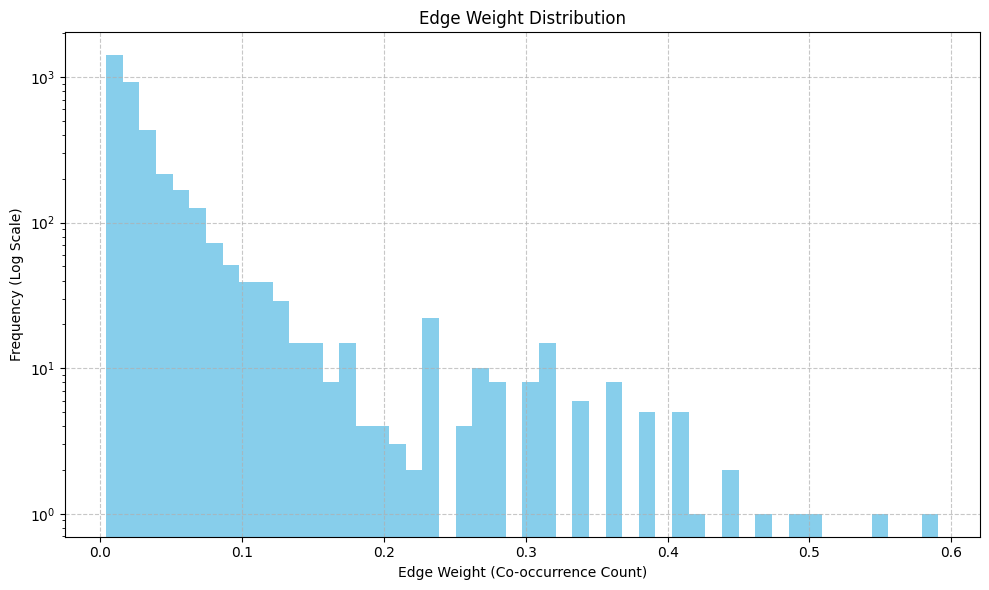

Degree statistics:
  - Min degree: 0
  - Max degree: 86
  - Mean degree: 83.41
  - Median degree: 85.00


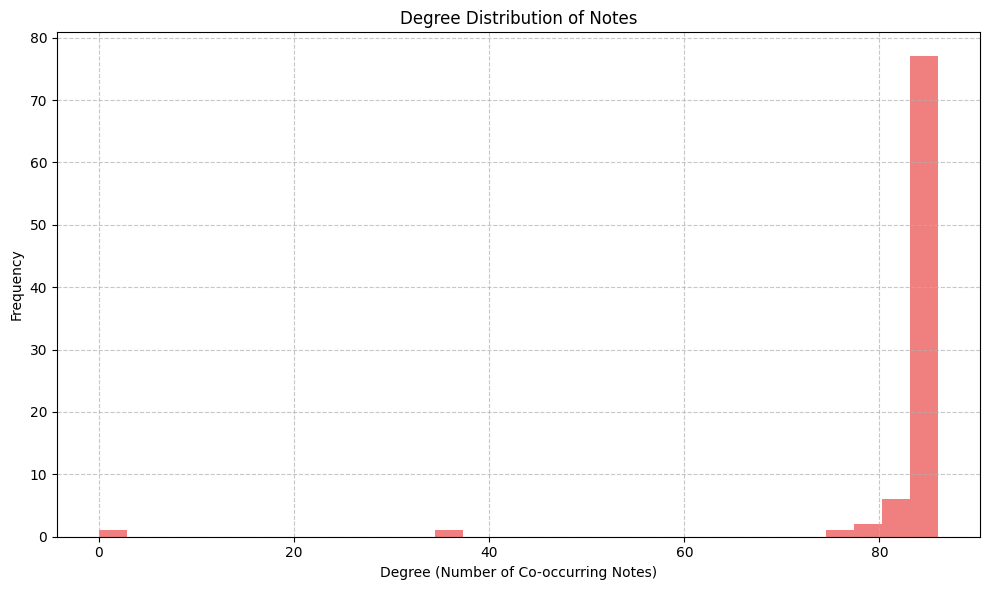

Co-occurrence of MIDI 62 and MIDI 64: 0.0055113365
MIDI 62 and MIDI 64 co-occur 0.0055113365 times.
Correlation between note frequency and degree: 0.2238


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Constants
MIN_MIDI = 21
MAX_MIDI = 108
N_KEYS = MAX_MIDI - MIN_MIDI + 1  # 88 notes

def load_adjacency_matrix(csv_path):
    """Load the adjacency matrix from a CSV file."""
    adj_matrix = pd.read_csv(csv_path, header=None).to_numpy()
    if adj_matrix.shape != (N_KEYS, N_KEYS):
        raise ValueError(f"Expected 88x88 matrix, got shape {adj_matrix.shape}")
    return adj_matrix

def analyze_adjacency_matrix(adj_matrix, csv_path):
    """Analyze and validate the adjacency matrix."""
    print(f"Analyzing adjacency matrix: {csv_path}")
    print(f"Shape: {adj_matrix.shape}")

    # 1. Number of Edges
    # Non-zero entries in the upper triangle (excluding diagonal)
    upper_triangle = np.triu(adj_matrix, k=1)  # k=1 excludes diagonal
    non_zero_entries = np.sum(upper_triangle > 0)
    num_edges = non_zero_entries
    print(f"Number of edges (non-zero entries in upper triangle): {num_edges}")

    # Total non-zero entries (for reference, matches your output)
    total_non_zero = np.sum(adj_matrix > 0)
    print(f"Total non-zero entries (including symmetric pairs): {total_non_zero}")

    # 2. Sparsity
    total_possible_entries = N_KEYS * N_KEYS  # 88x88 = 7744
    total_possible_no_diag = total_possible_entries - N_KEYS  # 7744 - 88 = 7656
    zero_entries_no_diag = total_possible_no_diag - (total_non_zero - np.sum(np.diag(adj_matrix) > 0))
    sparsity = zero_entries_no_diag / total_possible_no_diag
    print(f"Sparsity (excluding diagonal): {sparsity:.4f} ({zero_entries_no_diag}/{total_possible_no_diag} zero entries)")

    # 3. Edge Weight Distribution
    edge_weights = upper_triangle[upper_triangle > 0]
    print(f"Edge weight statistics:")
    print(f"  - Min: {np.min(edge_weights)}")
    print(f"  - Max: {np.max(edge_weights)}")
    print(f"  - Mean: {np.mean(edge_weights):.2f}")
    print(f"  - Median: {np.median(edge_weights):.2f}")

    # Plot edge weight distribution
    plt.figure(figsize=(10, 6))
    plt.hist(edge_weights, bins=50, color='skyblue', log=True)
    plt.xlabel('Edge Weight (Co-occurrence Count)')
    plt.ylabel('Frequency (Log Scale)')
    plt.title('Edge Weight Distribution')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('/kaggle/working/edge_weight_distribution.pdf')
    plt.show()

    # 4. Degree Distribution
    degrees = np.sum(adj_matrix > 0, axis=1)  # Number of non-zero entries per row
    print(f"Degree statistics:")
    print(f"  - Min degree: {np.min(degrees)}")
    print(f"  - Max degree: {np.max(degrees)}")
    print(f"  - Mean degree: {np.mean(degrees):.2f}")
    print(f"  - Median degree: {np.median(degrees):.2f}")

    # Plot degree distribution
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=30, color='lightcoral')
    plt.xlabel('Degree (Number of Co-occurring Notes)')
    plt.ylabel('Frequency')
    plt.title('Degree Distribution of Notes')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('/kaggle/working/degree_distribution.pdf')
    plt.show()

    # 5. Check specific note pair (MIDI 62 and 64)
    midi_62_idx = 62 - MIN_MIDI  # 41
    midi_64_idx = 64 - MIN_MIDI  # 43
    co_occurrence = adj_matrix[midi_62_idx, midi_64_idx]
    print(f"Co-occurrence of MIDI 62 and MIDI 64: {co_occurrence}")
    if co_occurrence > 0:
        print(f"MIDI 62 and MIDI 64 co-occur {co_occurrence} times.")
    else:
        print("MIDI 62 and MIDI 64 do not co-occur.")

    # 6. Validate against note frequencies
    # From your note frequency stats: MIDI 62 (3.11%), MIDI 64 (2.82%)
    # Check if high-frequency notes have higher degrees
    note_freqs = np.array([
        0.00, 0.01, 0.01, 0.02, 0.04, 0.04, 0.05, 0.07, 0.15, 0.19,
        0.26, 0.29, 0.41, 0.37, 0.39, 0.60, 0.49, 0.59, 0.59, 0.66,
        0.82, 0.70, 1.13, 0.98, 1.22, 1.12, 1.14, 1.63, 1.27, 1.90,
        1.61, 1.82, 2.05, 1.70, 2.55, 2.09, 2.58, 2.45, 2.29, 2.86,
        2.40, 3.11, 2.55, 2.82, 2.88, 2.32, 3.06, 2.39, 2.87, 2.42,
        2.35, 2.72, 2.22, 2.67, 2.12, 2.21, 2.08, 1.65, 1.99, 1.50,
        1.62, 1.26, 1.17, 1.18, 0.90, 0.99, 0.80, 0.74, 0.64, 0.49,
        0.49, 0.40, 0.37, 0.30, 0.25, 0.19, 0.19, 0.15, 0.17, 0.12,
        0.07, 0.03, 0.02, 0.01, 0.01, 0.00, 0.00, 0.00
    ])  # Percentages from your output
    # Correlation between note frequency and degree
    correlation = np.corrcoef(note_freqs, degrees)[0, 1]
    print(f"Correlation between note frequency and degree: {correlation:.4f}")

if __name__ == "__main__":
    # Path to the adjacency matrix
    csv_path = '/kaggle/working/p_co.csv'
    adj_matrix = load_adjacency_matrix(csv_path)
    analyze_adjacency_matrix(adj_matrix, csv_path)